In [5]:
%matplotlib inline

In [6]:
import os

In [7]:
%run notebook_setup

ERROR:root:File `'notebook_setup.py'` not found.


# Load data in from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [8]:
import os
HOME = os.environ['HOME']
os.chdir(f'{HOME}/Research/Planets/WASP43/github_analysis')

In [32]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd

import exoplanet as xo

from time import time
from tqdm import tqdm_notebook as tqdm

from arctor import Arctor, info_message, instantiate_arctor, create_raw_lc_stddev

In [10]:
plot_verbose = False
save_now = False
planet_name = 'WASP43'
file_type = 'flt.fits'

HOME = os.environ['HOME']
base_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43')
data_dir = os.path.join(base_dir, 'data', 'UVIS', 'MAST_2019-07-03T0738')
data_dir = os.path.join(data_dir, 'HST', 'FLTs')
working_dir = os.path.join(base_dir, 'github_analysis', 'savefiles')

In [11]:
joblib_filename = 'WASP43_savedict_206ppm_100x100_finescale.joblib.save'
joblib_filename = f'{working_dir}/{joblib_filename}'

In [12]:
planet = instantiate_arctor(planet_name, data_dir, working_dir, file_type)

  9%|▉         | 7/75 [00:00<00:00, 69.37it/s]

[INFO] Initializing Instance of the `Arctor` Object
[INFO] Loading Data from Save File
[INFO] Loading Fits Files


100%|██████████| 75/75 [00:00<00:00, 215.20it/s]


[INFO] Loading Save Object-Dict File
[INFO] Found 75 flt.fits files


In [13]:
planet.load_dict(joblib_filename)

In [14]:
planet.gaussian_centers.shape

(75, 951)

In [15]:
if not hasattr(planet, 'gaussian_centers'):
    planet.clean_cosmic_rays()
    planet.calibration_trace_location()
    planet.identify_trace_direction()
    planet.simple_phots()
    planet.center_all_traces()
    planet.fit_trace_slopes()
    planet.compute_sky_background(subpixels=32)
    planet.compute_columnwise_sky_background()

# Run Multi-Phot

In [16]:
if not hasattr(planet, 'photometry_df'):
    # Set up the list of aperture widths and heights to search
    min_aper_width = 1
    max_aper_width = 100
    min_aper_height = 1
    max_aper_height = 100

    aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
    aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)
    
    planet.do_multi_phot(aper_widths, aper_heights)

# Determine the 'best' photometry SNR

In [17]:
med_photometry_df = np.median(planet.photometry_df, axis=0)
planet.normed_photometry_df = planet.photometry_df / med_photometry_df
planet.normed_uncertainty_df = np.sqrt(planet.photometry_df) / med_photometry_df

In [18]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [19]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [20]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 209ppm with 20x50 aperture size; with median uncertainties of 126 ppm


# Configure system for PyMC3

In [21]:
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev

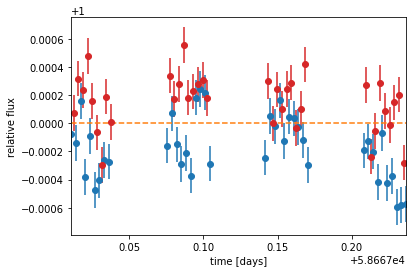

In [22]:
# Compute a limb-darkened light curve using starry
times = planet.times
u = []
flux = planet.normed_photometry_df['aperture_sum_16x51']
yerr = planet.normed_uncertainty_df['aperture_sum_16x51']

plt.errorbar(times[idx_fwd], flux[idx_fwd], yerr[idx_fwd], fmt='o', color="C0")
plt.errorbar(times[idx_rev], flux[idx_rev], yerr[idx_rev], fmt='o', color="C3")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [23]:
np.random.seed(42)

time_med = np.median(times)
med_t_diff = np.median(np.diff(times))

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [24]:
print(f'This instance has {mp.cpu_count()} CPUs')

This instance has 16 CPUs


In [25]:
import pymc3 as pm
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]
t0 = time_med
edepth = np.sqrt(1000/1e6)

orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
injected_light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=times).eval().flatten()

/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


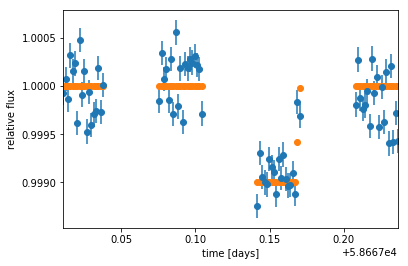

In [31]:
plt.errorbar(times, flux * (injected_light_curves+1), yerr, fmt='o')
plt.plot(times, injected_light_curves+1,'o')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

In [27]:
t0_wasp43 = 55528.3684  # exo.mast.stsci.edu
n_epochs = np.int(np.round(((time_med - t0_wasp43) / period)-0.5))
n_epochs, ((time_med - t0_wasp43) / period)
t0_guess = t0_wasp43 + (n_epochs+0.5) * period

# t0s = np.random.normal(t0_guess, 0.1*med_t_diff, size=2)
t0s = t0_guess

# Run 400 MCMCs

In [39]:
import pymc3 as pm
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]

# oot_guess = np.median(np.r_[flux[:2*18], flux[-18:]])
# stellar_variance = np.std(np.r_[flux[:2*18], flux[-18:]])
data = flux * (injected_light_curves+1)# - oot_guess
t0 = t0_guess

def run_pymc3(times, data, yerr, t0, u, period, b, xcenters=None,
              tune=3000, draws=3000, target_accept=0.9):
    xcenter_mod = xcenters - np.median(xcenters)
    times_mod = times - np.median(times)  # t0_guess
    
    with pm.Model() as model:

        # The baseline flux
        mean = pm.Normal("mean", mu=1.0, sd=1.0)

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        # u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

        # edepth = pm.Uniform("edepth", lower=-0.1, upper=0.1)
        edepth = pm.Uniform("edepth", lower=0, upper=0.1)
        edepth = np.sqrt(edepth)
        
        slope = pm.Uniform("slope", lower=-0.1, upper=0.1)
        slope_xc = pm.Uniform("slope_xcenter", lower=-0.1, upper=0.1)
        
        line = slope * times_mod + slope_xc * xcenter_mod + mean
        
        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0s, b=b)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=times)
        light_curve = pm.math.sum(light_curves, axis=-1) 
        pm.Deterministic("light_curves", light_curves)
        
        # Combined model: light curve and background
        model_ = light_curve + line
        
        # The likelihood function assuming known Gaussian uncertainty
        pm.Normal("obs", mu=model_, sd=yerr, observed=data)

        # Fit for the maximum a posteriori parameters given the simuated dataset
        map_soln = xo.optimize(start=model.test_point)

        np.random.seed(42)

        trace = pm.sample(
            tune=tune,
            draws=draws,
            start=map_soln,
            chains=mp.cpu_count(),
            step=xo.get_dense_nuts_step(target_accept=target_accept),
            cores=mp.cpu_count()
        )
    
    return trace, map_soln

In [40]:
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]

oot_guess = np.median(np.r_[flux[:2*18], flux[-18:]])
# stellar_variance = np.std(np.r_[flux[:2*18], flux[-18:]])
data = flux * (injected_light_curves+1)# - oot_guess
t0 = t0_guess

edepth = np.sqrt(1000/1e6)
orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
injected_light_curve = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=times).eval().flatten()

In [41]:
fine_snr_flux = planet.normed_photometry_df
fine_snr_uncs = planet.normed_uncertainty_df

n_columns = len(fine_snr_flux.columns)

aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns

xcenters = planet.photometry_df['xcenter']

varnames = ["edepth", "slope_xcenter", "mean", "slope"]

fine_grain_mcmcs_w_xcenterfit = {}
for colname in aper_sum_columns:  # [fine_min_snr_colname]:  # 
    start = time()
    info_message(f'Working on {colname} for Trace MCMCs')
    data = fine_snr_flux[colname] #* (injected_light_curve + 1.0)
    yerr = fine_snr_uncs[colname]
    
    trace, map_soln = run_pymc3(times, data, yerr, t0, u, period, b, xcenters=xcenters)
    fine_grain_mcmcs_w_xcenterfit[colname] = {}
    fine_grain_mcmcs_w_xcenterfit[colname]['trace'] = trace
    fine_grain_mcmcs_w_xcenterfit[colname]['map_soln'] = map_soln
    info_message(f'Completed {colname} for Trace MCMCs took {time()-start}')
    print(pm.summary(trace, var_names=varnames))

filename = 'WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit_1000ppm_no_injected.joblib.save'
filename = os.path.join(working_dir, filename)

info_message(f'Saving MCMCs to {filename}')
joblib.dump(fine_grain_mcmcs_w_xcenterfit, filename)

[INFO] Working on aperture_sum_11x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
0it [00:00, ?it/s]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
58it [00:00, 363.68it/s, logp=5.081967e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
60it [00:00, 363.68it/s, logp=5.08196

[INFO] Completed aperture_sum_11x41 for Trace MCMCs took 115.0251407623291
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.143854e-08  7.219382e-10  0.000028   
slope_xcenter  0.001079  0.000086  3.598157e-07  9.117647e-04  0.001246   
mean           0.999924  0.000016  6.171743e-08  9.998930e-01  0.999955   
slope         -0.001792  0.000220  1.057408e-06 -2.216992e-03 -0.001358   

                      n_eff      Rhat  
edepth         51628.912154  0.999899  
slope_xcenter  52829.036561  0.999976  
mean           54458.276401  0.999946  
slope          52378.257469  1.000091  
[INFO] Working on aperture_sum_12x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 453.53it/s, logp=5.081797e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 453.53it/s, logp=5.081797e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:

[INFO] Completed aperture_sum_12x41 for Trace MCMCs took 96.18285393714905
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.138088e-08  3.580494e-11  0.000028   
slope_xcenter  0.001076  0.000086  3.908979e-07  9.057742e-04  0.001246   
mean           0.999926  0.000016  6.218008e-08  9.998948e-01  0.999957   
slope         -0.001795  0.000219  1.023324e-06 -2.213822e-03 -0.001356   

                      n_eff      Rhat  
edepth         52189.219194  1.000082  
slope_xcenter  51942.837405  0.999945  
mean           55025.137648  0.999937  
slope          51918.846796  0.999966  
[INFO] Working on aperture_sum_13x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 85.44it/s, logp=5.081853e+02] 
message: Optimization terminated successfully.
logp: -1447218.1551973056 -> 508.1852883632872
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1433.94draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_13x41 for Trace MCMCs took 93.40341186523438
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.842667e-08  4.903066e-10  0.000028   
slope_xcenter  0.001082  0.000086  3.478707e-07  9.128622e-04  0.001248   
mean           0.999924  0.000016  7.015771e-08  9.998934e-01  0.999956   
slope         -0.001797  0.000219  9.730120e-07 -2.236263e-03 -0.001378   

                      n_eff      Rhat  
edepth         50703.003763  1.000011  
slope_xcenter  51363.113857  0.999921  
mean           52473.464725  1.000009  
slope          53068.566179  0.999986  
[INFO] Working on aperture_sum_14x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
115it [00:00, 553.66it/s, logp=5.081555e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
127it [00:00, 553.66it/s, logp=5.081555e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
128it [00:

[INFO] Completed aperture_sum_14x41 for Trace MCMCs took 92.78520774841309
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.459342e-08  1.421244e-10  0.000028   
slope_xcenter  0.001082  0.000086  3.299713e-07  9.134597e-04  0.001248   
mean           0.999923  0.000016  6.348646e-08  9.998915e-01  0.999954   
slope         -0.001799  0.000218  9.738803e-07 -2.231628e-03 -0.001376   

                      n_eff      Rhat  
edepth         50283.592172  0.999905  
slope_xcenter  53175.666729  1.000024  
mean           52283.488458  0.999949  
slope          53092.245452  1.000094  
[INFO] Working on aperture_sum_15x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 476.53it/s, logp=5.080788e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00:00, 476.53it/s, logp=5.080788e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:0

[INFO] Completed aperture_sum_15x41 for Trace MCMCs took 93.9924099445343
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.990816e-08  7.693835e-10  0.000028   
slope_xcenter  0.001087  0.000086  3.199061e-07  9.199899e-04  0.001258   
mean           0.999922  0.000016  7.382431e-08  9.998906e-01  0.999953   
slope         -0.001803  0.000218  9.659493e-07 -2.231711e-03 -0.001376   

                      n_eff      Rhat  
edepth         50793.466104  0.999995  
slope_xcenter  52101.179983  0.999956  
mean           53126.049443  0.999971  
slope          53167.819690  0.999998  
[INFO] Working on aperture_sum_16x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
118it [00:00, 570.58it/s, logp=5.079602e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:00, 570.58it/s, logp=5.079602e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
131it [00:

[INFO] Completed aperture_sum_16x41 for Trace MCMCs took 92.88526439666748
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.837746e-08  1.779312e-10  0.000028   
slope_xcenter  0.001086  0.000086  3.640923e-07  9.216704e-04  0.001257   
mean           0.999922  0.000016  7.259999e-08  9.998902e-01  0.999952   
slope         -0.001800  0.000218  9.019183e-07 -2.219007e-03 -0.001367   

                      n_eff      Rhat  
edepth         51307.498168  0.999956  
slope_xcenter  52013.187534  1.000001  
mean           52915.232926  0.999975  
slope          52312.809441  0.999928  
[INFO] Working on aperture_sum_17x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 504.18it/s, logp=5.078692e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
124it [00:00, 504.18it/s, logp=5.078692e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
125it [00:

[INFO] Completed aperture_sum_17x41 for Trace MCMCs took 95.75904488563538
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.911271e-08  9.471596e-11  0.000028   
slope_xcenter  0.001089  0.000086  3.539099e-07  9.241217e-04  0.001261   
mean           0.999921  0.000016  7.633005e-08  9.998893e-01  0.999951   
slope         -0.001800  0.000219  1.041276e-06 -2.222946e-03 -0.001363   

                      n_eff      Rhat  
edepth         49476.673344  0.999963  
slope_xcenter  52791.365397  0.999995  
mean           51572.313955  1.000024  
slope          51897.947059  1.000194  
[INFO] Working on aperture_sum_18x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 568.90it/s, logp=5.077940e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 537.61it/s, logp=5.077940e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:

[INFO] Completed aperture_sum_18x41 for Trace MCMCs took 96.98116087913513
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.294938e-08  1.706913e-10  0.000028   
slope_xcenter  0.001088  0.000085  3.932535e-07  9.206747e-04  0.001255   
mean           0.999921  0.000016  7.740613e-08  9.998900e-01  0.999953   
slope         -0.001796  0.000218  8.591307e-07 -2.225260e-03 -0.001368   

                      n_eff      Rhat  
edepth         50334.142538  1.000037  
slope_xcenter  51116.035470  0.999967  
mean           51948.941844  1.000021  
slope          52873.313238  0.999954  
[INFO] Working on aperture_sum_19x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
123it [00:00, 597.47it/s, logp=5.077693e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
135it [00:00, 610.02it/s, logp=5.077693e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
136it [00:

[INFO] Completed aperture_sum_19x41 for Trace MCMCs took 96.16702699661255
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.089871e-08  2.094800e-10  0.000028   
slope_xcenter  0.001091  0.000087  3.789012e-07  9.274185e-04  0.001266   
mean           0.999920  0.000016  7.167779e-08  9.998893e-01  0.999951   
slope         -0.001800  0.000218  1.117732e-06 -2.225110e-03 -0.001373   

                      n_eff      Rhat  
edepth         53134.584788  0.999988  
slope_xcenter  51857.046908  0.999938  
mean           51291.531639  0.999993  
slope          51974.433856  1.000026  
[INFO] Working on aperture_sum_20x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
63it [00:00, 701.50it/s, logp=5.078255e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
65it [00:00, 701.44it/s, logp=5.078255e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
67it [00:00,

[INFO] Completed aperture_sum_20x41 for Trace MCMCs took 94.30625128746033
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.971705e-08  5.507045e-11  0.000028   
slope_xcenter  0.001090  0.000086  3.742538e-07  9.234127e-04  0.001259   
mean           0.999921  0.000016  7.331331e-08  9.998885e-01  0.999951   
slope         -0.001801  0.000220  8.511417e-07 -2.230526e-03 -0.001366   

                      n_eff      Rhat  
edepth         49271.938629  0.999996  
slope_xcenter  52636.198588  0.999893  
mean           52251.211384  1.000007  
slope          51754.136480  0.999926  
[INFO] Working on aperture_sum_21x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 517.00it/s, logp=5.078178e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
121it [00:00, 517.00it/s, logp=5.078178e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
122it [00:

[INFO] Completed aperture_sum_21x41 for Trace MCMCs took 96.88420248031616
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.554823e-08  2.382049e-10  0.000028   
slope_xcenter  0.001094  0.000086  3.804049e-07  9.228180e-04  0.001260   
mean           0.999920  0.000016  7.176189e-08  9.998883e-01  0.999951   
slope         -0.001805  0.000219  9.046703e-07 -2.223334e-03 -0.001370   

                      n_eff      Rhat  
edepth         52605.399934  0.999948  
slope_xcenter  52267.315829  0.999964  
mean           52259.662682  0.999993  
slope          51759.478450  0.999940  
[INFO] Working on aperture_sum_22x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 588.82it/s, logp=5.077294e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00, 588.82it/s, logp=5.077294e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:0

[INFO] Completed aperture_sum_22x41 for Trace MCMCs took 93.20090627670288
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.626993e-08  8.390665e-10  0.000027   
slope_xcenter  0.001093  0.000086  3.380478e-07  9.241872e-04  0.001263   
mean           0.999920  0.000016  7.009622e-08  9.998881e-01  0.999950   
slope         -0.001803  0.000219  1.035272e-06 -2.245301e-03 -0.001388   

                      n_eff      Rhat  
edepth         52132.027891  0.999937  
slope_xcenter  51167.441109  0.999925  
mean           51886.397466  0.999952  
slope          53615.017305  1.000007  
[INFO] Working on aperture_sum_23x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
121it [00:00, 647.18it/s, logp=5.077037e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
125it [00:00, 629.06it/s, logp=5.077037e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
192it [00:

[INFO] Completed aperture_sum_23x41 for Trace MCMCs took 92.48248481750488
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.989902e-08  1.780067e-10  0.000028   
slope_xcenter  0.001095  0.000086  3.802774e-07  9.250999e-04  0.001260   
mean           0.999918  0.000016  6.973509e-08  9.998866e-01  0.999949   
slope         -0.001805  0.000216  9.924319e-07 -2.224917e-03 -0.001377   

                      n_eff      Rhat  
edepth         50536.263016  0.999984  
slope_xcenter  53011.220394  0.999919  
mean           53218.136027  1.000008  
slope          52346.605364  0.999925  
[INFO] Working on aperture_sum_24x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 591.88it/s, logp=5.077985e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00, 591.88it/s, logp=5.077985e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:

[INFO] Completed aperture_sum_24x41 for Trace MCMCs took 95.04958462715149
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.522334e-08  8.391509e-10  0.000028   
slope_xcenter  0.001096  0.000086  3.544257e-07  9.309227e-04  0.001265   
mean           0.999919  0.000016  6.565740e-08  9.998871e-01  0.999949   
slope         -0.001807  0.000220  9.325904e-07 -2.252261e-03 -0.001388   

                      n_eff      Rhat  
edepth         51961.368676  1.000055  
slope_xcenter  50893.761238  0.999994  
mean           52153.612147  1.000070  
slope          51809.210468  0.999925  
[INFO] Working on aperture_sum_25x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 119.30it/s, logp=5.078731e+02]
message: Optimization terminated successfully.
logp: -1447842.2282270805 -> 507.87308720013806
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1405.29draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_25x41 for Trace MCMCs took 93.43193030357361
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.664232e-08  3.669505e-11  0.000027   
slope_xcenter  0.001098  0.000087  3.508303e-07  9.241573e-04  0.001262   
mean           0.999920  0.000016  6.565991e-08  9.998887e-01  0.999952   
slope         -0.001808  0.000219  9.167254e-07 -2.248266e-03 -0.001385   

                      n_eff      Rhat  
edepth         51186.912620  0.999963  
slope_xcenter  52447.604045  0.999937  
mean           53179.623990  0.999910  
slope          51468.306617  0.999975  
[INFO] Working on aperture_sum_26x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 518.90it/s, logp=5.078579e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00, 518.90it/s, logp=5.078579e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:

[INFO] Completed aperture_sum_26x41 for Trace MCMCs took 94.87960004806519
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.052143e-08  6.419994e-11  0.000028   
slope_xcenter  0.001099  0.000086  4.157141e-07  9.308699e-04  0.001266   
mean           0.999921  0.000016  7.539190e-08  9.998900e-01  0.999952   
slope         -0.001810  0.000219  1.024109e-06 -2.234138e-03 -0.001368   

                      n_eff      Rhat  
edepth         52257.195058  0.999957  
slope_xcenter  50497.023954  1.000153  
mean           52696.806052  1.000027  
slope          51395.505448  1.000074  
[INFO] Working on aperture_sum_27x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 491.82it/s, logp=5.078364e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 487.55it/s, logp=5.078364e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00,

[INFO] Completed aperture_sum_27x41 for Trace MCMCs took 90.69186592102051
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  5.569064e-08  7.660572e-10  0.000027   
slope_xcenter  0.001100  0.000086  3.732092e-07  9.334129e-04  0.001271   
mean           0.999920  0.000016  7.502076e-08  9.998895e-01  0.999952   
slope         -0.001811  0.000221  1.003157e-06 -2.229731e-03 -0.001361   

                      n_eff      Rhat  
edepth         29127.046188  1.000161  
slope_xcenter  51715.781308  1.000036  
mean           52581.653075  0.999984  
slope          49880.729612  1.000031  
[INFO] Working on aperture_sum_28x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
106it [00:00, 519.62it/s, logp=5.078474e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:00, 519.62it/s, logp=5.078474e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:

[INFO] Completed aperture_sum_28x41 for Trace MCMCs took 95.56484484672546
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.073555e-08  6.197249e-10  0.000028   
slope_xcenter  0.001100  0.000085  4.029769e-07  9.320107e-04  0.001266   
mean           0.999920  0.000016  6.716560e-08  9.998899e-01  0.999952   
slope         -0.001812  0.000219  9.881408e-07 -2.239044e-03 -0.001383   

                      n_eff      Rhat  
edepth         49226.940441  1.000052  
slope_xcenter  51243.716673  1.000176  
mean           52788.329735  0.999934  
slope          54573.518440  1.000162  
[INFO] Working on aperture_sum_29x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 110.06it/s, logp=5.078260e+02]
message: Optimization terminated successfully.
logp: -1447988.3791202728 -> 507.82597906766307
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1439.70draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_29x41 for Trace MCMCs took 91.04067540168762
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.630501e-08  1.828024e-11  0.000028   
slope_xcenter  0.001101  0.000086  4.077512e-07  9.322583e-04  0.001271   
mean           0.999919  0.000016  6.658073e-08  9.998883e-01  0.999951   
slope         -0.001814  0.000219  1.001280e-06 -2.251258e-03 -0.001392   

                      n_eff      Rhat  
edepth         53106.140683  1.000042  
slope_xcenter  52307.764620  0.999958  
mean           50281.682297  0.999951  
slope          53502.805197  0.999989  
[INFO] Working on aperture_sum_30x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
122it [00:00, 527.18it/s, logp=5.077573e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:00, 527.18it/s, logp=5.077573e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
135it [00:

[INFO] Completed aperture_sum_30x41 for Trace MCMCs took 93.34033036231995
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.805251e-08  2.858620e-12  0.000028   
slope_xcenter  0.001101  0.000086  3.702183e-07  9.359338e-04  0.001273   
mean           0.999919  0.000016  6.808763e-08  9.998885e-01  0.999951   
slope         -0.001813  0.000220  9.552723e-07 -2.243396e-03 -0.001376   

                      n_eff      Rhat  
edepth         51112.633849  1.000043  
slope_xcenter  50492.535097  0.999956  
mean           51770.716140  0.999993  
slope          51935.934618  1.000024  
[INFO] Working on aperture_sum_11x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
130it [00:00, 518.18it/s, logp=5.088853e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
142it [00:00, 518.18it/s, logp=5.088853e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
143it [00:

[INFO] Completed aperture_sum_11x42 for Trace MCMCs took 93.35927152633667
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.169269e-08  8.724823e-10  0.000028   
slope_xcenter  0.001077  0.000086  3.389270e-07  9.060968e-04  0.001244   
mean           0.999923  0.000016  7.118971e-08  9.998914e-01  0.999954   
slope         -0.001794  0.000219  9.638382e-07 -2.227685e-03 -0.001371   

                      n_eff      Rhat  
edepth         50528.868054  1.000103  
slope_xcenter  53199.840846  1.000059  
mean           54200.837402  0.999952  
slope          52935.988980  1.000120  
[INFO] Working on aperture_sum_12x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 583.28it/s, logp=5.088639e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 583.28it/s, logp=5.088639e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
195it [00:00

[INFO] Completed aperture_sum_12x42 for Trace MCMCs took 94.74354124069214
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.369661e-08  1.458774e-10  0.000028   
slope_xcenter  0.001076  0.000087  2.962356e-07  9.064462e-04  0.001246   
mean           0.999925  0.000016  6.819249e-08  9.998931e-01  0.999956   
slope         -0.001797  0.000219  9.541157e-07 -2.217874e-03 -0.001355   

                      n_eff      Rhat  
edepth         50749.697360  1.000030  
slope_xcenter  52014.534540  0.999959  
mean           53317.966145  0.999951  
slope          51699.631218  0.999960  
[INFO] Working on aperture_sum_13x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 548.81it/s, logp=5.088623e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 527.78it/s, logp=5.088623e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_13x42 for Trace MCMCs took 91.69339680671692
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.622753e-08  3.085140e-10  0.000028   
slope_xcenter  0.001081  0.000086  3.868512e-07  9.128618e-04  0.001248   
mean           0.999923  0.000016  7.738210e-08  9.998921e-01  0.999955   
slope         -0.001799  0.000219  1.012954e-06 -2.236754e-03 -0.001374   

                      n_eff      Rhat  
edepth         51003.203987  0.999916  
slope_xcenter  50419.609029  0.999970  
mean           52270.722536  1.000088  
slope          52076.497528  1.000012  
[INFO] Working on aperture_sum_14x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 511.40it/s, logp=5.088306e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:00, 511.40it/s, logp=5.088306e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
121it [00:

[INFO] Completed aperture_sum_14x42 for Trace MCMCs took 93.84693002700806
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.115386e-08  1.124859e-10  0.000028   
slope_xcenter  0.001080  0.000086  3.624447e-07  9.072687e-04  0.001243   
mean           0.999922  0.000016  6.895912e-08  9.998911e-01  0.999954   
slope         -0.001800  0.000217  9.387988e-07 -2.237020e-03 -0.001388   

                      n_eff      Rhat  
edepth         49303.614753  1.000065  
slope_xcenter  51920.118878  0.999977  
mean           51566.966822  0.999936  
slope          52151.135097  0.999926  
[INFO] Working on aperture_sum_15x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
48it [00:00, 114.93it/s, logp=5.087610e+02]
message: Optimization terminated successfully.
logp: -1448408.5301756822 -> 508.76097812742637
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1397.69draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_15x42 for Trace MCMCs took 95.61262106895447
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.057897e-08  3.202213e-10  0.000028   
slope_xcenter  0.001085  0.000085  3.936957e-07  9.176253e-04  0.001253   
mean           0.999920  0.000016  6.971887e-08  9.998886e-01  0.999952   
slope         -0.001802  0.000217  9.441815e-07 -2.217029e-03 -0.001366   

                      n_eff      Rhat  
edepth         49459.869961  1.000064  
slope_xcenter  50390.410357  0.999988  
mean           50806.106308  0.999951  
slope          51180.504431  1.000020  
[INFO] Working on aperture_sum_16x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 112.76it/s, logp=5.086417e+02]
message: Optimization terminated successfully.
logp: -1448473.6987004266 -> 508.6417217210323
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1421.91draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_16x42 for Trace MCMCs took 92.02262496948242
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.084973e-08  3.269032e-10  0.000028   
slope_xcenter  0.001084  0.000086  3.646003e-07  9.157531e-04  0.001254   
mean           0.999921  0.000016  6.773838e-08  9.998891e-01  0.999951   
slope         -0.001802  0.000218  9.459457e-07 -2.230506e-03 -0.001376   

                      n_eff      Rhat  
edepth         52903.482645  0.999961  
slope_xcenter  52855.077954  1.000061  
mean           53536.608360  1.000015  
slope          51687.570585  1.000015  
[INFO] Working on aperture_sum_17x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 529.73it/s, logp=5.085424e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:00, 529.73it/s, logp=5.085424e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:

[INFO] Completed aperture_sum_17x42 for Trace MCMCs took 90.54945373535156
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.207287e-08  1.033069e-10  0.000028   
slope_xcenter  0.001088  0.000086  3.824487e-07  9.215518e-04  0.001259   
mean           0.999919  0.000016  6.288009e-08  9.998880e-01  0.999950   
slope         -0.001802  0.000219  9.635389e-07 -2.245233e-03 -0.001385   

                      n_eff      Rhat  
edepth         51192.100780  0.999974  
slope_xcenter  51023.370307  0.999998  
mean           51208.782422  1.000011  
slope          50576.740123  1.000022  
[INFO] Working on aperture_sum_18x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
121it [00:00, 586.17it/s, logp=5.084649e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:00, 603.65it/s, logp=5.084649e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:

[INFO] Completed aperture_sum_18x42 for Trace MCMCs took 93.60464453697205
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.692269e-08  4.598220e-11  0.000028   
slope_xcenter  0.001087  0.000086  3.620789e-07  9.155255e-04  0.001254   
mean           0.999919  0.000016  6.478764e-08  9.998884e-01  0.999951   
slope         -0.001798  0.000217  9.413321e-07 -2.230065e-03 -0.001377   

                      n_eff      Rhat  
edepth         49644.332895  0.999953  
slope_xcenter  52615.120401  0.999946  
mean           53300.618143  0.999977  
slope          52841.289242  0.999962  
[INFO] Working on aperture_sum_19x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 130.88it/s, logp=5.084449e+02]
message: Optimization terminated successfully.
logp: -1448618.736099196 -> 508.44486784183863
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1424.79draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_19x42 for Trace MCMCs took 92.07103371620178
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.669520e-08  2.892161e-11  0.000028   
slope_xcenter  0.001090  0.000086  3.893154e-07  9.211464e-04  0.001258   
mean           0.999919  0.000016  6.966056e-08  9.998878e-01  0.999950   
slope         -0.001802  0.000218  9.854756e-07 -2.224768e-03 -0.001368   

                      n_eff      Rhat  
edepth         51024.805028  0.999946  
slope_xcenter  51737.007577  1.000099  
mean           53496.394989  0.999929  
slope          51935.916669  1.000061  
[INFO] Working on aperture_sum_20x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 109.90it/s, logp=5.085028e+02]
message: Optimization terminated successfully.
logp: -1448707.581606532 -> 508.5028402660758
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1396.37draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_20x42 for Trace MCMCs took 93.34124374389648
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.556647e-08  4.376375e-11  0.000028   
slope_xcenter  0.001089  0.000086  4.013888e-07  9.209355e-04  0.001258   
mean           0.999919  0.000016  6.212100e-08  9.998883e-01  0.999950   
slope         -0.001803  0.000218  1.007213e-06 -2.224085e-03 -0.001368   

                      n_eff      Rhat  
edepth         52694.485037  1.000023  
slope_xcenter  51683.310331  1.000008  
mean           52835.837901  0.999936  
slope          49413.369008  1.000080  
[INFO] Working on aperture_sum_21x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 494.19it/s, logp=5.084921e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
123it [00:00, 494.19it/s, logp=5.084921e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
124it [00:

[INFO] Completed aperture_sum_21x42 for Trace MCMCs took 93.59222960472107
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.166207e-08  1.052254e-10  0.000028   
slope_xcenter  0.001091  0.000086  3.369343e-07  9.210741e-04  0.001257   
mean           0.999918  0.000016  7.073132e-08  9.998873e-01  0.999949   
slope         -0.001804  0.000220  1.001449e-06 -2.245621e-03 -0.001379   

                      n_eff      Rhat  
edepth         51190.316485  1.000006  
slope_xcenter  50264.466027  0.999917  
mean           52936.151355  1.000022  
slope          50289.137814  0.999959  
[INFO] Working on aperture_sum_22x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 117.09it/s, logp=5.084038e+02]
message: Optimization terminated successfully.
logp: -1448790.0771347198 -> 508.40382984531055
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1395.27draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_22x42 for Trace MCMCs took 93.61924004554749
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.782150e-08  4.618130e-10  0.000028   
slope_xcenter  0.001091  0.000086  3.843353e-07  9.205378e-04  0.001256   
mean           0.999918  0.000016  7.461250e-08  9.998875e-01  0.999950   
slope         -0.001806  0.000218  9.560481e-07 -2.230378e-03 -0.001372   

                      n_eff      Rhat  
edepth         49243.362656  1.000001  
slope_xcenter  48975.980391  1.000089  
mean           52726.031709  1.000155  
slope          51959.526602  0.999934  
[INFO] Working on aperture_sum_23x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 500.93it/s, logp=5.083835e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:00, 500.93it/s, logp=5.083835e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:

[INFO] Completed aperture_sum_23x42 for Trace MCMCs took 91.68584418296814
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.509080e-08  1.008689e-10  0.000028   
slope_xcenter  0.001095  0.000085  3.416050e-07  9.313190e-04  0.001266   
mean           0.999917  0.000016  7.181095e-08  9.998853e-01  0.999948   
slope         -0.001807  0.000219  1.047237e-06 -2.241927e-03 -0.001379   

                      n_eff      Rhat  
edepth         51379.958349  0.999943  
slope_xcenter  53470.125856  0.999950  
mean           52226.820218  0.999924  
slope          51944.295058  1.000105  
[INFO] Working on aperture_sum_24x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 519.73it/s, logp=5.084818e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
122it [00:00, 519.73it/s, logp=5.084818e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
123it [00:

[INFO] Completed aperture_sum_24x42 for Trace MCMCs took 91.91243314743042
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.257891e-08  2.845983e-10  0.000028   
slope_xcenter  0.001095  0.000087  3.488496e-07  9.211847e-04  0.001263   
mean           0.999918  0.000016  7.035752e-08  9.998860e-01  0.999949   
slope         -0.001807  0.000218  9.644260e-07 -2.225994e-03 -0.001376   

                      n_eff      Rhat  
edepth         50814.778174  0.999963  
slope_xcenter  54671.616912  1.000007  
mean           53143.234717  1.000028  
slope          54504.586787  0.999993  
[INFO] Working on aperture_sum_25x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
116it [00:00, 550.69it/s, logp=5.085583e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:00, 550.69it/s, logp=5.085583e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
173it [00:

[INFO] Completed aperture_sum_25x42 for Trace MCMCs took 92.73399758338928
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.923818e-08  1.348077e-10  0.000028   
slope_xcenter  0.001097  0.000086  4.022606e-07  9.301934e-04  0.001266   
mean           0.999919  0.000016  8.071809e-08  9.998873e-01  0.999950   
slope         -0.001809  0.000219  1.121320e-06 -2.238718e-03 -0.001380   

                      n_eff      Rhat  
edepth         53295.026660  0.999976  
slope_xcenter  51345.390300  0.999951  
mean           52033.986272  1.000169  
slope          52031.439740  1.000021  
[INFO] Working on aperture_sum_26x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
106it [00:00, 656.24it/s, logp=5.085446e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:00, 601.49it/s, logp=5.085446e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:

[INFO] Completed aperture_sum_26x42 for Trace MCMCs took 92.55911231040955
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.742899e-08  7.564575e-11  0.000028   
slope_xcenter  0.001096  0.000086  3.569943e-07  9.288702e-04  0.001264   
mean           0.999919  0.000016  6.694654e-08  9.998878e-01  0.999951   
slope         -0.001810  0.000218  9.405378e-07 -2.239515e-03 -0.001386   

                      n_eff      Rhat  
edepth         53044.981904  0.999971  
slope_xcenter  53623.742761  0.999887  
mean           52020.167455  0.999996  
slope          51023.154202  1.000026  
[INFO] Working on aperture_sum_27x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
77it [00:00, 645.28it/s, logp=5.085245e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
81it [00:00, 645.28it/s, logp=5.085245e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:00

[INFO] Completed aperture_sum_27x42 for Trace MCMCs took 94.69996905326843
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.630149e-08  3.200588e-10  0.000028   
slope_xcenter  0.001098  0.000086  3.775792e-07  9.317902e-04  0.001268   
mean           0.999919  0.000016  6.900124e-08  9.998881e-01  0.999951   
slope         -0.001813  0.000220  1.043819e-06 -2.245414e-03 -0.001390   

                      n_eff      Rhat  
edepth         52021.473630  0.999941  
slope_xcenter  49508.974550  0.999994  
mean           51980.856346  1.000130  
slope          49932.128053  1.000044  
[INFO] Working on aperture_sum_28x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
80it [00:00, 542.82it/s, logp=5.085354e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
82it [00:00, 542.82it/s, logp=5.085354e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
172it [00:00

[INFO] Completed aperture_sum_28x42 for Trace MCMCs took 91.11341118812561
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.087252e-08  2.831528e-10  0.000028   
slope_xcenter  0.001098  0.000087  3.316632e-07  9.269352e-04  0.001267   
mean           0.999919  0.000016  6.703848e-08  9.998873e-01  0.999950   
slope         -0.001814  0.000221  9.927435e-07 -2.251487e-03 -0.001385   

                      n_eff      Rhat  
edepth         52066.030343  0.999992  
slope_xcenter  52469.790353  0.999925  
mean           54723.258297  0.999926  
slope          51218.723271  0.999912  
[INFO] Working on aperture_sum_29x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
79it [00:00, 502.92it/s, logp=5.085142e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
91it [00:00, 502.92it/s, logp=5.085142e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
92it [00:00,

[INFO] Completed aperture_sum_29x42 for Trace MCMCs took 91.74188566207886
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.651658e-08  1.798604e-10  0.000028   
slope_xcenter  0.001100  0.000086  4.346866e-07  9.326508e-04  0.001270   
mean           0.999918  0.000016  7.269399e-08  9.998869e-01  0.999950   
slope         -0.001815  0.000218  9.573132e-07 -2.238821e-03 -0.001386   

                      n_eff      Rhat  
edepth         48058.885538  0.999946  
slope_xcenter  52528.235963  1.000112  
mean           51143.799917  1.000035  
slope          51445.238435  1.000017  
[INFO] Working on aperture_sum_30x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 529.30it/s, logp=5.084492e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
95it [00:00, 529.30it/s, logp=5.084492e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
141it [00:00

[INFO] Completed aperture_sum_30x42 for Trace MCMCs took 283.9932150840759
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.992744e-08  2.695778e-10  0.000028   
slope_xcenter  0.001100  0.000086  3.801809e-07  9.340588e-04  0.001270   
mean           0.999918  0.000016  7.148119e-08  9.998867e-01  0.999949   
slope         -0.001815  0.000218  1.038481e-06 -2.242750e-03 -0.001388   

                      n_eff      Rhat  
edepth         52340.713319  0.999901  
slope_xcenter  52950.114919  0.999954  
mean           53153.601774  0.999916  
slope          50558.137682  0.999970  
[INFO] Working on aperture_sum_11x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 738.72it/s, logp=5.097914e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 738.72it/s, logp=5.097914e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_11x43 for Trace MCMCs took 94.81358170509338
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.310917e-08  3.482990e-10  0.000028   
slope_xcenter  0.001078  0.000086  3.597549e-07  9.101832e-04  0.001247   
mean           0.999921  0.000016  6.461012e-08  9.998904e-01  0.999953   
slope         -0.001805  0.000217  8.768367e-07 -2.231417e-03 -0.001384   

                      n_eff      Rhat  
edepth         50936.910320  0.999960  
slope_xcenter  52403.009675  0.999969  
mean           49520.905444  0.999970  
slope          53147.551417  1.000042  
[INFO] Working on aperture_sum_12x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 114.32it/s, logp=5.097652e+02]
message: Optimization terminated successfully.
logp: -1449372.3286563072 -> 509.76522034304907
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1394.57draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_12x43 for Trace MCMCs took 95.30811071395874
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.916291e-08  6.008116e-10  0.000028   
slope_xcenter  0.001077  0.000086  3.619799e-07  9.120853e-04  0.001249   
mean           0.999923  0.000016  8.144251e-08  9.998909e-01  0.999954   
slope         -0.001809  0.000220  9.677133e-07 -2.243773e-03 -0.001381   

                      n_eff      Rhat  
edepth         49894.817251  1.000036  
slope_xcenter  52380.511600  0.999914  
mean           51996.661631  1.000147  
slope          54108.725640  1.000024  
[INFO] Working on aperture_sum_13x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
126it [00:00, 500.16it/s, logp=5.097628e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
129it [00:00, 500.16it/s, logp=5.097628e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
218it [00:

[INFO] Completed aperture_sum_13x43 for Trace MCMCs took 94.76894211769104
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.852944e-08  4.022172e-10  0.000028   
slope_xcenter  0.001082  0.000086  3.829450e-07  9.127880e-04  0.001249   
mean           0.999921  0.000016  6.972955e-08  9.998908e-01  0.999953   
slope         -0.001811  0.000218  9.678299e-07 -2.243624e-03 -0.001390   

                      n_eff      Rhat  
edepth         52111.722809  0.999915  
slope_xcenter  52401.017875  0.999903  
mean           52162.880087  1.000035  
slope          50766.275303  1.000039  
[INFO] Working on aperture_sum_14x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
126it [00:00, 495.06it/s, logp=5.097294e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
138it [00:00, 495.06it/s, logp=5.097294e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
139it [00:

[INFO] Completed aperture_sum_14x43 for Trace MCMCs took 93.62379884719849
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.882048e-08  5.352005e-11  0.000027   
slope_xcenter  0.001081  0.000086  3.856023e-07  9.067853e-04  0.001246   
mean           0.999920  0.000016  6.673854e-08  9.998886e-01  0.999951   
slope         -0.001810  0.000219  9.193836e-07 -2.245136e-03 -0.001380   

                      n_eff      Rhat  
edepth         51475.136644  0.999958  
slope_xcenter  51993.723334  0.999943  
mean           52345.701943  0.999955  
slope          52889.831200  0.999950  
[INFO] Working on aperture_sum_15x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 548.41it/s, logp=5.096580e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:00, 521.82it/s, logp=5.096580e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:0

[INFO] Completed aperture_sum_15x43 for Trace MCMCs took 93.48239755630493
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.023688e-08  4.922349e-10  0.000028   
slope_xcenter  0.001086  0.000086  3.713932e-07  9.146251e-04  0.001252   
mean           0.999918  0.000016  6.315312e-08  9.998871e-01  0.999949   
slope         -0.001813  0.000218  8.470621e-07 -2.250744e-03 -0.001396   

                      n_eff      Rhat  
edepth         52917.304724  1.000016  
slope_xcenter  52911.272608  0.999997  
mean           55421.744607  1.000053  
slope          53551.133152  0.999984  
[INFO] Working on aperture_sum_16x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
125it [00:00, 687.29it/s, logp=5.095359e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
137it [00:00, 659.48it/s, logp=5.095359e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
138it [00:

[INFO] Completed aperture_sum_16x43 for Trace MCMCs took 93.50492572784424
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.917074e-08  3.410856e-10  0.000028   
slope_xcenter  0.001086  0.000087  3.978584e-07  9.151593e-04  0.001255   
mean           0.999918  0.000016  7.783924e-08  9.998875e-01  0.999950   
slope         -0.001813  0.000219  8.448456e-07 -2.248889e-03 -0.001391   

                      n_eff      Rhat  
edepth         50154.757123  1.000007  
slope_xcenter  51131.157003  1.000031  
mean           51113.242145  1.000110  
slope          52662.071707  1.000007  
[INFO] Working on aperture_sum_17x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
79it [00:00, 435.08it/s, logp=5.094272e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
91it [00:00, 442.07it/s, logp=5.094272e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
92it [00:00,

[INFO] Completed aperture_sum_17x43 for Trace MCMCs took 93.81416654586792
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.918828e-08  3.165699e-10  0.000028   
slope_xcenter  0.001090  0.000087  4.008442e-07  9.178551e-04  0.001257   
mean           0.999917  0.000016  6.932476e-08  9.998867e-01  0.999949   
slope         -0.001814  0.000218  1.019018e-06 -2.237610e-03 -0.001380   

                      n_eff      Rhat  
edepth         50942.375913  0.999972  
slope_xcenter  51669.737573  0.999955  
mean           53321.476074  1.000008  
slope          51304.733174  0.999959  
[INFO] Working on aperture_sum_18x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 113.61it/s, logp=5.093395e+02]
message: Optimization terminated successfully.
logp: -1449607.1328923132 -> 509.3394628698056
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1406.30draws/s]


[INFO] Completed aperture_sum_18x43 for Trace MCMCs took 92.89347815513611
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.066269e-08  4.013029e-10  0.000028   
slope_xcenter  0.001088  0.000085  3.558026e-07  9.181328e-04  0.001251   
mean           0.999917  0.000016  6.113290e-08  9.998862e-01  0.999948   
slope         -0.001811  0.000219  8.497654e-07 -2.241303e-03 -0.001381   

                      n_eff      Rhat  
edepth         52507.703656  1.000045  
slope_xcenter  51608.264312  1.000080  
mean           51499.598525  0.999920  
slope          52778.320871  0.999941  
[INFO] Working on aperture_sum_19x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.91it/s, logp=5.093109e+02]
message: Optimization terminated successfully.
logp: -1449658.4214962458 -> 509.310901440087
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1403.66draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_19x43 for Trace MCMCs took 114.3892343044281
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.498393e-08  1.000083e-10  0.000028   
slope_xcenter  0.001091  0.000085  3.588718e-07  9.236692e-04  0.001256   
mean           0.999917  0.000016  6.953875e-08  9.998855e-01  0.999947   
slope         -0.001813  0.000218  8.301905e-07 -2.257385e-03 -0.001403   

                      n_eff      Rhat  
edepth         51677.878962  0.999914  
slope_xcenter  51356.384510  0.999930  
mean           54509.252082  1.000008  
slope          51332.318454  0.999992  
[INFO] Working on aperture_sum_20x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.53it/s, logp=5.093590e+02]
message: Optimization terminated successfully.
logp: -1449752.7267718026 -> 509.35896801164813
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1391.65draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_20x43 for Trace MCMCs took 94.33100175857544
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.958534e-08  5.592514e-11  0.000028   
slope_xcenter  0.001090  0.000086  3.535024e-07  9.210354e-04  0.001257   
mean           0.999917  0.000016  7.046434e-08  9.998860e-01  0.999948   
slope         -0.001813  0.000219  1.055988e-06 -2.239160e-03 -0.001380   

                      n_eff      Rhat  
edepth         51581.861588  1.000092  
slope_xcenter  52042.587729  0.999955  
mean           52415.396155  1.000047  
slope          51615.045793  0.999973  
[INFO] Working on aperture_sum_21x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.05it/s, logp=5.093476e+02]
message: Optimization terminated successfully.
logp: -1449788.0333637276 -> 509.34761285718605
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1375.04draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_21x43 for Trace MCMCs took 94.95985388755798
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.212747e-08  4.024183e-10  0.000028   
slope_xcenter  0.001093  0.000086  3.794635e-07  9.223374e-04  0.001259   
mean           0.999916  0.000016  7.690860e-08  9.998848e-01  0.999947   
slope         -0.001817  0.000220  9.572293e-07 -2.247088e-03 -0.001383   

                      n_eff      Rhat  
edepth         49868.692465  1.000012  
slope_xcenter  53256.258948  0.999929  
mean           51412.390186  1.000030  
slope          53428.323109  0.999947  
[INFO] Working on aperture_sum_22x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 515.64it/s, logp=5.092596e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
94it [00:00, 515.64it/s, logp=5.092596e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
144it [00:00

[INFO] Completed aperture_sum_22x43 for Trace MCMCs took 92.0382752418518
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.329678e-08  1.104480e-10  0.000028   
slope_xcenter  0.001093  0.000087  4.009093e-07  9.231029e-04  0.001263   
mean           0.999916  0.000016  6.560762e-08  9.998846e-01  0.999947   
slope         -0.001818  0.000218  9.423138e-07 -2.239787e-03 -0.001385   

                      n_eff      Rhat  
edepth         51928.839380  1.000031  
slope_xcenter  50349.974045  1.000029  
mean           50709.983677  1.000011  
slope          51805.022643  1.000014  
[INFO] Working on aperture_sum_23x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 489.09it/s, logp=5.092340e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 481.50it/s, logp=5.092340e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00,

[INFO] Completed aperture_sum_23x43 for Trace MCMCs took 93.01460289955139
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.491722e-08  2.573871e-10  0.000028   
slope_xcenter  0.001096  0.000086  3.539478e-07  9.253887e-04  0.001261   
mean           0.999915  0.000016  7.211587e-08  9.998845e-01  0.999947   
slope         -0.001817  0.000219  9.806212e-07 -2.240511e-03 -0.001383   

                      n_eff      Rhat  
edepth         52218.075296  0.999936  
slope_xcenter  51308.621312  1.000018  
mean           53013.618224  0.999968  
slope          52717.991949  0.999971  
[INFO] Working on aperture_sum_24x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
42it [00:00, 603.28it/s, logp=5.093314e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
43it [00:00, 600.60it/s, logp=5.093314e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
44it [00:00,

[INFO] Completed aperture_sum_24x43 for Trace MCMCs took 92.64133787155151
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.979250e-08  2.850748e-10  0.000028   
slope_xcenter  0.001095  0.000085  4.086797e-07  9.289653e-04  0.001261   
mean           0.999916  0.000016  6.593048e-08  9.998850e-01  0.999948   
slope         -0.001820  0.000217  9.448336e-07 -2.241777e-03 -0.001393   

                      n_eff      Rhat  
edepth         51207.102547  0.999958  
slope_xcenter  52910.165488  1.000026  
mean           52672.283304  1.000025  
slope          52506.186243  1.000082  
[INFO] Working on aperture_sum_25x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 557.55it/s, logp=5.094187e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
96it [00:00, 557.55it/s, logp=5.094187e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00

[INFO] Completed aperture_sum_25x43 for Trace MCMCs took 93.39186573028564
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.775763e-08  6.531138e-10  0.000028   
slope_xcenter  0.001099  0.000086  3.949752e-07  9.290761e-04  0.001266   
mean           0.999917  0.000016  7.109441e-08  9.998856e-01  0.999948   
slope         -0.001824  0.000219  8.570485e-07 -2.248126e-03 -0.001394   

                      n_eff      Rhat  
edepth         51934.322419  0.999925  
slope_xcenter  52075.084267  1.000074  
mean           52428.299127  0.999993  
slope          51886.962180  0.999977  
[INFO] Working on aperture_sum_26x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 112.36it/s, logp=5.094127e+02]
message: Optimization terminated successfully.
logp: -1450150.451666404 -> 509.4126859963937
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1418.56draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_26x43 for Trace MCMCs took 92.29513382911682
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.383846e-08  3.656551e-10  0.000028   
slope_xcenter  0.001098  0.000086  4.148297e-07  9.278752e-04  0.001266   
mean           0.999918  0.000016  7.813687e-08  9.998861e-01  0.999949   
slope         -0.001823  0.000219  9.175579e-07 -2.247803e-03 -0.001393   

                      n_eff      Rhat  
edepth         52153.173529  0.999903  
slope_xcenter  50586.126315  1.000115  
mean           53283.265956  1.000100  
slope          52439.927222  0.999969  
[INFO] Working on aperture_sum_27x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 112.74it/s, logp=5.093936e+02]
message: Optimization terminated successfully.
logp: -1450175.0018925702 -> 509.39362680085367
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1378.23draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_27x43 for Trace MCMCs took 94.76192855834961
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.174743e-08  2.687357e-10  0.000028   
slope_xcenter  0.001099  0.000087  3.704999e-07  9.291310e-04  0.001269   
mean           0.999917  0.000016  7.586934e-08  9.998853e-01  0.999947   
slope         -0.001825  0.000219  9.709443e-07 -2.255056e-03 -0.001397   

                      n_eff      Rhat  
edepth         51300.945316  0.999990  
slope_xcenter  51700.964707  1.000003  
mean           52725.367501  0.999982  
slope          51515.084298  1.000012  
[INFO] Working on aperture_sum_28x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 114.68it/s, logp=5.093987e+02]
message: Optimization terminated successfully.
logp: -1450183.6366462163 -> 509.3986789916658
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1409.58draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_28x43 for Trace MCMCs took 116.29137825965881
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.107168e-08  3.710778e-11  0.000027   
slope_xcenter  0.001099  0.000086  3.965568e-07  9.335017e-04  0.001269   
mean           0.999917  0.000016  8.217637e-08  9.998859e-01  0.999948   
slope         -0.001824  0.000219  9.801688e-07 -2.267278e-03 -0.001406   

                      n_eff      Rhat  
edepth         50695.123087  0.999957  
slope_xcenter  50733.010577  1.000000  
mean           51168.438664  1.000151  
slope          51660.248742  1.000063  
[INFO] Working on aperture_sum_29x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 532.36it/s, logp=5.093678e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
96it [00:00, 532.36it/s, logp=5.093678e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00,

[INFO] Completed aperture_sum_29x43 for Trace MCMCs took 93.05967164039612
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.846069e-08  2.186586e-09  0.000028   
slope_xcenter  0.001100  0.000086  3.455800e-07  9.321851e-04  0.001268   
mean           0.999916  0.000016  6.931218e-08  9.998843e-01  0.999947   
slope         -0.001827  0.000219  9.255641e-07 -2.255582e-03 -0.001406   

                      n_eff      Rhat  
edepth         51939.025889  1.000028  
slope_xcenter  53595.378890  0.999979  
mean           52872.358718  0.999966  
slope          52798.559155  0.999947  
[INFO] Working on aperture_sum_30x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 115.49it/s, logp=5.093033e+02]
message: Optimization terminated successfully.
logp: -1450221.126918995 -> 509.3033308534518
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1430.62draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_30x43 for Trace MCMCs took 92.87130522727966
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.252614e-08  1.261840e-10  0.000028   
slope_xcenter  0.001101  0.000086  4.154331e-07  9.332129e-04  0.001270   
mean           0.999916  0.000016  7.743785e-08  9.998859e-01  0.999948   
slope         -0.001829  0.000218  9.105647e-07 -2.258229e-03 -0.001404   

                      n_eff      Rhat  
edepth         49306.992933  1.000058  
slope_xcenter  50680.828518  1.000071  
mean           54743.145891  1.000078  
slope          51236.802921  0.999978  
[INFO] Working on aperture_sum_11x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
42it [00:00, 109.13it/s, logp=5.104288e+02]
message: Optimization terminated successfully.
logp: -1450324.2271943665 -> 510.4288281248409
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1408.97draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_11x44 for Trace MCMCs took 93.47865009307861
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.845636e-08  2.830194e-10  0.000027   
slope_xcenter  0.001081  0.000087  3.918773e-07  9.133359e-04  0.001252   
mean           0.999922  0.000016  6.209864e-08  9.998915e-01  0.999954   
slope         -0.001818  0.000217  9.535312e-07 -2.240216e-03 -0.001388   

                      n_eff      Rhat  
edepth         49441.860854  1.000022  
slope_xcenter  52133.616066  1.000099  
mean           53133.966659  0.999968  
slope          53289.538622  0.999992  
[INFO] Working on aperture_sum_12x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 563.40it/s, logp=5.103963e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:00, 535.24it/s, logp=5.103963e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:

[INFO] Completed aperture_sum_12x44 for Trace MCMCs took 94.59325909614563
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.136981e-08  4.489191e-10  0.000028   
slope_xcenter  0.001079  0.000086  3.183950e-07  9.076122e-04  0.001242   
mean           0.999924  0.000016  7.139823e-08  9.998937e-01  0.999956   
slope         -0.001818  0.000219  9.613933e-07 -2.243687e-03 -0.001386   

                      n_eff      Rhat  
edepth         52649.254008  0.999975  
slope_xcenter  49838.224008  0.999933  
mean           52006.224126  0.999902  
slope          53005.388522  0.999963  
[INFO] Working on aperture_sum_13x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
122it [00:00, 514.61it/s, logp=5.103904e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:00, 514.61it/s, logp=5.103904e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
135it [00:

[INFO] Completed aperture_sum_13x44 for Trace MCMCs took 94.42426896095276
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.831077e-08  3.408176e-10  0.000028   
slope_xcenter  0.001084  0.000086  4.082698e-07  9.160033e-04  0.001254   
mean           0.999922  0.000016  7.420485e-08  9.998914e-01  0.999953   
slope         -0.001821  0.000219  9.629932e-07 -2.251846e-03 -0.001395   

                      n_eff      Rhat  
edepth         50801.651574  1.000057  
slope_xcenter  49118.238548  0.999985  
mean           50066.968008  0.999981  
slope          49514.955079  0.999979  
[INFO] Working on aperture_sum_14x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
78it [00:00, 455.39it/s, logp=5.103564e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
81it [00:00, 455.39it/s, logp=5.103564e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:00

[INFO] Completed aperture_sum_14x44 for Trace MCMCs took 94.29393649101257
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.830297e-08  1.888087e-10  0.000028   
slope_xcenter  0.001084  0.000086  3.698868e-07  9.151056e-04  0.001251   
mean           0.999921  0.000016  7.887183e-08  9.998899e-01  0.999952   
slope         -0.001821  0.000219  9.342121e-07 -2.251377e-03 -0.001394   

                      n_eff      Rhat  
edepth         51587.204465  0.999939  
slope_xcenter  52976.185504  0.999949  
mean           53469.981163  1.000093  
slope          51302.205936  1.000018  
[INFO] Working on aperture_sum_15x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 491.24it/s, logp=5.102982e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:00, 491.24it/s, logp=5.102982e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:0

[INFO] Completed aperture_sum_15x44 for Trace MCMCs took 93.7438895702362
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.818273e-08  1.227313e-09  0.000028   
slope_xcenter  0.001089  0.000085  3.839651e-07  9.212072e-04  0.001253   
mean           0.999919  0.000016  7.292451e-08  9.998887e-01  0.999951   
slope         -0.001822  0.000218  1.051043e-06 -2.247473e-03 -0.001394   

                      n_eff      Rhat  
edepth         51356.449088  0.999906  
slope_xcenter  52606.490259  1.000018  
mean           52521.401557  1.000030  
slope          51461.817961  1.000087  
[INFO] Working on aperture_sum_16x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 548.92it/s, logp=5.102059e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 548.92it/s, logp=5.102059e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00,

[INFO] Completed aperture_sum_16x44 for Trace MCMCs took 95.1957540512085
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.000198e-08  9.235080e-11  0.000028   
slope_xcenter  0.001088  0.000087  3.769988e-07  9.193398e-04  0.001258   
mean           0.999919  0.000016  7.007097e-08  9.998878e-01  0.999950   
slope         -0.001820  0.000221  1.029915e-06 -2.248856e-03 -0.001381   

                      n_eff      Rhat  
edepth         52482.894951  1.000030  
slope_xcenter  51266.364647  1.000010  
mean           52975.806867  1.000065  
slope          53220.385059  1.000024  
[INFO] Working on aperture_sum_17x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 105.98it/s, logp=5.101125e+02]
message: Optimization terminated successfully.
logp: -1450631.2626663446 -> 510.11246283076974
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1402.72draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_17x44 for Trace MCMCs took 93.81880283355713
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.944818e-08  1.177541e-09  0.000028   
slope_xcenter  0.001091  0.000086  3.074497e-07  9.232947e-04  0.001259   
mean           0.999918  0.000016  7.023742e-08  9.998868e-01  0.999949   
slope         -0.001820  0.000221  9.707973e-07 -2.252052e-03 -0.001384   

                      n_eff      Rhat  
edepth         51890.963613  1.000015  
slope_xcenter  53406.591227  0.999966  
mean           52659.954722  1.000083  
slope          52152.981839  1.000050  
[INFO] Working on aperture_sum_18x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 505.06it/s, logp=5.100250e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 505.06it/s, logp=5.100250e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00

[INFO] Completed aperture_sum_18x44 for Trace MCMCs took 119.29228234291077
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.188908e-08  7.617867e-11  0.000029   
slope_xcenter  0.001091  0.000086  3.035929e-07  9.204219e-04  0.001259   
mean           0.999918  0.000016  6.637848e-08  9.998874e-01  0.999949   
slope         -0.001819  0.000218  9.356134e-07 -2.249461e-03 -0.001394   

                      n_eff      Rhat  
edepth         51025.856131  1.000086  
slope_xcenter  50954.854171  0.999975  
mean           50888.865886  0.999980  
slope          54394.084220  0.999946  
[INFO] Working on aperture_sum_19x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.99it/s, logp=5.099898e+02]
message: Optimization terminated successfully.
logp: -1450765.4327995135 -> 509.98975653223334
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1412.75draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_19x44 for Trace MCMCs took 93.77989172935486
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.033539e-08  1.372449e-10  0.000028   
slope_xcenter  0.001094  0.000086  3.561912e-07  9.275460e-04  0.001264   
mean           0.999917  0.000016  7.705427e-08  9.998861e-01  0.999948   
slope         -0.001822  0.000217  9.545164e-07 -2.247344e-03 -0.001397   

                      n_eff      Rhat  
edepth         50092.830133  0.999989  
slope_xcenter  53444.159355  0.999929  
mean           53642.815194  1.000038  
slope          52075.157436  0.999900  
[INFO] Working on aperture_sum_20x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
138it [00:00, 487.86it/s, logp=5.100252e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
150it [00:00, 477.31it/s, logp=5.100252e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
151it [00:

[INFO] Completed aperture_sum_20x44 for Trace MCMCs took 95.91196489334106
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.122656e-08  2.501382e-10  0.000028   
slope_xcenter  0.001092  0.000086  3.941357e-07  9.276475e-04  0.001267   
mean           0.999918  0.000016  6.515832e-08  9.998875e-01  0.999950   
slope         -0.001820  0.000219  9.371942e-07 -2.262669e-03 -0.001405   

                      n_eff      Rhat  
edepth         52317.282330  0.999923  
slope_xcenter  52007.759900  0.999941  
mean           54417.063329  0.999911  
slope          50470.269674  0.999989  
[INFO] Working on aperture_sum_21x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 112.78it/s, logp=5.100096e+02]
message: Optimization terminated successfully.
logp: -1450903.7791437726 -> 510.0096457250984
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1362.13draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_21x44 for Trace MCMCs took 95.66096806526184
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.777859e-08  1.043627e-10  0.000028   
slope_xcenter  0.001097  0.000085  3.545931e-07  9.334008e-04  0.001266   
mean           0.999917  0.000016  6.829216e-08  9.998849e-01  0.999947   
slope         -0.001827  0.000219  9.152267e-07 -2.266582e-03 -0.001401   

                      n_eff      Rhat  
edepth         51206.228288  1.000020  
slope_xcenter  52358.590693  0.999989  
mean           50706.305562  0.999952  
slope          52880.507119  0.999945  
[INFO] Working on aperture_sum_22x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 539.43it/s, logp=5.099210e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
93it [00:00, 539.43it/s, logp=5.099210e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
95it [00:00,

[INFO] Completed aperture_sum_22x44 for Trace MCMCs took 95.76237154006958
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.576367e-08  9.002910e-10  0.000028   
slope_xcenter  0.001096  0.000086  3.595198e-07  9.278105e-04  0.001263   
mean           0.999917  0.000016  6.914996e-08  9.998865e-01  0.999949   
slope         -0.001826  0.000219  9.313849e-07 -2.242671e-03 -0.001388   

                      n_eff      Rhat  
edepth         50808.553878  0.999980  
slope_xcenter  51951.234136  0.999992  
mean           51801.626159  0.999891  
slope          52367.183490  1.000009  
[INFO] Working on aperture_sum_23x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 544.68it/s, logp=5.098883e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
89it [00:00, 544.68it/s, logp=5.098883e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
131it [00:00

[INFO] Completed aperture_sum_23x44 for Trace MCMCs took 94.4317557811737
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.191987e-08  2.506488e-10  0.000028   
slope_xcenter  0.001098  0.000086  3.845876e-07  9.277465e-04  0.001264   
mean           0.999916  0.000016  6.779442e-08  9.998856e-01  0.999949   
slope         -0.001828  0.000219  9.313838e-07 -2.259116e-03 -0.001400   

                      n_eff      Rhat  
edepth         52199.848849  0.999931  
slope_xcenter  53460.692530  1.000015  
mean           53469.738284  1.000013  
slope          52734.507610  0.999990  
[INFO] Working on aperture_sum_24x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 104.89it/s, logp=5.099837e+02]
message: Optimization terminated successfully.
logp: -1451078.8022247674 -> 509.98370392439
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1417.27draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_24x44 for Trace MCMCs took 93.7704439163208
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.571020e-08  1.052237e-10  0.000028   
slope_xcenter  0.001097  0.000086  4.121964e-07  9.310803e-04  0.001270   
mean           0.999917  0.000016  6.676776e-08  9.998858e-01  0.999949   
slope         -0.001828  0.000219  9.590183e-07 -2.261595e-03 -0.001405   

                      n_eff      Rhat  
edepth         50692.953067  0.999977  
slope_xcenter  52283.921673  1.000020  
mean           53412.563409  1.000057  
slope          52518.089486  1.000045  
[INFO] Working on aperture_sum_25x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
45it [00:00, 581.53it/s, logp=5.100803e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
46it [00:00, 575.84it/s, logp=5.100803e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
47it [00:00,

[INFO] Completed aperture_sum_25x44 for Trace MCMCs took 93.11791038513184
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.626203e-08  2.906859e-10  0.000028   
slope_xcenter  0.001101  0.000086  3.858969e-07  9.319186e-04  0.001270   
mean           0.999918  0.000016  7.555722e-08  9.998864e-01  0.999949   
slope         -0.001830  0.000219  9.172360e-07 -2.254648e-03 -0.001392   

                      n_eff      Rhat  
edepth         49371.326158  1.000047  
slope_xcenter  53926.158493  0.999971  
mean           52108.788246  1.000007  
slope          53879.096014  0.999981  
[INFO] Working on aperture_sum_26x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.18it/s, logp=5.100785e+02]
message: Optimization terminated successfully.
logp: -1451282.168038813 -> 510.0785028773217
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1395.66draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_26x44 for Trace MCMCs took 93.90370321273804
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.943920e-08  1.242098e-10  0.000028   
slope_xcenter  0.001100  0.000086  3.503928e-07  9.307603e-04  0.001268   
mean           0.999919  0.000016  7.208370e-08  9.998869e-01  0.999949   
slope         -0.001832  0.000220  9.938524e-07 -2.264807e-03 -0.001403   

                      n_eff      Rhat  
edepth         52715.102095  0.999946  
slope_xcenter  53331.201608  0.999901  
mean           52743.153780  0.999999  
slope          49523.889211  0.999948  
[INFO] Working on aperture_sum_27x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 108.18it/s, logp=5.100569e+02]
message: Optimization terminated successfully.
logp: -1451304.101097359 -> 510.05686509893576
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1432.25draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_27x44 for Trace MCMCs took 92.9475302696228
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.166285e-08  4.439519e-10  0.000028   
slope_xcenter  0.001102  0.000086  3.458260e-07  9.274665e-04  0.001265   
mean           0.999918  0.000016  8.151764e-08  9.998868e-01  0.999949   
slope         -0.001833  0.000219  8.645090e-07 -2.273926e-03 -0.001415   

                      n_eff      Rhat  
edepth         49831.413069  1.000031  
slope_xcenter  52822.597097  0.999951  
mean           51479.832833  1.000026  
slope          51686.913553  0.999969  
[INFO] Working on aperture_sum_28x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 103.75it/s, logp=5.100571e+02]
message: Optimization terminated successfully.
logp: -1451310.3858644378 -> 510.0570567317362
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1443.74draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_28x44 for Trace MCMCs took 91.91436386108398
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.751849e-08  4.939876e-10  0.000028   
slope_xcenter  0.001101  0.000086  3.472933e-07  9.348745e-04  0.001271   
mean           0.999918  0.000016  7.118707e-08  9.998871e-01  0.999950   
slope         -0.001835  0.000218  9.934202e-07 -2.259599e-03 -0.001403   

                      n_eff      Rhat  
edepth         52325.640243  0.999924  
slope_xcenter  50156.561839  1.000003  
mean           49832.112564  0.999914  
slope          50992.226090  1.000063  
[INFO] Working on aperture_sum_29x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 530.93it/s, logp=5.100200e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:00, 516.78it/s, logp=5.100200e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:

[INFO] Completed aperture_sum_29x44 for Trace MCMCs took 119.7250759601593
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.195258e-08  1.003990e-10  0.000028   
slope_xcenter  0.001103  0.000086  3.848169e-07  9.314721e-04  0.001271   
mean           0.999917  0.000016  6.832702e-08  9.998859e-01  0.999948   
slope         -0.001837  0.000220  9.014556e-07 -2.264943e-03 -0.001401   

                      n_eff      Rhat  
edepth         49741.199946  1.000073  
slope_xcenter  51675.096648  0.999895  
mean           52584.101675  0.999968  
slope          52852.685529  0.999968  
[INFO] Working on aperture_sum_30x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.95it/s, logp=5.099581e+02]
message: Optimization terminated successfully.
logp: -1451351.6282265114 -> 509.95811285515214
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1375.45draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_30x44 for Trace MCMCs took 94.30190753936768
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.293983e-08  3.672189e-10  0.000028   
slope_xcenter  0.001103  0.000087  4.178801e-07  9.367531e-04  0.001278   
mean           0.999917  0.000016  7.081170e-08  9.998857e-01  0.999948   
slope         -0.001837  0.000219  1.030159e-06 -2.268017e-03 -0.001411   

                      n_eff      Rhat  
edepth         51813.948795  0.999910  
slope_xcenter  52348.388283  0.999915  
mean           53672.036752  1.000063  
slope          53632.412342  1.000041  
[INFO] Working on aperture_sum_11x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.28it/s, logp=5.108898e+02]
message: Optimization terminated successfully.
logp: -1451358.71460811 -> 510.8898491076272
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1402.83draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_11x45 for Trace MCMCs took 94.16170167922974
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.149281e-08  2.849525e-13  0.000028   
slope_xcenter  0.001083  0.000087  4.035133e-07  9.132095e-04  0.001253   
mean           0.999922  0.000016  6.993700e-08  9.998904e-01  0.999953   
slope         -0.001827  0.000220  9.327183e-07 -2.259126e-03 -0.001400   

                      n_eff      Rhat  
edepth         47821.022369  0.999992  
slope_xcenter  51978.753055  1.000021  
mean           51728.910344  0.999968  
slope          50772.055163  1.000005  
[INFO] Working on aperture_sum_12x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 109.39it/s, logp=5.108626e+02]
message: Optimization terminated successfully.
logp: -1451524.1865109664 -> 510.8626413559271
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1381.31draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_12x45 for Trace MCMCs took 96.36879348754883
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.436053e-08  2.739051e-10  0.000028   
slope_xcenter  0.001081  0.000085  3.733728e-07  9.156920e-04  0.001250   
mean           0.999924  0.000016  6.905094e-08  9.998923e-01  0.999955   
slope         -0.001831  0.000219  1.032220e-06 -2.260524e-03 -0.001404   

                      n_eff      Rhat  
edepth         49443.110168  0.999951  
slope_xcenter  51602.723511  0.999989  
mean           54441.874877  1.000032  
slope          52723.331923  1.000082  
[INFO] Working on aperture_sum_13x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 110.05it/s, logp=5.108578e+02]
message: Optimization terminated successfully.
logp: -1451554.0859377352 -> 510.8578060497612
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1377.40draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_13x45 for Trace MCMCs took 96.67338991165161
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.894675e-08  2.652309e-10  0.000028   
slope_xcenter  0.001086  0.000087  3.386763e-07  9.169706e-04  0.001255   
mean           0.999922  0.000016  6.962352e-08  9.998911e-01  0.999953   
slope         -0.001832  0.000219  8.490290e-07 -2.266750e-03 -0.001406   

                      n_eff      Rhat  
edepth         50805.926980  0.999970  
slope_xcenter  50867.839664  0.999932  
mean           51920.576899  0.999976  
slope          52284.431999  0.999899  
[INFO] Working on aperture_sum_14x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 114.75it/s, logp=5.108209e+02]
message: Optimization terminated successfully.
logp: -1451581.9449096126 -> 510.82085304822914
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1407.08draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_14x45 for Trace MCMCs took 93.54658484458923
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.260944e-08  3.543661e-11  0.000028   
slope_xcenter  0.001086  0.000086  3.674175e-07  9.180188e-04  0.001256   
mean           0.999921  0.000016  7.288752e-08  9.998896e-01  0.999952   
slope         -0.001833  0.000219  9.128239e-07 -2.270103e-03 -0.001407   

                      n_eff      Rhat  
edepth         51698.355952  0.999998  
slope_xcenter  52456.665864  0.999885  
mean           53596.908585  0.999977  
slope          52157.728466  0.999975  
[INFO] Working on aperture_sum_15x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 1021.56it/s, logp=5.108005e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
85it [00:00, 1023.08it/s, logp=5.108005e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:

[INFO] Completed aperture_sum_15x45 for Trace MCMCs took 94.52185797691345
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.618985e-08  2.902228e-10  0.000028   
slope_xcenter  0.001091  0.000086  3.772841e-07  9.202742e-04  0.001256   
mean           0.999919  0.000016  5.462689e-08  9.998877e-01  0.999950   
slope         -0.001835  0.000218  9.548001e-07 -2.270648e-03 -0.001417   

                      n_eff      Rhat  
edepth         51148.880048  0.999935  
slope_xcenter  52604.763010  0.999910  
mean           53522.110532  0.999983  
slope          50697.846274  1.000002  
[INFO] Working on aperture_sum_16x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.37it/s, logp=5.107896e+02]
message: Optimization terminated successfully.
logp: -1451643.1644942302 -> 510.7895950936625
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1374.20draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_16x45 for Trace MCMCs took 95.51676940917969
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.017002e-08  3.809666e-11  0.000028   
slope_xcenter  0.001090  0.000087  3.805293e-07  9.188832e-04  0.001258   
mean           0.999919  0.000016  6.170793e-08  9.998875e-01  0.999950   
slope         -0.001830  0.000219  8.295770e-07 -2.257437e-03 -0.001397   

                      n_eff      Rhat  
edepth         52426.047837  0.999890  
slope_xcenter  51356.689238  0.999951  
mean           54672.428782  0.999941  
slope          53559.204682  0.999915  
[INFO] Working on aperture_sum_17x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.54it/s, logp=5.107503e+02]
message: Optimization terminated successfully.
logp: -1451655.769821292 -> 510.75029044702984
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1400.22draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_17x45 for Trace MCMCs took 93.6602132320404
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.788935e-08  9.065389e-11  0.000028   
slope_xcenter  0.001094  0.000085  3.251905e-07  9.228283e-04  0.001256   
mean           0.999918  0.000016  7.225993e-08  9.998869e-01  0.999949   
slope         -0.001830  0.000217  9.659077e-07 -2.252895e-03 -0.001403   

                      n_eff      Rhat  
edepth         50889.074340  0.999917  
slope_xcenter  53597.499209  0.999965  
mean           53447.494753  1.000012  
slope          50444.011416  1.000044  
[INFO] Working on aperture_sum_18x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 657.84it/s, logp=5.106849e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 657.84it/s, logp=5.106849e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00,

[INFO] Completed aperture_sum_18x45 for Trace MCMCs took 95.05932354927063
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.404383e-08  5.551625e-10  0.000028   
slope_xcenter  0.001093  0.000086  3.456019e-07  9.266216e-04  0.001261   
mean           0.999918  0.000016  6.644528e-08  9.998866e-01  0.999949   
slope         -0.001828  0.000220  8.839313e-07 -2.267533e-03 -0.001407   

                      n_eff      Rhat  
edepth         49959.439113  1.000052  
slope_xcenter  51591.915703  0.999951  
mean           51210.926257  0.999966  
slope          50032.474989  0.999982  
[INFO] Working on aperture_sum_19x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 498.91it/s, logp=5.106569e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:00, 498.91it/s, logp=5.106569e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
162it [00:0

[INFO] Completed aperture_sum_19x45 for Trace MCMCs took 94.26407980918884
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.403115e-08  2.806942e-10  0.000028   
slope_xcenter  0.001096  0.000087  4.277404e-07  9.263687e-04  0.001266   
mean           0.999917  0.000016  7.209372e-08  9.998864e-01  0.999949   
slope         -0.001828  0.000220  1.039078e-06 -2.267136e-03 -0.001407   

                      n_eff      Rhat  
edepth         49061.617188  0.999965  
slope_xcenter  54100.031864  0.999995  
mean           53889.821285  1.000061  
slope          53731.796604  1.000016  
[INFO] Working on aperture_sum_20x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 837.42it/s, logp=5.106867e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00, 837.42it/s, logp=5.106867e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
143it [00:00

[INFO] Completed aperture_sum_20x45 for Trace MCMCs took 124.13457655906677
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.295847e-08  2.433840e-10  0.000028   
slope_xcenter  0.001095  0.000086  3.807127e-07  9.254477e-04  0.001263   
mean           0.999918  0.000016  6.567914e-08  9.998868e-01  0.999949   
slope         -0.001829  0.000220  9.239785e-07 -2.269877e-03 -0.001408   

                      n_eff      Rhat  
edepth         51095.573834  1.000005  
slope_xcenter  54231.346798  0.999950  
mean           54652.660249  1.000015  
slope          56345.036041  0.999915  
[INFO] Working on aperture_sum_21x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 541.47it/s, logp=5.106638e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00, 541.47it/s, logp=5.106638e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
162it [00:00

[INFO] Completed aperture_sum_21x45 for Trace MCMCs took 95.33021187782288
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.175262e-08  1.242655e-10  0.000028   
slope_xcenter  0.001097  0.000087  4.015551e-07  9.280033e-04  0.001268   
mean           0.999917  0.000016  6.477701e-08  9.998855e-01  0.999948   
slope         -0.001832  0.000220  9.974680e-07 -2.259195e-03 -0.001398   

                      n_eff      Rhat  
edepth         51557.199269  0.999928  
slope_xcenter  54017.062588  0.999961  
mean           53831.898113  0.999899  
slope          53252.094704  1.000084  
[INFO] Working on aperture_sum_22x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 110.66it/s, logp=5.105718e+02]
message: Optimization terminated successfully.
logp: -1452001.69381326 -> 510.57182428343225
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1377.70draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_22x45 for Trace MCMCs took 94.92521691322327
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.410754e-08  2.131275e-10  0.000028   
slope_xcenter  0.001097  0.000086  3.580177e-07  9.267305e-04  0.001264   
mean           0.999917  0.000016  6.305396e-08  9.998860e-01  0.999948   
slope         -0.001834  0.000218  9.786665e-07 -2.264681e-03 -0.001409   

                      n_eff      Rhat  
edepth         53031.662231  0.999933  
slope_xcenter  50733.416502  1.000004  
mean           54173.053122  0.999963  
slope          53793.789343  1.000073  
[INFO] Working on aperture_sum_23x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 114.50it/s, logp=5.105387e+02]
message: Optimization terminated successfully.
logp: -1452025.973772474 -> 510.5387145080784
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1403.29draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_23x45 for Trace MCMCs took 93.52525067329407
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.458547e-08  2.749249e-10  0.000028   
slope_xcenter  0.001101  0.000086  3.686068e-07  9.331592e-04  0.001270   
mean           0.999916  0.000016  6.784501e-08  9.998848e-01  0.999947   
slope         -0.001835  0.000218  8.305782e-07 -2.264390e-03 -0.001407   

                      n_eff      Rhat  
edepth         50520.883214  0.999956  
slope_xcenter  51782.206850  0.999928  
mean           52108.096236  0.999906  
slope          53563.254628  0.999955  
[INFO] Working on aperture_sum_24x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
128it [00:00, 520.03it/s, logp=5.106338e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
140it [00:00, 520.03it/s, logp=5.106338e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
141it [00:

[INFO] Completed aperture_sum_24x45 for Trace MCMCs took 95.14141249656677
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.642551e-08  2.028515e-10  0.000028   
slope_xcenter  0.001100  0.000086  3.652156e-07  9.328386e-04  0.001269   
mean           0.999917  0.000016  6.234365e-08  9.998855e-01  0.999948   
slope         -0.001835  0.000219  8.744509e-07 -2.260067e-03 -0.001404   

                      n_eff      Rhat  
edepth         50614.153628  0.999921  
slope_xcenter  54420.030077  0.999992  
mean           54510.034644  0.999945  
slope          54153.328444  1.000000  
[INFO] Working on aperture_sum_25x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 115.03it/s, logp=5.107244e+02]
message: Optimization terminated successfully.
logp: -1452227.2688868635 -> 510.7244241622533
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1404.74draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_25x45 for Trace MCMCs took 93.6573371887207
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.839000e-08  2.018861e-10  0.000028   
slope_xcenter  0.001103  0.000086  3.861658e-07  9.380790e-04  0.001276   
mean           0.999918  0.000016  6.537086e-08  9.998856e-01  0.999948   
slope         -0.001839  0.000219  9.704671e-07 -2.271797e-03 -0.001413   

                      n_eff      Rhat  
edepth         52993.147591  1.000002  
slope_xcenter  53050.733674  1.000083  
mean           54172.853680  1.000086  
slope          52674.390245  1.000032  
[INFO] Working on aperture_sum_26x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 104.32it/s, logp=5.107130e+02]
message: Optimization terminated successfully.
logp: -1452323.7637885096 -> 510.71304678313055
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1376.53draws/s]


[INFO] Completed aperture_sum_26x45 for Trace MCMCs took 95.64236664772034
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.483135e-08  7.599653e-10  0.000028   
slope_xcenter  0.001102  0.000086  3.534467e-07  9.336770e-04  0.001272   
mean           0.999918  0.000016  7.415883e-08  9.998873e-01  0.999950   
slope         -0.001840  0.000219  8.239803e-07 -2.268355e-03 -0.001410   

                      n_eff      Rhat  
edepth         52199.433256  1.000151  
slope_xcenter  50317.718051  0.999967  
mean           52153.997618  0.999909  
slope          51807.526063  0.999919  
[INFO] Working on aperture_sum_27x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 557.43it/s, logp=5.106898e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00, 557.43it/s, logp=5.106898e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00,

[INFO] Completed aperture_sum_27x45 for Trace MCMCs took 94.83120918273926
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.956054e-08  3.080549e-10  0.000028   
slope_xcenter  0.001104  0.000087  3.497338e-07  9.350428e-04  0.001275   
mean           0.999918  0.000016  7.192105e-08  9.998866e-01  0.999949   
slope         -0.001842  0.000220  8.293578e-07 -2.281327e-03 -0.001415   

                      n_eff      Rhat  
edepth         51557.612652  1.000018  
slope_xcenter  51487.940567  0.999996  
mean           51459.233051  0.999979  
slope          52125.339735  0.999930  
[INFO] Working on aperture_sum_28x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 518.07it/s, logp=5.106941e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
94it [00:00, 518.07it/s, logp=5.106941e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
95it [00:00,

[INFO] Completed aperture_sum_28x45 for Trace MCMCs took 95.9109697341919
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.944409e-08  1.072351e-09  0.000028   
slope_xcenter  0.001104  0.000086  3.659647e-07  9.306232e-04  0.001268   
mean           0.999917  0.000016  6.669925e-08  9.998862e-01  0.999949   
slope         -0.001844  0.000218  9.691716e-07 -2.264946e-03 -0.001403   

                      n_eff      Rhat  
edepth         50384.858327  1.000004  
slope_xcenter  52447.433490  0.999973  
mean           52621.949443  0.999919  
slope          52206.781066  0.999952  
[INFO] Working on aperture_sum_29x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 504.27it/s, logp=5.106602e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 504.27it/s, logp=5.106602e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:

[INFO] Completed aperture_sum_29x45 for Trace MCMCs took 93.79339861869812
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.283848e-08  3.032981e-11  0.000028   
slope_xcenter  0.001105  0.000086  3.744731e-07  9.435142e-04  0.001279   
mean           0.999916  0.000016  6.214850e-08  9.998849e-01  0.999947   
slope         -0.001845  0.000216  8.839590e-07 -2.266067e-03 -0.001417   

                      n_eff      Rhat  
edepth         52570.249339  1.000044  
slope_xcenter  53904.040989  0.999981  
mean           51662.417639  0.999955  
slope          52877.830914  0.999990  
[INFO] Working on aperture_sum_30x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
73it [00:00, 673.49it/s, logp=5.106011e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
85it [00:00, 673.49it/s, logp=5.106011e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
86it [00:00,

[INFO] Completed aperture_sum_30x45 for Trace MCMCs took 94.53166437149048
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.908749e-08  3.016819e-10  0.000028   
slope_xcenter  0.001106  0.000086  3.555778e-07  9.283428e-04  0.001267   
mean           0.999916  0.000016  6.938856e-08  9.998845e-01  0.999947   
slope         -0.001844  0.000218  1.089151e-06 -2.274283e-03 -0.001418   

                      n_eff      Rhat  
edepth         50804.370648  1.000014  
slope_xcenter  52250.800683  1.000063  
mean           51495.406533  0.999964  
slope          50093.830673  1.000061  
[INFO] Working on aperture_sum_11x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 575.65it/s, logp=5.111779e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
91it [00:00, 575.65it/s, logp=5.111779e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:00

[INFO] Completed aperture_sum_11x46 for Trace MCMCs took 94.28440427780151
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.543110e-08  3.368024e-11  0.000028   
slope_xcenter  0.001086  0.000086  3.665485e-07  9.231796e-04  0.001261   
mean           0.999917  0.000016  6.789577e-08  9.998863e-01  0.999949   
slope         -0.001833  0.000219  9.534248e-07 -2.261772e-03 -0.001404   

                      n_eff      Rhat  
edepth         52669.526237  0.999913  
slope_xcenter  53232.603345  1.000006  
mean           53045.781424  0.999969  
slope          53324.295716  0.999982  
[INFO] Working on aperture_sum_12x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 537.84it/s, logp=5.111623e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 537.84it/s, logp=5.111623e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
148it [00:00

[INFO] Completed aperture_sum_12x46 for Trace MCMCs took 127.03591799736023
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.146099e-08  5.458501e-11  0.000028   
slope_xcenter  0.001084  0.000086  3.732764e-07  9.147147e-04  0.001251   
mean           0.999919  0.000016  7.555224e-08  9.998878e-01  0.999950   
slope         -0.001834  0.000217  9.777192e-07 -2.268742e-03 -0.001415   

                      n_eff      Rhat  
edepth         50653.790298  0.999982  
slope_xcenter  50623.040125  1.000046  
mean           50935.786077  1.000037  
slope          51616.519417  1.000123  
[INFO] Working on aperture_sum_13x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.56it/s, logp=5.111616e+02]
message: Optimization terminated successfully.
logp: -1452351.1733981695 -> 511.1615719020942
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1384.77draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_13x46 for Trace MCMCs took 95.37662696838379
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.150273e-08  2.596776e-10  0.000028   
slope_xcenter  0.001090  0.000085  3.146733e-07  9.221202e-04  0.001256   
mean           0.999917  0.000016  5.560636e-08  9.998864e-01  0.999949   
slope         -0.001836  0.000219  8.210598e-07 -2.263822e-03 -0.001408   

                      n_eff      Rhat  
edepth         51229.957815  0.999991  
slope_xcenter  51452.772712  0.999885  
mean           52734.959394  0.999933  
slope          51912.718371  0.999918  
[INFO] Working on aperture_sum_14x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
119it [00:00, 607.10it/s, logp=5.111194e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:00, 607.10it/s, logp=5.111194e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
131it [00:

[INFO] Completed aperture_sum_14x46 for Trace MCMCs took 93.972501039505
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.857300e-08  5.776615e-10  0.000028   
slope_xcenter  0.001090  0.000086  3.449880e-07  9.257433e-04  0.001261   
mean           0.999916  0.000016  7.136168e-08  9.998837e-01  0.999946   
slope         -0.001838  0.000218  9.364613e-07 -2.264613e-03 -0.001406   

                      n_eff      Rhat  
edepth         51495.419615  1.000098  
slope_xcenter  51605.347855  0.999972  
mean           54634.858923  0.999949  
slope          51313.355221  1.000020  
[INFO] Working on aperture_sum_15x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
119it [00:00, 533.06it/s, logp=5.111176e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
131it [00:00, 533.06it/s, logp=5.111176e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:

[INFO] Completed aperture_sum_15x46 for Trace MCMCs took 95.13312458992004
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.863970e-08  2.315899e-10  0.000028   
slope_xcenter  0.001094  0.000086  3.481764e-07  9.262757e-04  0.001263   
mean           0.999914  0.000016  8.290518e-08  9.998823e-01  0.999945   
slope         -0.001839  0.000218  8.942746e-07 -2.266580e-03 -0.001413   

                      n_eff      Rhat  
edepth         51314.860310  0.999929  
slope_xcenter  49775.967827  0.999978  
mean           52233.260142  1.000095  
slope          51778.910428  0.999965  
[INFO] Working on aperture_sum_16x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.55it/s, logp=5.111559e+02]
message: Optimization terminated successfully.
logp: -1452435.4976375706 -> 511.1559404709378
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1399.41draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_16x46 for Trace MCMCs took 94.27144598960876
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.946879e-08  2.858153e-10  0.000028   
slope_xcenter  0.001094  0.000086  3.721783e-07  9.244072e-04  0.001260   
mean           0.999914  0.000016  5.911412e-08  9.998827e-01  0.999945   
slope         -0.001832  0.000218  8.984871e-07 -2.255778e-03 -0.001405   

                      n_eff      Rhat  
edepth         50352.271247  0.999998  
slope_xcenter  51617.487605  0.999893  
mean           53454.086386  0.999936  
slope          51638.549070  0.999936  
[INFO] Working on aperture_sum_17x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 110.54it/s, logp=5.111488e+02]
message: Optimization terminated successfully.
logp: -1452445.121095497 -> 511.1488203739937
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1385.84draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_17x46 for Trace MCMCs took 94.84199285507202
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.645651e-08  1.146380e-09  0.000028   
slope_xcenter  0.001097  0.000086  3.454276e-07  9.298862e-04  0.001265   
mean           0.999913  0.000016  6.809261e-08  9.998819e-01  0.999944   
slope         -0.001830  0.000219  8.642883e-07 -2.259658e-03 -0.001406   

                      n_eff      Rhat  
edepth         52356.264537  1.000016  
slope_xcenter  54213.584557  0.999970  
mean           53516.756866  1.000018  
slope          53586.934436  0.999990  
[INFO] Working on aperture_sum_18x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 103.27it/s, logp=5.110971e+02]
message: Optimization terminated successfully.
logp: -1452531.3774601512 -> 511.0971468400132
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1432.27draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_18x46 for Trace MCMCs took 92.9046277999878
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  5.001765e-08  3.802369e-11  0.000028   
slope_xcenter  0.001096  0.000086  3.771837e-07  9.318112e-04  0.001269   
mean           0.999913  0.000016  6.970502e-08  9.998816e-01  0.999944   
slope         -0.001827  0.000218  9.487977e-07 -2.253465e-03 -0.001400   

                      n_eff      Rhat  
edepth         50159.586063  1.000024  
slope_xcenter  50815.524708  0.999939  
mean           52542.832278  0.999931  
slope          52525.762287  1.000039  
[INFO] Working on aperture_sum_19x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 108.98it/s, logp=5.110715e+02]
message: Optimization terminated successfully.
logp: -1452584.517451408 -> 511.07154877247604
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1413.63draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_19x46 for Trace MCMCs took 93.76069283485413
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.226287e-08  3.529770e-10  0.000028   
slope_xcenter  0.001099  0.000087  3.677257e-07  9.303459e-04  0.001270   
mean           0.999912  0.000016  6.927053e-08  9.998816e-01  0.999944   
slope         -0.001828  0.000220  9.453443e-07 -2.268521e-03 -0.001409   

                      n_eff      Rhat  
edepth         51985.206088  1.000011  
slope_xcenter  52880.386114  0.999897  
mean           53854.641479  0.999976  
slope          50754.270125  0.999961  
[INFO] Working on aperture_sum_20x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
83it [00:00, 521.83it/s, logp=5.110924e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
85it [00:00, 521.83it/s, logp=5.110924e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:00

[INFO] Completed aperture_sum_20x46 for Trace MCMCs took 95.49955010414124
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.931085e-08  1.955587e-10  0.000028   
slope_xcenter  0.001098  0.000086  3.882955e-07  9.313035e-04  0.001266   
mean           0.999913  0.000016  7.263553e-08  9.998823e-01  0.999944   
slope         -0.001830  0.000218  9.851599e-07 -2.256771e-03 -0.001402   

                      n_eff      Rhat  
edepth         52982.578694  1.000055  
slope_xcenter  52352.508566  1.000052  
mean           53049.610316  1.000061  
slope          52936.141151  0.999968  
[INFO] Working on aperture_sum_21x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 109.24it/s, logp=5.110554e+02]
message: Optimization terminated successfully.
logp: -1452749.4504750413 -> 511.05540507969283
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1379.09draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_21x46 for Trace MCMCs took 94.96267557144165
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.005903e-08  4.360765e-10  0.000028   
slope_xcenter  0.001101  0.000085  4.053817e-07  9.311388e-04  0.001266   
mean           0.999913  0.000016  6.992958e-08  9.998811e-01  0.999944   
slope         -0.001835  0.000218  9.871565e-07 -2.258128e-03 -0.001406   

                      n_eff      Rhat  
edepth         50977.570879  1.000011  
slope_xcenter  51583.627027  1.000062  
mean           50486.339232  1.000089  
slope          51408.226378  0.999990  
[INFO] Working on aperture_sum_22x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 109.89it/s, logp=5.109548e+02]
message: Optimization terminated successfully.
logp: -1452812.767183859 -> 510.9547710814044
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1415.98draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_22x46 for Trace MCMCs took 93.16864705085754
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.880760e-08  3.914852e-10  0.000028   
slope_xcenter  0.001101  0.000086  3.606051e-07  9.325687e-04  0.001270   
mean           0.999913  0.000016  8.044504e-08  9.998805e-01  0.999943   
slope         -0.001835  0.000219  9.810804e-07 -2.269309e-03 -0.001413   

                      n_eff      Rhat  
edepth         52038.109811  0.999994  
slope_xcenter  53799.788547  0.999886  
mean           52953.655287  1.000187  
slope          54082.042030  1.000074  
[INFO] Working on aperture_sum_23x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 108.36it/s, logp=5.109203e+02]
message: Optimization terminated successfully.
logp: -1452834.5678652057 -> 510.9203471439545
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1399.41draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_23x46 for Trace MCMCs took 94.53289246559143
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.055028e-08  9.964344e-10  0.000028   
slope_xcenter  0.001103  0.000086  3.767865e-07  9.380414e-04  0.001276   
mean           0.999912  0.000016  7.579618e-08  9.998806e-01  0.999943   
slope         -0.001836  0.000218  9.144392e-07 -2.263001e-03 -0.001408   

                      n_eff      Rhat  
edepth         49027.124329  0.999986  
slope_xcenter  50631.613523  1.000036  
mean           51698.216887  1.000147  
slope          52288.274130  1.000117  
[INFO] Working on aperture_sum_24x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
83it [00:00, 559.34it/s, logp=5.110175e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
87it [00:00, 559.34it/s, logp=5.110175e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:00

[INFO] Completed aperture_sum_24x46 for Trace MCMCs took 128.79896020889282
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.758926e-08  1.022889e-10  0.000028   
slope_xcenter  0.001104  0.000086  3.597311e-07  9.402550e-04  0.001277   
mean           0.999912  0.000016  7.647581e-08  9.998812e-01  0.999943   
slope         -0.001836  0.000219  1.055921e-06 -2.266940e-03 -0.001408   

                      n_eff      Rhat  
edepth         52003.662891  0.999972  
slope_xcenter  52513.109599  0.999978  
mean           54135.545568  0.999955  
slope          52451.897271  0.999949  
[INFO] Working on aperture_sum_25x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 659.46it/s, logp=5.111073e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 659.46it/s, logp=5.111073e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_25x46 for Trace MCMCs took 95.04498958587646
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.561150e-08  7.098430e-11  0.000028   
slope_xcenter  0.001106  0.000085  3.546614e-07  9.328641e-04  0.001267   
mean           0.999913  0.000016  6.228999e-08  9.998821e-01  0.999944   
slope         -0.001839  0.000217  1.055811e-06 -2.260623e-03 -0.001411   

                      n_eff      Rhat  
edepth         52665.912291  0.999914  
slope_xcenter  51551.020730  0.999965  
mean           52714.651132  0.999975  
slope          51479.914244  0.999984  
[INFO] Working on aperture_sum_26x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.08it/s, logp=5.110893e+02]
message: Optimization terminated successfully.
logp: -1453122.6769333058 -> 511.0892519283532
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1370.20draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_26x46 for Trace MCMCs took 95.94793748855591
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.198636e-08  2.000257e-10  0.000028   
slope_xcenter  0.001105  0.000086  3.613518e-07  9.361933e-04  0.001272   
mean           0.999914  0.000016  6.866504e-08  9.998832e-01  0.999945   
slope         -0.001840  0.000218  9.139925e-07 -2.264132e-03 -0.001413   

                      n_eff      Rhat  
edepth         51140.687351  0.999999  
slope_xcenter  53688.549858  1.000032  
mean           52807.994819  1.000176  
slope          53272.266779  1.000040  
[INFO] Working on aperture_sum_27x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
76it [00:00, 464.25it/s, logp=5.110634e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
88it [00:00, 464.25it/s, logp=5.110634e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
89it [00:00,

[INFO] Completed aperture_sum_27x46 for Trace MCMCs took 94.36879277229309
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.888775e-08  3.334568e-11  0.000028   
slope_xcenter  0.001108  0.000086  3.830321e-07  9.407849e-04  0.001275   
mean           0.999913  0.000016  7.208416e-08  9.998818e-01  0.999944   
slope         -0.001843  0.000218  9.798332e-07 -2.273706e-03 -0.001417   

                      n_eff      Rhat  
edepth         50176.264490  1.000006  
slope_xcenter  50832.823092  0.999888  
mean           51988.860277  1.000048  
slope          51941.838594  0.999974  
[INFO] Working on aperture_sum_28x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 109.24it/s, logp=5.110667e+02]
message: Optimization terminated successfully.
logp: -1453124.0747397146 -> 511.06666062622395
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1395.07draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_28x46 for Trace MCMCs took 95.04571747779846
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.799928e-08  4.611773e-10  0.000028   
slope_xcenter  0.001108  0.000086  3.765784e-07  9.404064e-04  0.001279   
mean           0.999912  0.000016  6.347085e-08  9.998810e-01  0.999943   
slope         -0.001844  0.000220  9.074342e-07 -2.279846e-03 -0.001417   

                      n_eff      Rhat  
edepth         50750.832652  0.999952  
slope_xcenter  53830.569238  0.999950  
mean           52165.804783  0.999998  
slope          50625.124593  0.999943  
[INFO] Working on aperture_sum_29x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 539.83it/s, logp=5.110321e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 539.83it/s, logp=5.110321e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00

[INFO] Completed aperture_sum_29x46 for Trace MCMCs took 95.84448194503784
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.456691e-08  3.344012e-10  0.000028   
slope_xcenter  0.001109  0.000086  3.507066e-07  9.425718e-04  0.001280   
mean           0.999911  0.000016  6.101184e-08  9.998804e-01  0.999942   
slope         -0.001845  0.000217  9.520724e-07 -2.275675e-03 -0.001426   

                      n_eff      Rhat  
edepth         53559.213506  0.999897  
slope_xcenter  51616.361707  0.999982  
mean           55753.133172  0.999997  
slope          51472.041366  0.999913  
[INFO] Working on aperture_sum_30x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
133it [00:00, 525.51it/s, logp=5.109734e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
145it [00:00, 525.51it/s, logp=5.109734e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
146it [00:

[INFO] Completed aperture_sum_30x46 for Trace MCMCs took 94.6449773311615
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.895163e-08  1.972125e-10  0.000028   
slope_xcenter  0.001109  0.000086  3.855657e-07  9.399224e-04  0.001275   
mean           0.999911  0.000016  6.292871e-08  9.998800e-01  0.999942   
slope         -0.001845  0.000218  1.005818e-06 -2.281055e-03 -0.001424   

                      n_eff      Rhat  
edepth         50884.826444  1.000011  
slope_xcenter  48948.200441  1.000038  
mean           54318.931098  0.999982  
slope          50550.517847  1.000116  
[INFO] Working on aperture_sum_11x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 506.73it/s, logp=5.114230e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 496.71it/s, logp=5.114230e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00,

[INFO] Completed aperture_sum_11x47 for Trace MCMCs took 95.34230470657349
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.557360e-08  3.175371e-10  0.000028   
slope_xcenter  0.001087  0.000086  3.973202e-07  9.245073e-04  0.001259   
mean           0.999915  0.000016  7.553148e-08  9.998842e-01  0.999946   
slope         -0.001838  0.000216  9.979895e-07 -2.265430e-03 -0.001419   

                      n_eff      Rhat  
edepth         50859.882049  0.999992  
slope_xcenter  50131.099451  0.999969  
mean           52216.365976  1.000056  
slope          52220.003770  1.000141  
[INFO] Working on aperture_sum_12x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 109.78it/s, logp=5.114190e+02]
message: Optimization terminated successfully.
logp: -1453190.040460861 -> 511.41898593515435
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1387.07draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_12x47 for Trace MCMCs took 95.16170954704285
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.438347e-08  9.491185e-11  0.000028   
slope_xcenter  0.001086  0.000086  3.671759e-07  9.161982e-04  0.001252   
mean           0.999916  0.000016  6.832055e-08  9.998847e-01  0.999947   
slope         -0.001842  0.000218  9.567326e-07 -2.264859e-03 -0.001409   

                      n_eff      Rhat  
edepth         51472.498713  1.000102  
slope_xcenter  53213.203024  0.999957  
mean           53630.348498  1.000025  
slope          53084.521699  0.999930  
[INFO] Working on aperture_sum_13x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 565.12it/s, logp=5.114227e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 565.12it/s, logp=5.114227e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_13x47 for Trace MCMCs took 94.1057345867157
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.126285e-08  6.367345e-11  0.000028   
slope_xcenter  0.001091  0.000086  3.669773e-07  9.235248e-04  0.001262   
mean           0.999915  0.000016  7.196157e-08  9.998829e-01  0.999945   
slope         -0.001843  0.000217  9.361021e-07 -2.266548e-03 -0.001423   

                      n_eff      Rhat  
edepth         52066.254185  1.000004  
slope_xcenter  53547.449323  0.999935  
mean           54873.517139  1.000016  
slope          56003.049784  1.000011  
[INFO] Working on aperture_sum_14x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 588.45it/s, logp=5.113779e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:00, 560.71it/s, logp=5.113779e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
121it [00:

[INFO] Completed aperture_sum_14x47 for Trace MCMCs took 93.40598464012146
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.691459e-08  4.198428e-10  0.000028   
slope_xcenter  0.001090  0.000086  3.704028e-07  9.243786e-04  0.001259   
mean           0.999913  0.000016  6.768332e-08  9.998810e-01  0.999943   
slope         -0.001842  0.000220  9.409255e-07 -2.285632e-03 -0.001423   

                      n_eff      Rhat  
edepth         49987.590539  0.999920  
slope_xcenter  51821.883534  0.999975  
mean           53797.352323  1.000001  
slope          52177.995563  1.000016  
[INFO] Working on aperture_sum_15x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 98.89it/s, logp=5.113678e+02] 
message: Optimization terminated successfully.
logp: -1453253.2005918566 -> 511.3678274928681
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1411.80draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_15x47 for Trace MCMCs took 93.92979383468628
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.095281e-08  3.424069e-10  0.000028   
slope_xcenter  0.001096  0.000086  3.718786e-07  9.235038e-04  0.001264   
mean           0.999911  0.000016  7.399743e-08  9.998810e-01  0.999943   
slope         -0.001843  0.000219  9.204338e-07 -2.275215e-03 -0.001421   

                      n_eff      Rhat  
edepth         54153.247760  1.000030  
slope_xcenter  52544.824640  0.999950  
mean           53096.820962  0.999911  
slope          52373.106185  1.000048  
[INFO] Working on aperture_sum_16x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
142it [00:00, 521.17it/s, logp=5.114008e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
154it [00:00, 505.56it/s, logp=5.114008e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
155it [00:

[INFO] Completed aperture_sum_16x47 for Trace MCMCs took 93.8382453918457
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.201800e-08  3.890548e-10  0.000028   
slope_xcenter  0.001095  0.000086  3.621448e-07  9.316493e-04  0.001269   
mean           0.999911  0.000016  6.891978e-08  9.998801e-01  0.999943   
slope         -0.001842  0.000218  8.836998e-07 -2.279978e-03 -0.001422   

                      n_eff      Rhat  
edepth         50615.075112  0.999970  
slope_xcenter  52560.945559  1.000005  
mean           53969.363517  1.000062  
slope          52704.311382  0.999946  
[INFO] Working on aperture_sum_17x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.46it/s, logp=5.113860e+02]
message: Optimization terminated successfully.
logp: -1453314.6397106275 -> 511.38603940077815
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1441.52draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_17x47 for Trace MCMCs took 129.7987883090973
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.856693e-08  5.958594e-10  0.000029   
slope_xcenter  0.001100  0.000086  3.231342e-07  9.311498e-04  0.001266   
mean           0.999910  0.000016  7.330193e-08  9.998784e-01  0.999941   
slope         -0.001839  0.000219  9.513416e-07 -2.272575e-03 -0.001411   

                      n_eff      Rhat  
edepth         52405.128612  0.999920  
slope_xcenter  51258.376880  0.999970  
mean           52315.125237  1.000113  
slope          52369.140526  1.000005  
[INFO] Working on aperture_sum_18x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 1017.80it/s, logp=5.113309e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00, 1006.41it/s, logp=5.113309e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00

[INFO] Completed aperture_sum_18x47 for Trace MCMCs took 95.65393137931824
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.474685e-08  2.057206e-10  0.000028   
slope_xcenter  0.001098  0.000087  3.824403e-07  9.295166e-04  0.001269   
mean           0.999910  0.000016  6.904834e-08  9.998789e-01  0.999942   
slope         -0.001836  0.000218  9.690984e-07 -2.264482e-03 -0.001415   

                      n_eff      Rhat  
edepth         50734.231072  1.000145  
slope_xcenter  51755.342752  1.000019  
mean           52272.227987  1.000055  
slope          52023.307874  1.000148  
[INFO] Working on aperture_sum_19x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 117.48it/s, logp=5.112951e+02]
message: Optimization terminated successfully.
logp: -1453457.2948710462 -> 511.2950907749793
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1375.37draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_19x47 for Trace MCMCs took 95.68527817726135
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.707993e-08  2.581803e-11  0.000028   
slope_xcenter  0.001101  0.000086  3.683285e-07  9.303803e-04  0.001269   
mean           0.999910  0.000016  7.705338e-08  9.998780e-01  0.999940   
slope         -0.001837  0.000218  9.203383e-07 -2.264110e-03 -0.001413   

                      n_eff      Rhat  
edepth         50801.568064  1.000079  
slope_xcenter  53150.980953  1.000033  
mean           52396.051363  0.999979  
slope          52538.988129  0.999970  
[INFO] Working on aperture_sum_20x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 563.74it/s, logp=5.112977e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
95it [00:00, 563.74it/s, logp=5.112977e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
175it [00:00

[INFO] Completed aperture_sum_20x47 for Trace MCMCs took 96.35458469390869
                  mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.00001  0.000009  3.945569e-08  5.849909e-11  0.000028   
slope_xcenter  0.00110  0.000086  3.199190e-07  9.295725e-04  0.001265   
mean           0.99991  0.000016  7.467953e-08  9.998799e-01  0.999942   
slope         -0.00184  0.000218  8.723684e-07 -2.272593e-03 -0.001412   

                      n_eff      Rhat  
edepth         52180.040189  1.000036  
slope_xcenter  53306.877818  1.000027  
mean           52034.988412  0.999993  
slope          53678.925948  1.000017  
[INFO] Working on aperture_sum_21x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.22it/s, logp=5.112392e+02]
message: Optimization terminated successfully.
logp: -1453633.6088279516 -> 511.23915641136466
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1389.71draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_21x47 for Trace MCMCs took 95.08167934417725
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.210405e-08  2.846773e-13  0.000028   
slope_xcenter  0.001103  0.000086  4.192489e-07  9.327502e-04  0.001271   
mean           0.999910  0.000016  6.294323e-08  9.998788e-01  0.999941   
slope         -0.001840  0.000218  9.419448e-07 -2.265102e-03 -0.001408   

                      n_eff      Rhat  
edepth         48810.532585  0.999988  
slope_xcenter  51439.391686  1.000111  
mean           52562.021667  0.999987  
slope          52680.795037  1.000054  
[INFO] Working on aperture_sum_22x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 113.79it/s, logp=5.111253e+02]
message: Optimization terminated successfully.
logp: -1453703.836822361 -> 511.12532348641616
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1401.02draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_22x47 for Trace MCMCs took 94.63416171073914
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.846364e-08  2.330585e-10  0.000028   
slope_xcenter  0.001103  0.000086  3.135896e-07  9.343835e-04  0.001272   
mean           0.999910  0.000016  6.729470e-08  9.998791e-01  0.999941   
slope         -0.001841  0.000220  8.905308e-07 -2.277140e-03 -0.001419   

                      n_eff      Rhat  
edepth         49928.760538  1.000026  
slope_xcenter  50147.008606  0.999898  
mean           51887.160192  0.999964  
slope          54179.638758  0.999907  
[INFO] Working on aperture_sum_23x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 108.13it/s, logp=5.110884e+02]
message: Optimization terminated successfully.
logp: -1453728.2878198463 -> 511.08844049016966
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1393.80draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_23x47 for Trace MCMCs took 94.92878341674805
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.383776e-08  2.475067e-10  0.000028   
slope_xcenter  0.001105  0.000086  3.995186e-07  9.404724e-04  0.001277   
mean           0.999909  0.000016  6.708253e-08  9.998779e-01  0.999940   
slope         -0.001842  0.000218  1.152307e-06 -2.276049e-03 -0.001424   

                      n_eff      Rhat  
edepth         50327.298202  0.999941  
slope_xcenter  51152.857631  0.999933  
mean           53851.462462  0.999940  
slope          51165.191328  1.000227  
[INFO] Working on aperture_sum_24x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 505.89it/s, logp=5.111875e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:00, 505.89it/s, logp=5.111875e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:0

[INFO] Completed aperture_sum_24x47 for Trace MCMCs took 95.23023390769958
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.615123e-08  3.121468e-10  0.000028   
slope_xcenter  0.001106  0.000086  3.746188e-07  9.378041e-04  0.001275   
mean           0.999909  0.000016  6.124676e-08  9.998781e-01  0.999940   
slope         -0.001844  0.000218  8.868435e-07 -2.273480e-03 -0.001416   

                      n_eff      Rhat  
edepth         52159.136616  0.999929  
slope_xcenter  52163.330284  0.999987  
mean           53474.304410  1.000000  
slope          50436.715128  1.000007  
[INFO] Working on aperture_sum_25x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
121it [00:00, 548.76it/s, logp=5.112826e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:00, 548.76it/s, logp=5.112826e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:

[INFO] Completed aperture_sum_25x47 for Trace MCMCs took 93.03147053718567
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.204318e-08  3.317245e-11  0.000028   
slope_xcenter  0.001108  0.000085  3.626510e-07  9.417116e-04  0.001276   
mean           0.999910  0.000016  7.574587e-08  9.998789e-01  0.999941   
slope         -0.001846  0.000218  9.866976e-07 -2.267318e-03 -0.001417   

                      n_eff      Rhat  
edepth         50972.983308  0.999927  
slope_xcenter  54131.944544  0.999988  
mean           51453.679787  1.000051  
slope          51499.278268  1.000013  
[INFO] Working on aperture_sum_26x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 658.55it/s, logp=5.112669e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:00, 658.55it/s, logp=5.112669e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
190it [00:

[INFO] Completed aperture_sum_26x47 for Trace MCMCs took 94.81017589569092
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.760652e-08  7.374492e-10  0.000028   
slope_xcenter  0.001107  0.000087  3.652562e-07  9.385583e-04  0.001278   
mean           0.999911  0.000016  6.742486e-08  9.998802e-01  0.999943   
slope         -0.001847  0.000217  8.928632e-07 -2.269885e-03 -0.001426   

                      n_eff      Rhat  
edepth         52185.001993  0.999935  
slope_xcenter  53234.960016  0.999967  
mean           51274.406201  0.999880  
slope          52837.594751  0.999999  
[INFO] Working on aperture_sum_27x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
71it [00:00, 524.63it/s, logp=5.112371e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
75it [00:00, 524.63it/s, logp=5.112371e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:00

[INFO] Completed aperture_sum_27x47 for Trace MCMCs took 94.88818836212158
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.635069e-08  2.168708e-10  0.000028   
slope_xcenter  0.001109  0.000086  3.931783e-07  9.442019e-04  0.001280   
mean           0.999910  0.000016  7.668505e-08  9.998797e-01  0.999942   
slope         -0.001849  0.000218  1.025173e-06 -2.278546e-03 -0.001428   

                      n_eff      Rhat  
edepth         52275.337122  0.999955  
slope_xcenter  50863.602257  0.999944  
mean           52296.602139  1.000146  
slope          49028.222765  0.999950  
[INFO] Working on aperture_sum_28x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 534.82it/s, logp=5.112367e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:00, 518.86it/s, logp=5.112367e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:0

[INFO] Completed aperture_sum_28x47 for Trace MCMCs took 93.32637643814087
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.046097e-08  1.415820e-10  0.000028   
slope_xcenter  0.001109  0.000086  4.389217e-07  9.401185e-04  0.001274   
mean           0.999909  0.000016  6.974135e-08  9.998782e-01  0.999941   
slope         -0.001850  0.000218  9.424375e-07 -2.262768e-03 -0.001404   

                      n_eff      Rhat  
edepth         50373.456757  0.999916  
slope_xcenter  53628.029124  1.000049  
mean           53634.715272  0.999946  
slope          52661.943132  1.000008  
[INFO] Working on aperture_sum_29x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
131it [00:00, 532.12it/s, logp=5.111990e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
143it [00:00, 532.12it/s, logp=5.111990e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
144it [00:

[INFO] Completed aperture_sum_29x47 for Trace MCMCs took 94.2773847579956
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.235618e-08  2.453999e-10  0.000028   
slope_xcenter  0.001111  0.000087  3.445254e-07  9.403803e-04  0.001278   
mean           0.999908  0.000016  7.261559e-08  9.998771e-01  0.999939   
slope         -0.001850  0.000217  8.512231e-07 -2.280978e-03 -0.001431   

                      n_eff      Rhat  
edepth         52139.885511  0.999960  
slope_xcenter  50885.692468  0.999913  
mean           51944.335582  0.999969  
slope          52092.302758  0.999995  
[INFO] Working on aperture_sum_30x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 548.97it/s, logp=5.111381e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00, 548.97it/s, logp=5.111381e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:

[INFO] Completed aperture_sum_30x47 for Trace MCMCs took 93.84629464149475
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.041842e-08  3.334008e-10  0.000028   
slope_xcenter  0.001110  0.000086  3.712552e-07  9.444258e-04  0.001282   
mean           0.999908  0.000016  6.694825e-08  9.998767e-01  0.999939   
slope         -0.001853  0.000218  9.763864e-07 -2.282221e-03 -0.001426   

                      n_eff      Rhat  
edepth         51684.396487  1.000003  
slope_xcenter  50841.059059  0.999949  
mean           50565.034242  1.000123  
slope          52780.304330  1.000021  
[INFO] Working on aperture_sum_11x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 104.42it/s, logp=5.115428e+02]
message: Optimization terminated successfully.
logp: -1454175.7634876585 -> 511.5428140671571
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1403.96draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_11x48 for Trace MCMCs took 134.63762307167053
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.322459e-08  1.810033e-10  0.000028   
slope_xcenter  0.001088  0.000087  3.669487e-07  9.209957e-04  0.001258   
mean           0.999918  0.000016  6.866235e-08  9.998873e-01  0.999950   
slope         -0.001840  0.000218  9.589214e-07 -2.276912e-03 -0.001422   

                      n_eff      Rhat  
edepth         52501.505589  0.999992  
slope_xcenter  53503.029438  0.999942  
mean           53138.199252  0.999974  
slope          53850.641717  0.999993  
[INFO] Working on aperture_sum_12x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
76it [00:00, 581.71it/s, logp=5.115444e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
79it [00:00, 581.71it/s, logp=5.115444e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:00

[INFO] Completed aperture_sum_12x48 for Trace MCMCs took 96.97407841682434
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.081292e-08  1.187500e-10  0.000028   
slope_xcenter  0.001086  0.000087  4.178197e-07  9.161815e-04  0.001253   
mean           0.999919  0.000016  7.013526e-08  9.998873e-01  0.999950   
slope         -0.001842  0.000218  1.025699e-06 -2.272716e-03 -0.001418   

                      n_eff      Rhat  
edepth         49614.650151  0.999974  
slope_xcenter  49779.964350  0.999897  
mean           53030.783570  0.999971  
slope          50557.928435  0.999988  
[INFO] Working on aperture_sum_13x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 540.49it/s, logp=5.115519e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 540.49it/s, logp=5.115519e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00

[INFO] Completed aperture_sum_13x48 for Trace MCMCs took 95.12181782722473
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.299626e-08  3.616239e-10  0.000028   
slope_xcenter  0.001091  0.000085  3.475840e-07  9.257233e-04  0.001259   
mean           0.999917  0.000016  7.424738e-08  9.998865e-01  0.999948   
slope         -0.001844  0.000217  9.697367e-07 -2.270267e-03 -0.001417   

                      n_eff      Rhat  
edepth         51749.748528  0.999947  
slope_xcenter  51143.922873  0.999983  
mean           53191.435690  1.000021  
slope          51518.096415  1.000056  
[INFO] Working on aperture_sum_14x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.30it/s, logp=5.115084e+02]
message: Optimization terminated successfully.
logp: -1454389.182716362 -> 511.5084209039005
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1363.31draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_14x48 for Trace MCMCs took 96.79189682006836
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.382447e-08  2.123452e-11  0.000028   
slope_xcenter  0.001090  0.000086  3.459816e-07  9.223932e-04  0.001259   
mean           0.999916  0.000016  7.189419e-08  9.998842e-01  0.999947   
slope         -0.001845  0.000219  8.665669e-07 -2.264997e-03 -0.001408   

                      n_eff      Rhat  
edepth         52769.135066  1.000041  
slope_xcenter  53290.484835  0.999960  
mean           52908.643570  0.999970  
slope          51223.761470  0.999996  
[INFO] Working on aperture_sum_15x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 108.68it/s, logp=5.114957e+02]
message: Optimization terminated successfully.
logp: -1454398.8451394944 -> 511.49566924063384
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1381.17draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_15x48 for Trace MCMCs took 94.87941431999207
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.158667e-08  2.938958e-10  0.000028   
slope_xcenter  0.001095  0.000086  3.993420e-07  9.260555e-04  0.001266   
mean           0.999914  0.000016  6.859324e-08  9.998824e-01  0.999944   
slope         -0.001844  0.000218  9.622318e-07 -2.265776e-03 -0.001410   

                      n_eff      Rhat  
edepth         52049.199892  1.000027  
slope_xcenter  52529.209113  1.000203  
mean           53067.961157  0.999959  
slope          53646.114287  1.000097  
[INFO] Working on aperture_sum_16x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 108.72it/s, logp=5.115259e+02]
message: Optimization terminated successfully.
logp: -1454453.792309283 -> 511.52589941335015
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1387.66draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_16x48 for Trace MCMCs took 94.50459790229797
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.413661e-08  3.717970e-10  0.000028   
slope_xcenter  0.001094  0.000085  4.192943e-07  9.285076e-04  0.001262   
mean           0.999914  0.000016  7.323166e-08  9.998828e-01  0.999945   
slope         -0.001840  0.000219  1.025057e-06 -2.275800e-03 -0.001416   

                      n_eff      Rhat  
edepth         49970.350174  0.999925  
slope_xcenter  50862.320217  1.000002  
mean           51074.352605  0.999972  
slope          50697.570589  1.000082  
[INFO] Working on aperture_sum_17x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 110.24it/s, logp=5.115082e+02]
message: Optimization terminated successfully.
logp: -1454460.9315953827 -> 511.5082358633237
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1384.85draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_17x48 for Trace MCMCs took 94.82295632362366
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.931825e-08  1.974470e-10  0.000028   
slope_xcenter  0.001098  0.000086  3.592394e-07  9.332986e-04  0.001268   
mean           0.999913  0.000016  7.576726e-08  9.998808e-01  0.999943   
slope         -0.001837  0.000218  8.652227e-07 -2.255843e-03 -0.001406   

                      n_eff      Rhat  
edepth         50868.770168  1.000109  
slope_xcenter  51169.113697  0.999978  
mean           54043.922478  1.000301  
slope          53623.949327  0.999976  
[INFO] Working on aperture_sum_18x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 111.77it/s, logp=5.114534e+02]
message: Optimization terminated successfully.
logp: -1454548.6934760115 -> 511.4533867315458
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1415.50draws/s]


[INFO] Completed aperture_sum_18x48 for Trace MCMCs took 93.61254549026489
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.676478e-08  1.279997e-10  0.000028   
slope_xcenter  0.001097  0.000086  3.600463e-07  9.295980e-04  0.001268   
mean           0.999913  0.000016  7.928011e-08  9.998822e-01  0.999944   
slope         -0.001836  0.000216  9.097781e-07 -2.261943e-03 -0.001413   

                      n_eff      Rhat  
edepth         48497.487975  0.999944  
slope_xcenter  51819.362699  1.000002  
mean           52253.875009  1.000076  
slope          51315.462260  1.000114  
[INFO] Working on aperture_sum_19x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 697.19it/s, logp=5.114126e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:00, 697.19it/s, logp=5.114126e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:0

[INFO] Completed aperture_sum_19x48 for Trace MCMCs took 95.04513502120972
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.831409e-08  5.961693e-10  0.000028   
slope_xcenter  0.001100  0.000087  3.765274e-07  9.337807e-04  0.001274   
mean           0.999912  0.000016  6.561287e-08  9.998809e-01  0.999943   
slope         -0.001837  0.000217  1.034133e-06 -2.263596e-03 -0.001408   

                      n_eff      Rhat  
edepth         53482.418581  0.999967  
slope_xcenter  51236.092834  0.999931  
mean           52614.676230  0.999998  
slope          52377.846101  0.999984  
[INFO] Working on aperture_sum_20x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 543.44it/s, logp=5.114051e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
91it [00:00, 543.44it/s, logp=5.114051e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
93it [00:00,

[INFO] Completed aperture_sum_20x48 for Trace MCMCs took 95.60594892501831
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.928237e-08  3.050140e-10  0.000028   
slope_xcenter  0.001100  0.000086  3.688111e-07  9.321190e-04  0.001267   
mean           0.999913  0.000016  6.287268e-08  9.998822e-01  0.999944   
slope         -0.001839  0.000218  9.391312e-07 -2.263878e-03 -0.001405   

                      n_eff      Rhat  
edepth         52506.410678  1.000052  
slope_xcenter  54085.932864  1.000009  
mean           54661.214159  0.999918  
slope          54525.978674  0.999956  
[INFO] Working on aperture_sum_21x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 588.85it/s, logp=5.113352e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:00, 588.85it/s, logp=5.113352e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:

[INFO] Completed aperture_sum_21x48 for Trace MCMCs took 94.22223019599915
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.777776e-08  4.904938e-10  0.000028   
slope_xcenter  0.001102  0.000085  3.568345e-07  9.360294e-04  0.001270   
mean           0.999913  0.000016  6.232442e-08  9.998816e-01  0.999944   
slope         -0.001841  0.000218  9.157019e-07 -2.267636e-03 -0.001411   

                      n_eff      Rhat  
edepth         51127.037069  0.999982  
slope_xcenter  50371.160712  0.999957  
mean           52197.714002  0.999957  
slope          51653.077700  0.999941  
[INFO] Working on aperture_sum_22x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.61it/s, logp=5.112133e+02]
message: Optimization terminated successfully.
logp: -1454867.6148848748 -> 511.2133350058486
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1389.18draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_22x48 for Trace MCMCs took 95.39668703079224
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.447032e-08  2.468638e-11  0.000028   
slope_xcenter  0.001102  0.000086  3.559636e-07  9.383428e-04  0.001272   
mean           0.999913  0.000016  6.828178e-08  9.998817e-01  0.999944   
slope         -0.001841  0.000220  8.141338e-07 -2.272202e-03 -0.001411   

                      n_eff      Rhat  
edepth         51010.633538  1.000062  
slope_xcenter  50456.796498  0.999992  
mean           52343.695215  1.000001  
slope          51676.156991  0.999989  
[INFO] Working on aperture_sum_23x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 711.40it/s, logp=5.111748e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
84it [00:00, 711.40it/s, logp=5.111748e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00

[INFO] Completed aperture_sum_23x48 for Trace MCMCs took 93.86911416053772
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.167595e-08  2.029580e-10  0.000028   
slope_xcenter  0.001105  0.000086  3.529130e-07  9.363476e-04  0.001273   
mean           0.999912  0.000016  6.672788e-08  9.998806e-01  0.999942   
slope         -0.001843  0.000219  1.053065e-06 -2.287620e-03 -0.001429   

                      n_eff      Rhat  
edepth         52400.606472  1.000002  
slope_xcenter  51246.182166  0.999918  
mean           52584.445844  0.999920  
slope          52967.112287  0.999991  
[INFO] Working on aperture_sum_24x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.70it/s, logp=5.112723e+02]
message: Optimization terminated successfully.
logp: -1454981.8764962743 -> 511.27230857111067
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1412.15draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_24x48 for Trace MCMCs took 93.67130327224731
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.724305e-08  2.915607e-10  0.000028   
slope_xcenter  0.001105  0.000086  3.445483e-07  9.429798e-04  0.001277   
mean           0.999912  0.000016  6.693730e-08  9.998815e-01  0.999944   
slope         -0.001843  0.000218  9.233138e-07 -2.267267e-03 -0.001408   

                      n_eff      Rhat  
edepth         52486.963629  0.999950  
slope_xcenter  52136.151740  0.999993  
mean           51718.791793  0.999942  
slope          52020.458786  0.999959  
[INFO] Working on aperture_sum_25x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 568.15it/s, logp=5.113669e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:00, 540.62it/s, logp=5.113669e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:0

[INFO] Completed aperture_sum_25x48 for Trace MCMCs took 136.49906945228577
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.433071e-08  1.007192e-10  0.000028   
slope_xcenter  0.001107  0.000086  3.956982e-07  9.405379e-04  0.001277   
mean           0.999913  0.000016  6.998450e-08  9.998829e-01  0.999945   
slope         -0.001845  0.000219  1.005990e-06 -2.274260e-03 -0.001416   

                      n_eff      Rhat  
edepth         48200.003811  0.999946  
slope_xcenter  50617.010866  1.000036  
mean           51487.824595  0.999954  
slope          51198.172617  1.000103  
[INFO] Working on aperture_sum_26x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
77it [00:00, 519.71it/s, logp=5.113531e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
89it [00:00, 519.71it/s, logp=5.113531e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
90it [00:00,

[INFO] Completed aperture_sum_26x48 for Trace MCMCs took 94.88656306266785
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.982346e-08  1.914699e-10  0.000028   
slope_xcenter  0.001107  0.000086  3.805229e-07  9.394253e-04  0.001274   
mean           0.999914  0.000016  7.373196e-08  9.998823e-01  0.999945   
slope         -0.001846  0.000220  1.081099e-06 -2.286702e-03 -0.001427   

                      n_eff      Rhat  
edepth         51303.571796  0.999978  
slope_xcenter  51037.515995  0.999968  
mean           54612.697190  0.999940  
slope          50085.814999  0.999985  
[INFO] Working on aperture_sum_27x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 645.53it/s, logp=5.113222e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
90it [00:00, 645.53it/s, logp=5.113222e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00

[INFO] Completed aperture_sum_27x48 for Trace MCMCs took 93.67832040786743
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.838598e-08  6.381156e-10  0.000028   
slope_xcenter  0.001109  0.000086  3.675789e-07  9.438610e-04  0.001281   
mean           0.999913  0.000016  6.865756e-08  9.998825e-01  0.999944   
slope         -0.001846  0.000217  9.550343e-07 -2.270637e-03 -0.001417   

                      n_eff      Rhat  
edepth         49763.670517  1.000045  
slope_xcenter  53289.614881  1.000010  
mean           54343.301375  0.999974  
slope          52118.950625  0.999938  
[INFO] Working on aperture_sum_28x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 554.90it/s, logp=5.113256e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
94it [00:00, 554.90it/s, logp=5.113256e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
95it [00:00,

[INFO] Completed aperture_sum_28x48 for Trace MCMCs took 94.96015167236328
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.939171e-08  4.546292e-10  0.000028   
slope_xcenter  0.001109  0.000087  3.730242e-07  9.381191e-04  0.001279   
mean           0.999912  0.000016  6.858862e-08  9.998806e-01  0.999943   
slope         -0.001848  0.000217  1.078234e-06 -2.270690e-03 -0.001424   

                      n_eff      Rhat  
edepth         48863.195753  1.000027  
slope_xcenter  51498.875285  0.999929  
mean           53148.463091  0.999974  
slope          51352.851585  1.000062  
[INFO] Working on aperture_sum_29x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 557.61it/s, logp=5.112896e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:00, 533.55it/s, logp=5.112896e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:

[INFO] Completed aperture_sum_29x48 for Trace MCMCs took 96.58168435096741
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.296127e-08  1.428446e-10  0.000028   
slope_xcenter  0.001110  0.000086  3.848090e-07  9.432591e-04  0.001278   
mean           0.999911  0.000016  6.463470e-08  9.998810e-01  0.999944   
slope         -0.001851  0.000218  9.503205e-07 -2.284522e-03 -0.001433   

                      n_eff      Rhat  
edepth         50910.315386  1.000059  
slope_xcenter  52000.031274  0.999989  
mean           53065.307379  1.000118  
slope          52183.036082  0.999974  
[INFO] Working on aperture_sum_30x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 108.10it/s, logp=5.112261e+02]
message: Optimization terminated successfully.
logp: -1455188.1587233539 -> 511.2260875535196
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1375.66draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_30x48 for Trace MCMCs took 96.17977452278137
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.125867e-08  1.883638e-10  0.000028   
slope_xcenter  0.001110  0.000087  3.751875e-07  9.364644e-04  0.001273   
mean           0.999911  0.000016  6.523893e-08  9.998804e-01  0.999943   
slope         -0.001851  0.000218  8.694652e-07 -2.286366e-03 -0.001425   

                      n_eff      Rhat  
edepth         51858.408164  0.999969  
slope_xcenter  53321.972979  0.999947  
mean           51733.198289  0.999969  
slope          52722.827701  0.999986  
[INFO] Working on aperture_sum_11x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 117.44it/s, logp=5.118874e+02]
message: Optimization terminated successfully.
logp: -1455241.2389441656 -> 511.8874245633814
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1380.05draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_11x49 for Trace MCMCs took 95.6089415550232
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.774418e-08  1.574969e-10  0.000028   
slope_xcenter  0.001089  0.000086  3.419489e-07  9.229951e-04  0.001259   
mean           0.999920  0.000016  7.298347e-08  9.998890e-01  0.999951   
slope         -0.001841  0.000218  1.000836e-06 -2.266995e-03 -0.001415   

                      n_eff      Rhat  
edepth         52248.289642  0.999947  
slope_xcenter  54149.899439  0.999903  
mean           52507.341268  1.000045  
slope          54980.595136  1.000089  
[INFO] Working on aperture_sum_12x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
78it [00:00, 679.10it/s, logp=5.118926e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
81it [00:00, 679.10it/s, logp=5.118926e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
128it [00:00

[INFO] Completed aperture_sum_12x49 for Trace MCMCs took 96.40389800071716
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.713204e-08  1.444423e-10  0.000028   
slope_xcenter  0.001088  0.000086  3.990638e-07  9.216112e-04  0.001259   
mean           0.999921  0.000016  6.552003e-08  9.998895e-01  0.999952   
slope         -0.001844  0.000219  9.940507e-07 -2.280100e-03 -0.001418   

                      n_eff      Rhat  
edepth         50847.431029  0.999988  
slope_xcenter  52710.689533  0.999956  
mean           52517.070772  0.999993  
slope          54314.405947  0.999993  
[INFO] Working on aperture_sum_13x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.18it/s, logp=5.119058e+02]
message: Optimization terminated successfully.
logp: -1455418.266144386 -> 511.90575750388007
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1408.34draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_13x49 for Trace MCMCs took 94.21968960762024
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.213739e-08  1.812600e-10  0.000028   
slope_xcenter  0.001093  0.000085  3.383489e-07  9.257625e-04  0.001258   
mean           0.999919  0.000016  6.551321e-08  9.998879e-01  0.999950   
slope         -0.001846  0.000218  8.503610e-07 -2.273698e-03 -0.001420   

                      n_eff      Rhat  
edepth         51660.953905  0.999988  
slope_xcenter  51232.990862  1.000078  
mean           52358.314396  0.999947  
slope          53041.496097  0.999988  
[INFO] Working on aperture_sum_14x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
84it [00:00, 538.94it/s, logp=5.118649e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
96it [00:00, 538.94it/s, logp=5.118649e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00,

[INFO] Completed aperture_sum_14x49 for Trace MCMCs took 96.48499894142151
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.578193e-08  3.435596e-11  0.000028   
slope_xcenter  0.001092  0.000086  3.649507e-07  9.244074e-04  0.001264   
mean           0.999918  0.000016  7.260262e-08  9.998864e-01  0.999949   
slope         -0.001848  0.000218  8.474513e-07 -2.275538e-03 -0.001417   

                      n_eff      Rhat  
edepth         50940.200442  1.000014  
slope_xcenter  50887.267171  1.000000  
mean           52433.674667  0.999966  
slope          52388.751401  0.999907  
[INFO] Working on aperture_sum_15x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
125it [00:00, 516.18it/s, logp=5.118528e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
137it [00:00, 516.18it/s, logp=5.118528e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
138it [00:

[INFO] Completed aperture_sum_15x49 for Trace MCMCs took 94.84535574913025
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.290483e-08  8.455407e-10  0.000028   
slope_xcenter  0.001098  0.000086  3.445740e-07  9.316620e-04  0.001266   
mean           0.999916  0.000016  6.784804e-08  9.998837e-01  0.999947   
slope         -0.001848  0.000221  1.000121e-06 -2.286217e-03 -0.001418   

                      n_eff      Rhat  
edepth         51711.133925  1.000043  
slope_xcenter  51367.986560  0.999966  
mean           50510.793825  0.999990  
slope          51371.919106  1.000094  
[INFO] Working on aperture_sum_16x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 113.76it/s, logp=5.118844e+02]
message: Optimization terminated successfully.
logp: -1455520.797343126 -> 511.88436647545245
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1388.37draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_16x49 for Trace MCMCs took 95.35330390930176
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.453723e-08  3.247253e-10  0.000028   
slope_xcenter  0.001096  0.000085  3.841302e-07  9.308168e-04  0.001264   
mean           0.999916  0.000016  7.347448e-08  9.998848e-01  0.999947   
slope         -0.001844  0.000219  9.795658e-07 -2.275695e-03 -0.001415   

                      n_eff      Rhat  
edepth         52242.249800  0.999970  
slope_xcenter  52548.538403  1.000182  
mean           51856.847098  1.000009  
slope          51808.563140  1.000039  
[INFO] Working on aperture_sum_17x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 861.70it/s, logp=5.118713e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:00, 861.70it/s, logp=5.118713e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
103it [00:0

[INFO] Completed aperture_sum_17x49 for Trace MCMCs took 95.31396198272705
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.915906e-08  1.557721e-10  0.000028   
slope_xcenter  0.001100  0.000086  4.024447e-07  9.328756e-04  0.001268   
mean           0.999914  0.000016  7.681814e-08  9.998829e-01  0.999945   
slope         -0.001842  0.000217  9.561052e-07 -2.268819e-03 -0.001418   

                      n_eff      Rhat  
edepth         50222.899411  0.999973  
slope_xcenter  51250.821657  1.000048  
mean           53675.444214  1.000055  
slope          51042.612602  1.000033  
[INFO] Working on aperture_sum_18x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 110.11it/s, logp=5.118243e+02]
message: Optimization terminated successfully.
logp: -1455615.6095318194 -> 511.8243152807973
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1415.41draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_18x49 for Trace MCMCs took 93.92604064941406
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.582617e-08  3.415047e-11  0.000028   
slope_xcenter  0.001100  0.000086  3.836464e-07  9.335359e-04  0.001268   
mean           0.999915  0.000016  6.680959e-08  9.998827e-01  0.999945   
slope         -0.001839  0.000217  1.082108e-06 -2.259027e-03 -0.001412   

                      n_eff      Rhat  
edepth         50569.852088  0.999995  
slope_xcenter  50988.367410  1.000063  
mean           52234.948814  0.999960  
slope          52870.443673  1.000079  
[INFO] Working on aperture_sum_19x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
105it [00:00, 494.55it/s, logp=5.117884e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
117it [00:00, 494.55it/s, logp=5.117884e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:

[INFO] Completed aperture_sum_19x49 for Trace MCMCs took 94.29171752929688
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.881135e-08  5.174357e-11  0.000028   
slope_xcenter  0.001102  0.000086  4.125752e-07  9.308278e-04  0.001268   
mean           0.999914  0.000016  6.359572e-08  9.998836e-01  0.999946   
slope         -0.001840  0.000217  9.985998e-07 -2.272745e-03 -0.001420   

                      n_eff      Rhat  
edepth         54142.032156  0.999994  
slope_xcenter  51246.017399  1.000062  
mean           54117.871331  0.999986  
slope          52200.951078  1.000154  
[INFO] Working on aperture_sum_20x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.28it/s, logp=5.117845e+02]
message: Optimization terminated successfully.
logp: -1455796.4094464495 -> 511.78448599180933
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1397.75draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_20x49 for Trace MCMCs took 94.72206020355225
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.447596e-08  2.528226e-10  0.000028   
slope_xcenter  0.001101  0.000085  3.323442e-07  9.371762e-04  0.001270   
mean           0.999915  0.000016  6.976303e-08  9.998838e-01  0.999946   
slope         -0.001841  0.000217  9.948685e-07 -2.263297e-03 -0.001414   

                      n_eff      Rhat  
edepth         51740.814625  1.000085  
slope_xcenter  51936.553271  0.999949  
mean           52672.509308  0.999918  
slope          52807.457691  0.999935  
[INFO] Working on aperture_sum_21x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 547.38it/s, logp=5.117202e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:00, 526.73it/s, logp=5.117202e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:0

[INFO] Completed aperture_sum_21x49 for Trace MCMCs took 144.5392472743988
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.929994e-08  2.100114e-10  0.000028   
slope_xcenter  0.001104  0.000085  3.838913e-07  9.352114e-04  0.001269   
mean           0.999915  0.000016  7.055276e-08  9.998838e-01  0.999946   
slope         -0.001844  0.000219  9.134133e-07 -2.271822e-03 -0.001414   

                      n_eff      Rhat  
edepth         49752.012151  0.999922  
slope_xcenter  51784.734406  0.999970  
mean           52295.608212  1.000008  
slope          52559.613181  1.000016  
[INFO] Working on aperture_sum_22x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
45it [00:00, 111.45it/s, logp=5.115980e+02]
message: Optimization terminated successfully.
logp: -1455939.6453390315 -> 511.59804854077294
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1351.84draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_22x49 for Trace MCMCs took 96.86950206756592
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.687948e-08  3.970721e-11  0.000028   
slope_xcenter  0.001103  0.000086  3.807605e-07  9.321281e-04  0.001270   
mean           0.999915  0.000016  6.722057e-08  9.998837e-01  0.999946   
slope         -0.001843  0.000216  1.015518e-06 -2.267052e-03 -0.001418   

                      n_eff      Rhat  
edepth         50775.664987  0.999965  
slope_xcenter  53253.647463  0.999993  
mean           51068.612528  0.999979  
slope          52913.584214  1.000079  
[INFO] Working on aperture_sum_23x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
69it [00:00, 512.12it/s, logp=5.115537e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
81it [00:00, 512.12it/s, logp=5.115537e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
82it [00:00,

[INFO] Completed aperture_sum_23x49 for Trace MCMCs took 96.91448092460632
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.815789e-08  1.717224e-10  0.000028   
slope_xcenter  0.001106  0.000085  3.681167e-07  9.372666e-04  0.001271   
mean           0.999914  0.000016  6.617606e-08  9.998831e-01  0.999946   
slope         -0.001844  0.000217  9.474383e-07 -2.284790e-03 -0.001431   

                      n_eff      Rhat  
edepth         50259.799787  0.999977  
slope_xcenter  51114.890624  0.999952  
mean           51215.808598  0.999970  
slope          52110.713333  0.999958  
[INFO] Working on aperture_sum_24x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 106.96it/s, logp=5.116438e+02]
message: Optimization terminated successfully.
logp: -1456057.3368222972 -> 511.6438396391964
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1385.48draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_24x49 for Trace MCMCs took 95.69690203666687
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.495198e-08  3.012306e-10  0.000028   
slope_xcenter  0.001107  0.000087  3.999599e-07  9.419333e-04  0.001282   
mean           0.999915  0.000016  7.371064e-08  9.998843e-01  0.999946   
slope         -0.001844  0.000217  9.307424e-07 -2.271243e-03 -0.001423   

                      n_eff      Rhat  
edepth         50580.710168  0.999937  
slope_xcenter  51813.120049  0.999990  
mean           53734.405764  1.000019  
slope          53222.629177  1.000065  
[INFO] Working on aperture_sum_25x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 524.67it/s, logp=5.117356e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
94it [00:00, 524.67it/s, logp=5.117356e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
95it [00:00,

[INFO] Completed aperture_sum_25x49 for Trace MCMCs took 96.18334031105042
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.321238e-08  1.789627e-10  0.000028   
slope_xcenter  0.001109  0.000085  3.493350e-07  9.411497e-04  0.001273   
mean           0.999915  0.000016  7.250405e-08  9.998836e-01  0.999946   
slope         -0.001849  0.000217  9.041972e-07 -2.273966e-03 -0.001422   

                      n_eff      Rhat  
edepth         50054.806312  1.000014  
slope_xcenter  50310.149773  0.999942  
mean           51717.982900  0.999941  
slope          52165.371541  0.999974  
[INFO] Working on aperture_sum_26x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 113.01it/s, logp=5.117222e+02]
message: Optimization terminated successfully.
logp: -1456265.580646818 -> 511.7221903245319
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1417.55draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_26x49 for Trace MCMCs took 94.4836266040802
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.418386e-08  4.378733e-10  0.000028   
slope_xcenter  0.001109  0.000085  3.515698e-07  9.419851e-04  0.001275   
mean           0.999916  0.000016  7.485678e-08  9.998845e-01  0.999947   
slope         -0.001850  0.000218  1.027089e-06 -2.286470e-03 -0.001429   

                      n_eff      Rhat  
edepth         52087.132614  1.000167  
slope_xcenter  50276.753316  1.000009  
mean           51188.143467  1.000038  
slope          51134.586140  1.000064  
[INFO] Working on aperture_sum_27x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
80it [00:00, 434.87it/s, logp=5.116895e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
84it [00:00, 434.87it/s, logp=5.116895e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
122it [00:00

[INFO] Completed aperture_sum_27x49 for Trace MCMCs took 97.01309752464294
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.604594e-08  4.398557e-10  0.000028   
slope_xcenter  0.001111  0.000085  3.287665e-07  9.435916e-04  0.001276   
mean           0.999915  0.000016  6.824828e-08  9.998840e-01  0.999946   
slope         -0.001852  0.000219  9.658893e-07 -2.274773e-03 -0.001421   

                      n_eff      Rhat  
edepth         53312.741196  1.000059  
slope_xcenter  52236.153618  0.999976  
mean           53385.769301  0.999920  
slope          51117.345783  0.999977  
[INFO] Working on aperture_sum_28x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 114.01it/s, logp=5.116956e+02]
message: Optimization terminated successfully.
logp: -1456264.175043954 -> 511.6956283177376
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1381.08draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_28x49 for Trace MCMCs took 95.30951881408691
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.194431e-08  3.474528e-10  0.000028   
slope_xcenter  0.001111  0.000086  3.787257e-07  9.471355e-04  0.001284   
mean           0.999914  0.000016  6.402995e-08  9.998830e-01  0.999945   
slope         -0.001852  0.000219  8.857404e-07 -2.294666e-03 -0.001434   

                      n_eff      Rhat  
edepth         49821.712559  1.000042  
slope_xcenter  53340.955095  0.999997  
mean           52798.235802  0.999980  
slope          51150.063593  0.999930  
[INFO] Working on aperture_sum_29x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
79it [00:00, 563.75it/s, logp=5.116623e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
81it [00:00, 563.75it/s, logp=5.116623e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
148it [00:00

[INFO] Completed aperture_sum_29x49 for Trace MCMCs took 94.50489068031311
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.987072e-08  1.599137e-10  0.000028   
slope_xcenter  0.001112  0.000086  3.256796e-07  9.392233e-04  0.001275   
mean           0.999913  0.000016  7.134551e-08  9.998819e-01  0.999945   
slope         -0.001853  0.000218  8.768919e-07 -2.276690e-03 -0.001425   

                      n_eff      Rhat  
edepth         50862.485593  0.999968  
slope_xcenter  54123.816546  0.999944  
mean           52965.744111  1.000074  
slope          54548.821185  0.999992  
[INFO] Working on aperture_sum_30x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 579.89it/s, logp=5.115982e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:00, 579.89it/s, logp=5.115982e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:0

[INFO] Completed aperture_sum_30x49 for Trace MCMCs took 96.05182456970215
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.154818e-08  4.375178e-10  0.000028   
slope_xcenter  0.001112  0.000086  3.852735e-07  9.453177e-04  0.001283   
mean           0.999913  0.000016  7.454218e-08  9.998820e-01  0.999945   
slope         -0.001855  0.000219  8.871475e-07 -2.292643e-03 -0.001429   

                      n_eff      Rhat  
edepth         51236.739627  1.000014  
slope_xcenter  52031.590845  0.999945  
mean           53434.404208  0.999997  
slope          53002.950971  0.999942  
[INFO] Working on aperture_sum_11x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 112.79it/s, logp=5.121047e+02]
message: Optimization terminated successfully.
logp: -1456176.8639231792 -> 512.1047003058295
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1400.77draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_11x50 for Trace MCMCs took 94.33162784576416
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.950506e-08  1.606557e-10  0.000028   
slope_xcenter  0.001093  0.000086  3.639109e-07  9.264234e-04  0.001265   
mean           0.999919  0.000016  7.076902e-08  9.998880e-01  0.999950   
slope         -0.001844  0.000217  9.590641e-07 -2.269408e-03 -0.001415   

                      n_eff      Rhat  
edepth         50476.543033  1.000011  
slope_xcenter  53326.293360  0.999979  
mean           51138.438669  1.000026  
slope          53811.771251  0.999996  
[INFO] Working on aperture_sum_12x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.45it/s, logp=5.121114e+02]
message: Optimization terminated successfully.
logp: -1456325.2005563935 -> 512.1113619209044
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1407.43draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_12x50 for Trace MCMCs took 94.51844429969788
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.264771e-08  1.939663e-10  0.000028   
slope_xcenter  0.001091  0.000086  3.477157e-07  9.207869e-04  0.001260   
mean           0.999920  0.000016  6.860236e-08  9.998899e-01  0.999952   
slope         -0.001846  0.000217  8.982527e-07 -2.266864e-03 -0.001415   

                      n_eff      Rhat  
edepth         50343.260496  1.000000  
slope_xcenter  53225.077563  0.999992  
mean           52959.351775  1.000007  
slope          52473.910067  0.999996  
[INFO] Working on aperture_sum_13x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 571.41it/s, logp=5.121301e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:00, 571.41it/s, logp=5.121301e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
139it [00:0

[INFO] Completed aperture_sum_13x50 for Trace MCMCs took 96.25944089889526
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.287694e-08  1.035622e-10  0.000028   
slope_xcenter  0.001097  0.000086  3.432288e-07  9.229929e-04  0.001260   
mean           0.999918  0.000016  7.481763e-08  9.998873e-01  0.999949   
slope         -0.001849  0.000218  9.223149e-07 -2.277326e-03 -0.001420   

                      n_eff      Rhat  
edepth         50868.951884  0.999987  
slope_xcenter  51897.857562  0.999949  
mean           52936.979607  1.000082  
slope          51486.949861  0.999953  
[INFO] Working on aperture_sum_14x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 111.97it/s, logp=5.120920e+02]
message: Optimization terminated successfully.
logp: -1456393.57139971 -> 512.0919879040758
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1395.01draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_14x50 for Trace MCMCs took 95.30405783653259
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.871493e-08  1.194274e-10  0.000028   
slope_xcenter  0.001095  0.000087  3.491951e-07  9.250250e-04  0.001266   
mean           0.999917  0.000016  7.633078e-08  9.998867e-01  0.999949   
slope         -0.001850  0.000220  9.837277e-07 -2.292924e-03 -0.001428   

                      n_eff      Rhat  
edepth         51990.695008  0.999951  
slope_xcenter  52746.637686  0.999929  
mean           54183.719962  1.000082  
slope          51899.749631  0.999990  
[INFO] Working on aperture_sum_15x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 542.89it/s, logp=5.120781e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 542.89it/s, logp=5.120781e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00

[INFO] Completed aperture_sum_15x50 for Trace MCMCs took 95.45516443252563
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.887770e-08  3.347165e-10  0.000028   
slope_xcenter  0.001100  0.000086  3.718701e-07  9.300438e-04  0.001266   
mean           0.999916  0.000016  6.827449e-08  9.998848e-01  0.999947   
slope         -0.001850  0.000220  9.494733e-07 -2.274362e-03 -0.001413   

                      n_eff      Rhat  
edepth         54050.252704  1.000015  
slope_xcenter  52444.104076  0.999967  
mean           53383.035562  1.000043  
slope          53134.349439  1.000022  
[INFO] Working on aperture_sum_16x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 104.81it/s, logp=5.121061e+02]
message: Optimization terminated successfully.
logp: -1456459.1239636852 -> 512.1061249307695
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1363.90draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_16x50 for Trace MCMCs took 146.05899620056152
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.749562e-08  5.077533e-10  0.000028   
slope_xcenter  0.001098  0.000086  3.276236e-07  9.340201e-04  0.001272   
mean           0.999916  0.000016  6.929716e-08  9.998843e-01  0.999946   
slope         -0.001844  0.000219  9.291038e-07 -2.268796e-03 -0.001411   

                      n_eff      Rhat  
edepth         50451.508461  0.999975  
slope_xcenter  50378.621940  0.999954  
mean           53228.781195  0.999935  
slope          51290.463416  0.999972  
[INFO] Working on aperture_sum_17x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
83it [00:00, 582.60it/s, logp=5.120914e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
86it [00:00, 582.60it/s, logp=5.120914e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:00

[INFO] Completed aperture_sum_17x50 for Trace MCMCs took 96.53634285926819
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.267219e-08  4.674229e-11  0.000028   
slope_xcenter  0.001103  0.000086  3.622349e-07  9.361367e-04  0.001273   
mean           0.999914  0.000016  7.506039e-08  9.998830e-01  0.999946   
slope         -0.001843  0.000219  9.884604e-07 -2.271800e-03 -0.001410   

                      n_eff      Rhat  
edepth         52156.963664  0.999979  
slope_xcenter  52344.540857  0.999957  
mean           53682.391691  0.999942  
slope          53014.916514  1.000008  
[INFO] Working on aperture_sum_18x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 105.49it/s, logp=5.120501e+02]
message: Optimization terminated successfully.
logp: -1456548.504719428 -> 512.0501005778189
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1367.22draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_18x50 for Trace MCMCs took 96.59073972702026
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.268043e-08  5.501079e-11  0.000028   
slope_xcenter  0.001103  0.000086  3.568155e-07  9.360402e-04  0.001271   
mean           0.999914  0.000016  7.732098e-08  9.998831e-01  0.999946   
slope         -0.001840  0.000218  9.666099e-07 -2.268953e-03 -0.001415   

                      n_eff      Rhat  
edepth         48670.628678  0.999955  
slope_xcenter  50371.355081  0.999993  
mean           51645.648944  1.000012  
slope          52968.302679  0.999958  
[INFO] Working on aperture_sum_19x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 547.75it/s, logp=5.120209e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:00, 526.62it/s, logp=5.120209e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
171it [00:

[INFO] Completed aperture_sum_19x50 for Trace MCMCs took 95.89854836463928
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.707307e-08  1.112842e-10  0.000028   
slope_xcenter  0.001105  0.000086  3.682072e-07  9.376775e-04  0.001275   
mean           0.999914  0.000016  6.808629e-08  9.998828e-01  0.999945   
slope         -0.001841  0.000219  9.247644e-07 -2.277585e-03 -0.001424   

                      n_eff      Rhat  
edepth         52337.993214  0.999928  
slope_xcenter  52649.025814  0.999971  
mean           52078.460690  0.999989  
slope          52240.198520  1.000044  
[INFO] Working on aperture_sum_20x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 107.55it/s, logp=5.120225e+02]
message: Optimization terminated successfully.
logp: -1456727.3062474441 -> 512.0225439594498
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1383.89draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_20x50 for Trace MCMCs took 95.79875493049622
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.524595e-08  3.281907e-10  0.000028   
slope_xcenter  0.001104  0.000086  3.837062e-07  9.370854e-04  0.001272   
mean           0.999915  0.000016  6.662754e-08  9.998829e-01  0.999945   
slope         -0.001842  0.000219  8.664778e-07 -2.267003e-03 -0.001406   

                      n_eff      Rhat  
edepth         51836.883684  0.999953  
slope_xcenter  51999.463925  0.999961  
mean           50619.017499  0.999971  
slope          51095.926361  0.999970  
[INFO] Working on aperture_sum_21x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
114it [00:00, 531.93it/s, logp=5.119659e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:00, 531.93it/s, logp=5.119659e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:

[INFO] Completed aperture_sum_21x50 for Trace MCMCs took 97.16436076164246
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.299066e-08  9.914933e-10  0.000029   
slope_xcenter  0.001107  0.000086  3.646828e-07  9.457873e-04  0.001280   
mean           0.999914  0.000016  7.451940e-08  9.998828e-01  0.999945   
slope         -0.001845  0.000218  9.704591e-07 -2.271300e-03 -0.001420   

                      n_eff      Rhat  
edepth         51467.840594  0.999961  
slope_xcenter  49976.803921  1.000080  
mean           52200.630577  1.000144  
slope          53527.715028  1.000000  
[INFO] Working on aperture_sum_22x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 542.80it/s, logp=5.118465e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:00, 522.55it/s, logp=5.118465e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:0

[INFO] Completed aperture_sum_22x50 for Trace MCMCs took 97.05217862129211
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.402746e-08  3.233163e-10  0.000028   
slope_xcenter  0.001107  0.000086  3.904089e-07  9.381925e-04  0.001273   
mean           0.999914  0.000016  7.607506e-08  9.998833e-01  0.999946   
slope         -0.001846  0.000216  9.155478e-07 -2.262083e-03 -0.001417   

                      n_eff      Rhat  
edepth         50483.396094  1.000006  
slope_xcenter  51240.970713  1.000090  
mean           51728.524535  1.000013  
slope          52357.307085  1.000063  
[INFO] Working on aperture_sum_23x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 579.04it/s, logp=5.117977e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
91it [00:00, 579.04it/s, logp=5.117977e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:00

[INFO] Completed aperture_sum_23x50 for Trace MCMCs took 97.1464695930481
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.014915e-08  4.452658e-10  0.000028   
slope_xcenter  0.001109  0.000086  3.871710e-07  9.418351e-04  0.001276   
mean           0.999914  0.000016  7.987296e-08  9.998829e-01  0.999945   
slope         -0.001845  0.000219  1.147797e-06 -2.272419e-03 -0.001419   

                      n_eff      Rhat  
edepth         51081.232067  0.999950  
slope_xcenter  51891.085158  1.000044  
mean           51401.633420  1.000041  
slope          50994.002317  1.000157  
[INFO] Working on aperture_sum_24x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
84it [00:00, 548.04it/s, logp=5.118820e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
96it [00:00, 548.04it/s, logp=5.118820e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00,

[INFO] Completed aperture_sum_24x50 for Trace MCMCs took 96.93950629234314
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.004087e-08  5.894408e-10  0.000028   
slope_xcenter  0.001109  0.000086  4.070011e-07  9.409262e-04  0.001276   
mean           0.999914  0.000016  7.328866e-08  9.998833e-01  0.999945   
slope         -0.001847  0.000217  9.887950e-07 -2.275048e-03 -0.001427   

                      n_eff      Rhat  
edepth         50243.073690  1.000017  
slope_xcenter  51325.724517  0.999917  
mean           53091.591034  1.000033  
slope          52597.215829  0.999957  
[INFO] Working on aperture_sum_25x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 139.93it/s, logp=5.119716e+02]
message: Optimization terminated successfully.
logp: -1457101.6028695025 -> 511.9715649008854
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1372.83draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_25x50 for Trace MCMCs took 96.00240302085876
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.850415e-08  1.319595e-10  0.000028   
slope_xcenter  0.001111  0.000086  3.844938e-07  9.453167e-04  0.001283   
mean           0.999915  0.000016  6.847734e-08  9.998838e-01  0.999946   
slope         -0.001848  0.000217  9.232996e-07 -2.281791e-03 -0.001435   

                      n_eff      Rhat  
edepth         49810.297959  0.999977  
slope_xcenter  51394.728283  0.999929  
mean           52583.348653  0.999924  
slope          51410.860039  0.999937  
[INFO] Working on aperture_sum_26x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 108.86it/s, logp=5.119584e+02]
message: Optimization terminated successfully.
logp: -1457206.6440793932 -> 511.9584242747784
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1367.28draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_26x50 for Trace MCMCs took 96.49178338050842
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.198593e-08  2.404840e-10  0.000028   
slope_xcenter  0.001112  0.000085  3.686998e-07  9.421814e-04  0.001275   
mean           0.999916  0.000016  7.197781e-08  9.998847e-01  0.999947   
slope         -0.001850  0.000218  8.989249e-07 -2.278458e-03 -0.001421   

                      n_eff      Rhat  
edepth         51594.426529  1.000024  
slope_xcenter  53409.616193  0.999945  
mean           53191.910906  1.000018  
slope          54682.290889  1.000045  
[INFO] Working on aperture_sum_27x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 533.71it/s, logp=5.119233e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:00, 533.71it/s, logp=5.119233e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:0

[INFO] Completed aperture_sum_27x50 for Trace MCMCs took 95.72776961326599
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.499709e-08  4.257178e-10  0.000028   
slope_xcenter  0.001113  0.000086  3.288040e-07  9.459648e-04  0.001281   
mean           0.999915  0.000016  6.435663e-08  9.998849e-01  0.999947   
slope         -0.001852  0.000217  9.230230e-07 -2.282297e-03 -0.001434   

                      n_eff      Rhat  
edepth         50435.661572  0.999987  
slope_xcenter  52714.938959  0.999941  
mean           52723.028482  0.999984  
slope          51676.819448  0.999966  
[INFO] Working on aperture_sum_28x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
128it [00:00, 518.22it/s, logp=5.119270e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
140it [00:00, 518.22it/s, logp=5.119270e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
141it [00:

[INFO] Completed aperture_sum_28x50 for Trace MCMCs took 95.57349801063538
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.426570e-08  9.309965e-11  0.000028   
slope_xcenter  0.001113  0.000086  3.779278e-07  9.428470e-04  0.001282   
mean           0.999914  0.000016  8.780984e-08  9.998829e-01  0.999945   
slope         -0.001853  0.000219  1.081975e-06 -2.289247e-03 -0.001425   

                      n_eff      Rhat  
edepth         49353.769647  0.999972  
slope_xcenter  53032.722402  1.000082  
mean           49672.266635  1.000019  
slope          52489.374591  1.000052  
[INFO] Working on aperture_sum_29x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 489.10it/s, logp=5.118940e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:00, 489.10it/s, logp=5.118940e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:

[INFO] Completed aperture_sum_29x50 for Trace MCMCs took 95.57897424697876
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.618624e-08  3.740804e-10  0.000028   
slope_xcenter  0.001114  0.000086  3.514712e-07  9.454933e-04  0.001281   
mean           0.999913  0.000016  6.538071e-08  9.998815e-01  0.999944   
slope         -0.001853  0.000218  9.427836e-07 -2.278972e-03 -0.001426   

                      n_eff      Rhat  
edepth         42716.958301  1.000032  
slope_xcenter  50984.948449  0.999944  
mean           53259.975515  0.999914  
slope          51249.737506  1.000036  
[INFO] Working on aperture_sum_30x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
116it [00:00, 601.69it/s, logp=5.118324e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:00, 601.69it/s, logp=5.118324e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
191it [00:

[INFO] Completed aperture_sum_30x50 for Trace MCMCs took 96.73896551132202
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.891126e-08  3.108778e-10  0.000028   
slope_xcenter  0.001114  0.000086  3.299332e-07  9.473633e-04  0.001283   
mean           0.999913  0.000016  6.435942e-08  9.998822e-01  0.999944   
slope         -0.001855  0.000217  9.328905e-07 -2.289696e-03 -0.001435   

                      n_eff      Rhat  
edepth         52004.590071  0.999978  
slope_xcenter  53160.481141  0.999929  
mean           55220.084722  1.000020  
slope          52408.083282  0.999974  
[INFO] Working on aperture_sum_11x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
43it [00:00, 113.01it/s, logp=5.119027e+02]
message: Optimization terminated successfully.
logp: -1457021.1022478759 -> 511.9027153702034
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1381.64draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_11x51 for Trace MCMCs took 96.23312020301819
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.948612e-08  5.622480e-11  0.000028   
slope_xcenter  0.001096  0.000086  3.836646e-07  9.300448e-04  0.001266   
mean           0.999918  0.000016  6.609299e-08  9.998875e-01  0.999950   
slope         -0.001852  0.000218  9.638036e-07 -2.282219e-03 -0.001429   

                      n_eff      Rhat  
edepth         51226.086875  1.000006  
slope_xcenter  52156.389062  1.000053  
mean           52645.607075  0.999943  
slope          52305.022218  1.000085  
[INFO] Working on aperture_sum_12x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
45it [00:00, 111.03it/s, logp=5.119135e+02]
message: Optimization terminated successfully.
logp: -1457167.907424633 -> 511.91346961231915
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1394.00draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_12x51 for Trace MCMCs took 95.3132016658783
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.650516e-08  3.128035e-10  0.000028   
slope_xcenter  0.001093  0.000086  3.349552e-07  9.265593e-04  0.001264   
mean           0.999920  0.000016  6.771917e-08  9.998888e-01  0.999951   
slope         -0.001852  0.000218  9.124979e-07 -2.272839e-03 -0.001421   

                      n_eff      Rhat  
edepth         50660.981331  0.999930  
slope_xcenter  51007.755256  1.000023  
mean           51517.706506  1.000012  
slope          54479.767175  0.999998  
[INFO] Working on aperture_sum_13x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 492.21it/s, logp=5.119400e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 491.09it/s, logp=5.119400e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_13x51 for Trace MCMCs took 148.0735387802124
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.897261e-08  3.309814e-10  0.000028   
slope_xcenter  0.001099  0.000085  4.001565e-07  9.292992e-04  0.001264   
mean           0.999918  0.000016  7.297845e-08  9.998863e-01  0.999949   
slope         -0.001856  0.000220  9.672498e-07 -2.291954e-03 -0.001429   

                      n_eff      Rhat  
edepth         51006.231933  1.000000  
slope_xcenter  50847.283886  0.999968  
mean           52335.987523  1.000070  
slope          52540.773632  1.000053  
[INFO] Working on aperture_sum_14x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 1031.12it/s, logp=5.119084e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 1036.12it/s, logp=5.119084e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00

[INFO] Completed aperture_sum_14x51 for Trace MCMCs took 97.1285469532013
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.980097e-08  2.502238e-10  0.000028   
slope_xcenter  0.001098  0.000086  3.356811e-07  9.289735e-04  0.001267   
mean           0.999917  0.000016  7.355973e-08  9.998858e-01  0.999948   
slope         -0.001855  0.000217  9.071251e-07 -2.284455e-03 -0.001433   

                      n_eff      Rhat  
edepth         50753.612972  0.999963  
slope_xcenter  53075.415612  0.999998  
mean           52687.446506  1.000074  
slope          52753.288996  1.000009  
[INFO] Working on aperture_sum_15x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
120it [00:00, 618.47it/s, logp=5.118969e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00, 618.47it/s, logp=5.118969e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:

[INFO] Completed aperture_sum_15x51 for Trace MCMCs took 97.61314821243286
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.496314e-08  7.773120e-11  0.000028   
slope_xcenter  0.001103  0.000087  4.020988e-07  9.351800e-04  0.001274   
mean           0.999915  0.000016  6.439245e-08  9.998839e-01  0.999946   
slope         -0.001857  0.000218  9.157413e-07 -2.281518e-03 -0.001430   

                      n_eff      Rhat  
edepth         51342.371165  0.999983  
slope_xcenter  51214.026045  0.999946  
mean           52481.915320  0.999963  
slope          51188.622005  1.000014  
[INFO] Working on aperture_sum_16x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 110.42it/s, logp=5.119215e+02]
message: Optimization terminated successfully.
logp: -1457298.5932407184 -> 511.9214973388548
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1370.75draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_16x51 for Trace MCMCs took 96.17434477806091
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.207510e-08  3.690142e-11  0.000028   
slope_xcenter  0.001102  0.000087  4.063953e-07  9.362573e-04  0.001273   
mean           0.999915  0.000016  6.862998e-08  9.998841e-01  0.999946   
slope         -0.001851  0.000217  9.416375e-07 -2.275450e-03 -0.001422   

                      n_eff      Rhat  
edepth         45673.940888  1.000002  
slope_xcenter  53185.870282  0.999911  
mean           52600.702516  0.999985  
slope          50869.650656  0.999968  
[INFO] Working on aperture_sum_17x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 563.74it/s, logp=5.119081e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00:00, 536.13it/s, logp=5.119081e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:0

[INFO] Completed aperture_sum_17x51 for Trace MCMCs took 96.28978681564331
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.609605e-08  7.803221e-10  0.000028   
slope_xcenter  0.001106  0.000087  3.523517e-07  9.398375e-04  0.001275   
mean           0.999913  0.000016  7.075806e-08  9.998828e-01  0.999945   
slope         -0.001848  0.000218  9.894525e-07 -2.271748e-03 -0.001419   

                      n_eff      Rhat  
edepth         51935.604569  0.999964  
slope_xcenter  52625.697072  0.999945  
mean           52633.178220  1.000030  
slope          53640.894396  1.000052  
[INFO] Working on aperture_sum_18x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
105it [00:00, 632.55it/s, logp=5.118755e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
117it [00:00, 632.55it/s, logp=5.118755e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:

[INFO] Completed aperture_sum_18x51 for Trace MCMCs took 95.45962834358215
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.191376e-08  1.830307e-10  0.000028   
slope_xcenter  0.001104  0.000086  3.757797e-07  9.361759e-04  0.001273   
mean           0.999913  0.000016  7.353866e-08  9.998827e-01  0.999945   
slope         -0.001848  0.000216  1.028866e-06 -2.265573e-03 -0.001417   

                      n_eff      Rhat  
edepth         50846.004302  0.999972  
slope_xcenter  52492.389468  1.000024  
mean           53586.639422  0.999989  
slope          53717.665901  1.000069  
[INFO] Working on aperture_sum_19x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 552.63it/s, logp=5.118587e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:00, 530.55it/s, logp=5.118587e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
181it [00:

[INFO] Completed aperture_sum_19x51 for Trace MCMCs took 98.2986319065094
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.593192e-08  1.107311e-10  0.000028   
slope_xcenter  0.001108  0.000086  3.836866e-07  9.410099e-04  0.001278   
mean           0.999912  0.000016  7.531730e-08  9.998810e-01  0.999944   
slope         -0.001848  0.000217  9.274116e-07 -2.284869e-03 -0.001431   

                      n_eff      Rhat  
edepth         50995.730493  1.000031  
slope_xcenter  51516.795952  0.999963  
mean           53504.341038  1.000083  
slope          51983.579535  1.000070  
[INFO] Working on aperture_sum_20x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
73it [00:00, 548.03it/s, logp=5.118707e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
85it [00:00, 548.03it/s, logp=5.118707e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
86it [00:00,

[INFO] Completed aperture_sum_20x51 for Trace MCMCs took 96.68971180915833
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.288759e-08  4.290941e-11  0.000028   
slope_xcenter  0.001106  0.000086  3.559547e-07  9.378937e-04  0.001274   
mean           0.999913  0.000016  6.602836e-08  9.998829e-01  0.999945   
slope         -0.001849  0.000219  1.008718e-06 -2.278186e-03 -0.001424   

                      n_eff      Rhat  
edepth         51933.210809  1.000044  
slope_xcenter  49409.505225  0.999912  
mean           52494.810876  0.999969  
slope          52928.281727  0.999914  
[INFO] Working on aperture_sum_21x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
78it [00:00, 508.85it/s, logp=5.118200e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
81it [00:00, 508.85it/s, logp=5.118200e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00

[INFO] Completed aperture_sum_21x51 for Trace MCMCs took 96.09248161315918
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.509318e-08  5.490435e-10  0.000028   
slope_xcenter  0.001110  0.000085  3.712840e-07  9.444421e-04  0.001279   
mean           0.999913  0.000016  6.822077e-08  9.998813e-01  0.999943   
slope         -0.001852  0.000216  9.229387e-07 -2.280125e-03 -0.001431   

                      n_eff      Rhat  
edepth         52017.238853  0.999996  
slope_xcenter  52729.368131  1.000028  
mean           52795.047481  0.999938  
slope          53532.746380  1.000036  
[INFO] Working on aperture_sum_22x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 448.71it/s, logp=5.117067e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00, 448.71it/s, logp=5.117067e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
185it [00:0

[INFO] Completed aperture_sum_22x51 for Trace MCMCs took 94.15672183036804
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.067226e-08  5.148252e-12  0.000028   
slope_xcenter  0.001109  0.000086  3.643453e-07  9.453173e-04  0.001280   
mean           0.999913  0.000016  6.375194e-08  9.998820e-01  0.999944   
slope         -0.001852  0.000219  8.422497e-07 -2.283556e-03 -0.001421   

                      n_eff      Rhat  
edepth         51572.594584  1.000114  
slope_xcenter  54764.343318  1.000019  
mean           51853.237194  0.999973  
slope          54097.724430  0.999977  
[INFO] Working on aperture_sum_23x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 473.45it/s, logp=5.116642e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 473.45it/s, logp=5.116642e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
161it [00:00

[INFO] Completed aperture_sum_23x51 for Trace MCMCs took 95.69861316680908
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.407221e-08  5.680607e-10  0.000028   
slope_xcenter  0.001112  0.000086  3.438462e-07  9.460988e-04  0.001281   
mean           0.999912  0.000016  7.178884e-08  9.998811e-01  0.999943   
slope         -0.001855  0.000219  8.975104e-07 -2.272067e-03 -0.001422   

                      n_eff      Rhat  
edepth         48471.677210  1.000038  
slope_xcenter  53768.818761  0.999927  
mean           50651.911980  0.999966  
slope          50951.592053  0.999885  
[INFO] Working on aperture_sum_24x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 839.31it/s, logp=5.117540e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00, 839.31it/s, logp=5.117540e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:0

[INFO] Completed aperture_sum_24x51 for Trace MCMCs took 94.67097043991089
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.619731e-08  2.576058e-10  0.000028   
slope_xcenter  0.001112  0.000086  3.734689e-07  9.441167e-04  0.001279   
mean           0.999913  0.000016  6.534384e-08  9.998826e-01  0.999944   
slope         -0.001855  0.000217  1.015000e-06 -2.271397e-03 -0.001422   

                      n_eff      Rhat  
edepth         50485.720379  1.000014  
slope_xcenter  51898.255497  0.999974  
mean           52833.755642  0.999978  
slope          52545.290536  1.000127  
[INFO] Working on aperture_sum_25x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
42it [00:00, 568.12it/s, logp=5.118447e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
43it [00:00, 564.81it/s, logp=5.118447e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
44it [00:00,

[INFO] Completed aperture_sum_25x51 for Trace MCMCs took 96.01712656021118
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.277023e-08  4.092657e-10  0.000028   
slope_xcenter  0.001115  0.000086  3.671227e-07  9.430169e-04  0.001279   
mean           0.999913  0.000016  6.645928e-08  9.998828e-01  0.999944   
slope         -0.001857  0.000219  9.910617e-07 -2.282927e-03 -0.001426   

                      n_eff      Rhat  
edepth         50629.322828  1.000056  
slope_xcenter  51216.126676  0.999993  
mean           52165.172770  1.000065  
slope          53089.208328  1.000017  
[INFO] Working on aperture_sum_26x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
59it [00:00, 587.55it/s, logp=5.118365e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
71it [00:00, 587.55it/s, logp=5.118365e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
72it [00:00,

[INFO] Completed aperture_sum_26x51 for Trace MCMCs took 95.73165225982666
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.609880e-08  4.948139e-11  0.000028   
slope_xcenter  0.001114  0.000086  3.436513e-07  9.449852e-04  0.001283   
mean           0.999914  0.000016  7.180082e-08  9.998826e-01  0.999946   
slope         -0.001858  0.000216  9.463935e-07 -2.283763e-03 -0.001430   

                      n_eff      Rhat  
edepth         51556.514056  1.000011  
slope_xcenter  52352.777362  1.000012  
mean           52966.892231  0.999978  
slope          53040.181988  0.999991  
[INFO] Working on aperture_sum_27x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 466.73it/s, logp=5.118086e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00, 471.39it/s, logp=5.118086e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00,

[INFO] Completed aperture_sum_27x51 for Trace MCMCs took 92.98120594024658
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.155105e-08  1.783096e-10  0.000028   
slope_xcenter  0.001116  0.000086  3.624495e-07  9.498214e-04  0.001287   
mean           0.999914  0.000016  7.163328e-08  9.998825e-01  0.999945   
slope         -0.001859  0.000218  9.300542e-07 -2.286598e-03 -0.001433   

                      n_eff      Rhat  
edepth         52034.396330  0.999942  
slope_xcenter  52618.676770  0.999905  
mean           51575.615257  0.999992  
slope          51285.388540  0.999976  
[INFO] Working on aperture_sum_28x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
76it [00:00, 535.64it/s, logp=5.118159e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
88it [00:00, 535.64it/s, logp=5.118159e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
89it [00:00,

[INFO] Completed aperture_sum_28x51 for Trace MCMCs took 95.5553412437439
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.778310e-08  5.877401e-10  0.000028   
slope_xcenter  0.001116  0.000086  3.611323e-07  9.453047e-04  0.001280   
mean           0.999913  0.000016  7.215101e-08  9.998815e-01  0.999943   
slope         -0.001862  0.000218  9.073709e-07 -2.295110e-03 -0.001435   

                      n_eff      Rhat  
edepth         53373.712820  0.999999  
slope_xcenter  53077.685600  0.999947  
mean           53180.432062  0.999982  
slope          50665.572048  1.000045  
[INFO] Working on aperture_sum_29x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
60it [00:00, 606.75it/s, logp=5.117869e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
62it [00:00, 611.76it/s, logp=5.117869e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
117it [00:00

[INFO] Completed aperture_sum_29x51 for Trace MCMCs took 95.67330241203308
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.748778e-08  9.615027e-11  0.000028   
slope_xcenter  0.001117  0.000086  3.614823e-07  9.497722e-04  0.001287   
mean           0.999912  0.000016  7.695403e-08  9.998803e-01  0.999943   
slope         -0.001862  0.000219  8.988372e-07 -2.296725e-03 -0.001438   

                      n_eff      Rhat  
edepth         51634.572256  0.999999  
slope_xcenter  52293.945395  0.999937  
mean           51938.039489  1.000074  
slope          50669.917423  1.000019  
[INFO] Working on aperture_sum_30x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
134it [00:00, 544.99it/s, logp=5.117329e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
146it [00:00, 544.99it/s, logp=5.117329e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
147it [00:

[INFO] Completed aperture_sum_30x51 for Trace MCMCs took 153.40485906600952
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.390203e-08  3.566779e-11  0.000028   
slope_xcenter  0.001117  0.000086  3.950838e-07  9.517372e-04  0.001287   
mean           0.999911  0.000016  6.973698e-08  9.998809e-01  0.999943   
slope         -0.001862  0.000218  1.050187e-06 -2.296521e-03 -0.001437   

                      n_eff      Rhat  
edepth         49894.978488  0.999997  
slope_xcenter  51419.380917  0.999949  
mean           51983.372057  1.000006  
slope          52720.325887  1.000225  
[INFO] Working on aperture_sum_11x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 109.28it/s, logp=5.117427e+02]
message: Optimization terminated successfully.
logp: -1457660.3446537834 -> 511.74270956926716
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1375.82draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_11x52 for Trace MCMCs took 96.26564025878906
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.147355e-08  4.198131e-10  0.000028   
slope_xcenter  0.001097  0.000086  3.975118e-07  9.302645e-04  0.001266   
mean           0.999914  0.000016  7.507083e-08  9.998829e-01  0.999945   
slope         -0.001855  0.000218  1.024761e-06 -2.266755e-03 -0.001422   

                      n_eff      Rhat  
edepth         50671.369388  1.000253  
slope_xcenter  52449.994963  0.999933  
mean           53734.062478  1.000004  
slope          51770.985949  0.999978  
[INFO] Working on aperture_sum_12x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
77it [00:00, 576.16it/s, logp=5.117587e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
89it [00:00, 576.16it/s, logp=5.117587e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
90it [00:00,

[INFO] Completed aperture_sum_12x52 for Trace MCMCs took 97.04655361175537
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.206530e-08  2.717426e-10  0.000028   
slope_xcenter  0.001095  0.000086  3.404582e-07  9.274580e-04  0.001263   
mean           0.999915  0.000016  6.743118e-08  9.998835e-01  0.999946   
slope         -0.001858  0.000220  8.978926e-07 -2.299627e-03 -0.001432   

                      n_eff      Rhat  
edepth         52755.598166  1.000008  
slope_xcenter  54244.673576  0.999945  
mean           52706.791811  1.000052  
slope          53560.207631  1.000024  
[INFO] Working on aperture_sum_13x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
120it [00:00, 524.47it/s, logp=5.117904e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00, 524.47it/s, logp=5.117904e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:

[INFO] Completed aperture_sum_13x52 for Trace MCMCs took 97.7502212524414
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.123005e-08  3.882872e-10  0.000028   
slope_xcenter  0.001100  0.000086  4.334686e-07  9.254803e-04  0.001263   
mean           0.999913  0.000016  6.836118e-08  9.998819e-01  0.999945   
slope         -0.001860  0.000218  8.863732e-07 -2.294240e-03 -0.001439   

                      n_eff      Rhat  
edepth         51065.139266  1.000020  
slope_xcenter  52195.491360  1.000021  
mean           52742.011531  0.999912  
slope          54337.535592  1.000001  
[INFO] Working on aperture_sum_14x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 513.80it/s, logp=5.117602e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00:00, 513.80it/s, logp=5.117602e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
179it [00:

[INFO] Completed aperture_sum_14x52 for Trace MCMCs took 97.04002809524536
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.751041e-08  2.096758e-10  0.000028   
slope_xcenter  0.001099  0.000086  3.861860e-07  9.299522e-04  0.001266   
mean           0.999913  0.000016  7.412786e-08  9.998818e-01  0.999944   
slope         -0.001858  0.000217  1.039772e-06 -2.294466e-03 -0.001445   

                      n_eff      Rhat  
edepth         51789.066990  0.999961  
slope_xcenter  53272.081371  0.999961  
mean           54595.836722  0.999970  
slope          54575.557289  1.000137  
[INFO] Working on aperture_sum_15x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
133it [00:00, 536.74it/s, logp=5.117529e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
145it [00:00, 536.74it/s, logp=5.117529e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
146it [00:

[INFO] Completed aperture_sum_15x52 for Trace MCMCs took 97.66302347183228
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.013269e-08  2.314589e-11  0.000028   
slope_xcenter  0.001105  0.000085  3.997198e-07  9.389482e-04  0.001271   
mean           0.999910  0.000016  7.094312e-08  9.998797e-01  0.999942   
slope         -0.001860  0.000217  9.876472e-07 -2.284454e-03 -0.001435   

                      n_eff      Rhat  
edepth         51347.957288  0.999936  
slope_xcenter  51956.383396  1.000010  
mean           53816.853710  0.999980  
slope          52829.221050  1.000001  
[INFO] Working on aperture_sum_16x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 504.38it/s, logp=5.117828e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:00, 498.78it/s, logp=5.117828e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:0

[INFO] Completed aperture_sum_16x52 for Trace MCMCs took 96.95908522605896
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.433242e-08  1.403639e-09  0.000028   
slope_xcenter  0.001103  0.000085  3.281245e-07  9.366198e-04  0.001271   
mean           0.999910  0.000016  6.522775e-08  9.998790e-01  0.999941   
slope         -0.001855  0.000218  1.025312e-06 -2.287374e-03 -0.001431   

                      n_eff      Rhat  
edepth         52802.413010  1.000032  
slope_xcenter  51936.963500  0.999947  
mean           55175.249281  0.999950  
slope          53565.407040  1.000047  
[INFO] Working on aperture_sum_17x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 527.11it/s, logp=5.117786e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 527.11it/s, logp=5.117786e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00

[INFO] Completed aperture_sum_17x52 for Trace MCMCs took 97.50876712799072
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.127934e-08  4.336942e-11  0.000029   
slope_xcenter  0.001108  0.000086  3.727251e-07  9.400093e-04  0.001277   
mean           0.999909  0.000016  6.646747e-08  9.998771e-01  0.999939   
slope         -0.001853  0.000218  8.732135e-07 -2.286556e-03 -0.001429   

                      n_eff      Rhat  
edepth         49411.012191  0.999939  
slope_xcenter  50978.510701  0.999995  
mean           51999.289862  0.999969  
slope          52671.862570  0.999966  
[INFO] Working on aperture_sum_18x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
75it [00:00, 529.16it/s, logp=5.117587e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
87it [00:00, 529.16it/s, logp=5.117587e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
88it [00:00,

[INFO] Completed aperture_sum_18x52 for Trace MCMCs took 94.80748629570007
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.428592e-08  3.062363e-10  0.000028   
slope_xcenter  0.001107  0.000086  3.441448e-07  9.373480e-04  0.001275   
mean           0.999909  0.000016  8.024319e-08  9.998787e-01  0.999941   
slope         -0.001851  0.000218  9.523368e-07 -2.286113e-03 -0.001430   

                      n_eff      Rhat  
edepth         50811.957422  0.999898  
slope_xcenter  51290.298349  0.999955  
mean           52430.940204  1.000037  
slope          52036.633640  1.000016  
[INFO] Working on aperture_sum_19x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
81it [00:00, 562.92it/s, logp=5.117518e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
93it [00:00, 562.92it/s, logp=5.117518e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
94it [00:00,

[INFO] Completed aperture_sum_19x52 for Trace MCMCs took 95.49965643882751
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.046123e-08  3.499522e-10  0.000028   
slope_xcenter  0.001109  0.000086  3.662894e-07  9.387373e-04  0.001274   
mean           0.999910  0.000016  7.598431e-08  9.998785e-01  0.999941   
slope         -0.001851  0.000217  8.822788e-07 -2.282701e-03 -0.001430   

                      n_eff      Rhat  
edepth         50181.707866  0.999936  
slope_xcenter  51407.957672  1.000022  
mean           50799.181399  1.000028  
slope          51907.185469  0.999941  
[INFO] Working on aperture_sum_20x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 545.61it/s, logp=5.117696e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 527.64it/s, logp=5.117696e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_20x52 for Trace MCMCs took 95.94496965408325
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.558838e-08  3.309506e-10  0.000028   
slope_xcenter  0.001109  0.000087  3.771771e-07  9.379117e-04  0.001279   
mean           0.999910  0.000016  6.723122e-08  9.998796e-01  0.999942   
slope         -0.001855  0.000218  8.608304e-07 -2.270056e-03 -0.001418   

                      n_eff      Rhat  
edepth         49899.427537  0.999961  
slope_xcenter  51007.325708  0.999964  
mean           51290.968941  0.999989  
slope          52467.181529  0.999970  
[INFO] Working on aperture_sum_21x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 584.35it/s, logp=5.117230e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
95it [00:00, 584.35it/s, logp=5.117230e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:00

[INFO] Completed aperture_sum_21x52 for Trace MCMCs took 94.93983912467957
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.752347e-08  6.528130e-10  0.000029   
slope_xcenter  0.001111  0.000086  4.170907e-07  9.407053e-04  0.001277   
mean           0.999910  0.000016  6.870453e-08  9.998795e-01  0.999942   
slope         -0.001854  0.000218  1.025643e-06 -2.285548e-03 -0.001430   

                      n_eff      Rhat  
edepth         49113.240530  1.000098  
slope_xcenter  51444.687431  1.000057  
mean           52714.751276  0.999995  
slope          52841.180402  1.000049  
[INFO] Working on aperture_sum_22x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 556.81it/s, logp=5.116149e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
93it [00:00, 556.81it/s, logp=5.116149e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
131it [00:00

[INFO] Completed aperture_sum_22x52 for Trace MCMCs took 95.64503216743469
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.676188e-08  4.846241e-10  0.000028   
slope_xcenter  0.001111  0.000085  3.712549e-07  9.420924e-04  0.001276   
mean           0.999910  0.000016  6.771308e-08  9.998794e-01  0.999941   
slope         -0.001856  0.000217  1.013498e-06 -2.284994e-03 -0.001432   

                      n_eff      Rhat  
edepth         52695.828729  1.000029  
slope_xcenter  52655.063808  0.999976  
mean           54186.697989  0.999908  
slope          53900.074256  1.000047  
[INFO] Working on aperture_sum_23x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 539.32it/s, logp=5.115762e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:00, 522.81it/s, logp=5.115762e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00:0

[INFO] Completed aperture_sum_23x52 for Trace MCMCs took 95.19005608558655
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.712898e-08  4.475056e-10  0.000028   
slope_xcenter  0.001114  0.000086  3.774801e-07  9.454128e-04  0.001281   
mean           0.999909  0.000016  6.500185e-08  9.998787e-01  0.999941   
slope         -0.001857  0.000217  9.490820e-07 -2.274868e-03 -0.001429   

                      n_eff      Rhat  
edepth         50060.937613  1.000035  
slope_xcenter  51672.475590  1.000095  
mean           50002.316384  0.999986  
slope          53428.507340  1.000009  
[INFO] Working on aperture_sum_24x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 524.87it/s, logp=5.116699e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
103it [00:00, 515.55it/s, logp=5.116699e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00:

[INFO] Completed aperture_sum_24x52 for Trace MCMCs took 95.34560799598694
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.718552e-08  7.039203e-11  0.000029   
slope_xcenter  0.001114  0.000086  3.749426e-07  9.449718e-04  0.001280   
mean           0.999909  0.000016  6.821163e-08  9.998784e-01  0.999941   
slope         -0.001857  0.000218  9.532447e-07 -2.276321e-03 -0.001421   

                      n_eff      Rhat  
edepth         50682.681091  1.000100  
slope_xcenter  53437.822902  1.000055  
mean           53325.860805  0.999981  
slope          52157.202977  1.000129  
[INFO] Working on aperture_sum_25x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 611.45it/s, logp=5.117641e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
95it [00:00, 611.45it/s, logp=5.117641e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
184it [00:00

[INFO] Completed aperture_sum_25x52 for Trace MCMCs took 96.88615727424622
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.429194e-08  9.341788e-11  0.000028   
slope_xcenter  0.001116  0.000086  3.475865e-07  9.442887e-04  0.001280   
mean           0.999909  0.000016  6.828268e-08  9.998785e-01  0.999941   
slope         -0.001860  0.000217  8.750722e-07 -2.297594e-03 -0.001446   

                      n_eff      Rhat  
edepth         49591.954178  0.999999  
slope_xcenter  50917.138855  1.000047  
mean           54683.956166  1.000014  
slope          51461.982566  1.000046  
[INFO] Working on aperture_sum_26x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
128it [00:00, 525.76it/s, logp=5.117618e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
140it [00:00, 525.76it/s, logp=5.117618e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
141it [00:

[INFO] Completed aperture_sum_26x52 for Trace MCMCs took 95.97327280044556
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.456484e-08  6.967636e-10  0.000028   
slope_xcenter  0.001117  0.000086  3.852545e-07  9.513789e-04  0.001286   
mean           0.999911  0.000016  7.085324e-08  9.998791e-01  0.999941   
slope         -0.001862  0.000217  9.434403e-07 -2.286052e-03 -0.001437   

                      n_eff      Rhat  
edepth         51312.817348  0.999941  
slope_xcenter  51278.003939  1.000031  
mean           52741.903112  0.999986  
slope          52629.741714  1.000028  
[INFO] Working on aperture_sum_27x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
75it [00:00, 523.12it/s, logp=5.117427e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
87it [00:00, 523.12it/s, logp=5.117427e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
88it [00:00,

[INFO] Completed aperture_sum_27x52 for Trace MCMCs took 154.7178955078125
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.006138e-08  2.176354e-09  0.000028   
slope_xcenter  0.001118  0.000086  3.723421e-07  9.493358e-04  0.001285   
mean           0.999912  0.000016  6.665006e-08  9.998811e-01  0.999943   
slope         -0.001864  0.000219  9.387358e-07 -2.285576e-03 -0.001429   

                      n_eff      Rhat  
edepth         51288.044570  0.999956  
slope_xcenter  51125.186209  0.999995  
mean           53305.790316  0.999954  
slope          52950.032397  0.999951  
[INFO] Working on aperture_sum_28x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 106.36it/s, logp=5.117560e+02]
message: Optimization terminated successfully.
logp: -1458817.7739592087 -> 511.75599212668067
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1359.94draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_28x52 for Trace MCMCs took 96.79800081253052
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.773155e-08  5.540808e-10  0.000028   
slope_xcenter  0.001118  0.000086  3.401964e-07  9.474287e-04  0.001284   
mean           0.999911  0.000016  7.247598e-08  9.998790e-01  0.999942   
slope         -0.001864  0.000218  8.092912e-07 -2.294772e-03 -0.001444   

                      n_eff      Rhat  
edepth         50959.849183  1.000077  
slope_xcenter  51519.403701  1.000009  
mean           51427.826743  0.999993  
slope          51619.124982  0.999939  
[INFO] Working on aperture_sum_29x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 579.24it/s, logp=5.117314e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
103it [00:00, 579.24it/s, logp=5.117314e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:0

[INFO] Completed aperture_sum_29x52 for Trace MCMCs took 96.21653866767883
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.959564e-08  8.775651e-11  0.000028   
slope_xcenter  0.001120  0.000085  3.606217e-07  9.545334e-04  0.001288   
mean           0.999910  0.000016  5.834053e-08  9.998778e-01  0.999940   
slope         -0.001867  0.000219  9.018683e-07 -2.300060e-03 -0.001446   

                      n_eff      Rhat  
edepth         52071.353860  0.999944  
slope_xcenter  50130.354742  1.000106  
mean           50526.792545  0.999929  
slope          53125.020718  0.999942  
[INFO] Working on aperture_sum_30x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
132it [00:00, 554.95it/s, logp=5.116842e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
144it [00:00, 554.95it/s, logp=5.116842e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
145it [00:

[INFO] Completed aperture_sum_30x52 for Trace MCMCs took 95.63330316543579
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.383250e-08  2.570053e-10  0.000028   
slope_xcenter  0.001120  0.000086  3.549653e-07  9.473607e-04  0.001286   
mean           0.999909  0.000016  6.425670e-08  9.998774e-01  0.999940   
slope         -0.001869  0.000219  9.974080e-07 -2.295713e-03 -0.001436   

                      n_eff      Rhat  
edepth         51797.291749  1.000015  
slope_xcenter  52305.463342  0.999990  
mean           53676.420678  1.000017  
slope          52320.736540  0.999988  
[INFO] Working on aperture_sum_11x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 531.03it/s, logp=5.118603e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
86it [00:00, 531.03it/s, logp=5.118603e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
177it [00:00

[INFO] Completed aperture_sum_11x53 for Trace MCMCs took 98.58059620857239
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.888432e-08  1.340461e-09  0.000028   
slope_xcenter  0.001098  0.000086  3.813867e-07  9.286647e-04  0.001263   
mean           0.999909  0.000016  6.974354e-08  9.998778e-01  0.999940   
slope         -0.001859  0.000219  9.534964e-07 -2.293981e-03 -0.001438   

                      n_eff      Rhat  
edepth         49655.137903  0.999981  
slope_xcenter  53682.543489  0.999949  
mean           51932.370782  0.999986  
slope          51790.030707  0.999925  
[INFO] Working on aperture_sum_12x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 554.47it/s, logp=5.118757e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
103it [00:00, 554.47it/s, logp=5.118757e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
152it [00:

[INFO] Completed aperture_sum_12x53 for Trace MCMCs took 99.66350841522217
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.575758e-08  6.049286e-10  0.000029   
slope_xcenter  0.001096  0.000086  3.467716e-07  9.296750e-04  0.001267   
mean           0.999910  0.000016  7.277620e-08  9.998790e-01  0.999941   
slope         -0.001862  0.000217  9.161878e-07 -2.282142e-03 -0.001429   

                      n_eff      Rhat  
edepth         52114.674454  0.999972  
slope_xcenter  51976.085530  0.999971  
mean           52665.259138  1.000044  
slope          51947.405884  0.999944  
[INFO] Working on aperture_sum_13x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 111.59it/s, logp=5.119064e+02]
message: Optimization terminated successfully.
logp: -1458405.8708191777 -> 511.9064038716824
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1335.52draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_13x53 for Trace MCMCs took 98.86220908164978
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.525455e-08  1.909688e-10  0.000029   
slope_xcenter  0.001102  0.000086  3.575201e-07  9.346050e-04  0.001273   
mean           0.999908  0.000016  6.451956e-08  9.998770e-01  0.999939   
slope         -0.001864  0.000218  1.013148e-06 -2.290404e-03 -0.001435   

                      n_eff      Rhat  
edepth         51992.762479  1.000013  
slope_xcenter  51084.981438  0.999924  
mean           52132.125110  1.000092  
slope          50528.919222  1.000166  
[INFO] Working on aperture_sum_14x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 526.25it/s, logp=5.118717e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
124it [00:00, 526.25it/s, logp=5.118717e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
125it [00:

[INFO] Completed aperture_sum_14x53 for Trace MCMCs took 96.9077730178833
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.922140e-08  1.306323e-10  0.000029   
slope_xcenter  0.001101  0.000086  3.413802e-07  9.369567e-04  0.001273   
mean           0.999907  0.000016  6.823138e-08  9.998767e-01  0.999939   
slope         -0.001862  0.000219  1.016478e-06 -2.296239e-03 -0.001439   

                      n_eff      Rhat  
edepth         49388.615528  0.999910  
slope_xcenter  50341.909993  0.999938  
mean           52416.602549  0.999949  
slope          51145.281999  0.999973  
[INFO] Working on aperture_sum_15x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
115it [00:00, 716.18it/s, logp=5.118644e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
127it [00:00, 716.18it/s, logp=5.118644e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
128it [00:

[INFO] Completed aperture_sum_15x53 for Trace MCMCs took 95.86213493347168
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.451507e-08  4.164073e-10  0.000028   
slope_xcenter  0.001105  0.000085  3.857426e-07  9.382316e-04  0.001272   
mean           0.999908  0.000016  6.237652e-08  9.998758e-01  0.999938   
slope         -0.001865  0.000218  9.489398e-07 -2.299444e-03 -0.001440   

                      n_eff      Rhat  
edepth         51218.148974  0.999992  
slope_xcenter  50367.993962  1.000038  
mean           52323.465106  0.999992  
slope          52183.401621  0.999943  
[INFO] Working on aperture_sum_16x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 525.81it/s, logp=5.119017e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00, 507.64it/s, logp=5.119017e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:0

[INFO] Completed aperture_sum_16x53 for Trace MCMCs took 97.12074589729309
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.971530e-08  4.138088e-10  0.000029   
slope_xcenter  0.001105  0.000086  4.035415e-07  9.371928e-04  0.001272   
mean           0.999909  0.000016  6.922374e-08  9.998783e-01  0.999940   
slope         -0.001861  0.000218  9.890196e-07 -2.297922e-03 -0.001442   

                      n_eff      Rhat  
edepth         50876.234203  0.999938  
slope_xcenter  49312.357478  1.000024  
mean           51903.754601  0.999998  
slope          50464.919890  1.000196  
[INFO] Working on aperture_sum_17x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
125it [00:00, 539.81it/s, logp=5.119111e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
137it [00:00, 539.81it/s, logp=5.119111e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
138it [00:

[INFO] Completed aperture_sum_17x53 for Trace MCMCs took 96.30546855926514
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.520995e-08  4.773387e-11  0.000029   
slope_xcenter  0.001109  0.000086  3.614394e-07  9.384011e-04  0.001275   
mean           0.999909  0.000016  6.657818e-08  9.998776e-01  0.999940   
slope         -0.001857  0.000218  8.592637e-07 -2.283552e-03 -0.001429   

                      n_eff      Rhat  
edepth         49316.217421  1.000023  
slope_xcenter  50802.483336  0.999970  
mean           51176.520830  0.999997  
slope          53091.159862  1.000036  
[INFO] Working on aperture_sum_18x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
84it [00:00, 538.78it/s, logp=5.119011e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
96it [00:00, 538.78it/s, logp=5.119011e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00,

[INFO] Completed aperture_sum_18x53 for Trace MCMCs took 95.10960650444031
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.746508e-08  1.866527e-10  0.000028   
slope_xcenter  0.001109  0.000086  3.703377e-07  9.379649e-04  0.001275   
mean           0.999909  0.000016  7.371527e-08  9.998777e-01  0.999940   
slope         -0.001857  0.000218  1.030688e-06 -2.278668e-03 -0.001428   

                      n_eff      Rhat  
edepth         50186.068818  0.999970  
slope_xcenter  51302.549877  0.999879  
mean           52736.424424  1.000056  
slope          51386.400768  1.000115  
[INFO] Working on aperture_sum_19x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
118it [00:00, 510.70it/s, logp=5.118914e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:00, 510.70it/s, logp=5.118914e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
131it [00:

[INFO] Completed aperture_sum_19x53 for Trace MCMCs took 97.5463216304779
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.929826e-08  8.480317e-11  0.000028   
slope_xcenter  0.001111  0.000085  3.810114e-07  9.420172e-04  0.001276   
mean           0.999910  0.000016  6.894973e-08  9.998782e-01  0.999940   
slope         -0.001856  0.000218  1.024882e-06 -2.305438e-03 -0.001448   

                      n_eff      Rhat  
edepth         51652.833889  0.999952  
slope_xcenter  51525.550964  0.999996  
mean           52064.123069  0.999983  
slope          51681.497642  0.999935  
[INFO] Working on aperture_sum_20x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 763.70it/s, logp=5.119086e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:00, 763.70it/s, logp=5.119086e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:0

[INFO] Completed aperture_sum_20x53 for Trace MCMCs took 96.96587109565735
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.267406e-08  2.905043e-10  0.000028   
slope_xcenter  0.001110  0.000086  3.987889e-07  9.426831e-04  0.001282   
mean           0.999911  0.000016  6.731941e-08  9.998793e-01  0.999942   
slope         -0.001860  0.000219  9.018101e-07 -2.290434e-03 -0.001436   

                      n_eff      Rhat  
edepth         50983.356135  1.000011  
slope_xcenter  52798.822560  0.999955  
mean           52484.557819  0.999938  
slope          52344.645808  0.999954  
[INFO] Working on aperture_sum_21x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 483.06it/s, logp=5.118649e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 483.06it/s, logp=5.118649e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:

[INFO] Completed aperture_sum_21x53 for Trace MCMCs took 98.54487609863281
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.969526e-08  2.562247e-10  0.000028   
slope_xcenter  0.001113  0.000085  3.909546e-07  9.451257e-04  0.001279   
mean           0.999910  0.000016  6.091708e-08  9.998796e-01  0.999942   
slope         -0.001861  0.000219  8.742289e-07 -2.292244e-03 -0.001435   

                      n_eff      Rhat  
edepth         49612.893808  0.999890  
slope_xcenter  50673.594939  1.000080  
mean           51974.211837  0.999946  
slope          52233.081096  1.000028  
[INFO] Working on aperture_sum_22x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
51it [00:00, 987.74it/s, logp=5.117566e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
63it [00:00, 981.70it/s, logp=5.117566e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
64it [00:00,

[INFO] Completed aperture_sum_22x53 for Trace MCMCs took 97.01567029953003
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.579111e-08  3.349682e-10  0.000028   
slope_xcenter  0.001112  0.000086  3.492038e-07  9.453307e-04  0.001280   
mean           0.999910  0.000016  7.414769e-08  9.998795e-01  0.999942   
slope         -0.001861  0.000218  9.022557e-07 -2.285645e-03 -0.001431   

                      n_eff      Rhat  
edepth         50022.983542  1.000058  
slope_xcenter  50705.044391  0.999934  
mean           51541.080021  1.000036  
slope          52518.085098  0.999956  
[INFO] Working on aperture_sum_23x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
65it [00:00, 510.22it/s, logp=5.117131e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
68it [00:00, 510.22it/s, logp=5.117131e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:00

[INFO] Completed aperture_sum_23x53 for Trace MCMCs took 96.31955122947693
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.063371e-08  2.654010e-11  0.000028   
slope_xcenter  0.001116  0.000086  3.607485e-07  9.480327e-04  0.001282   
mean           0.999909  0.000016  7.476593e-08  9.998782e-01  0.999941   
slope         -0.001864  0.000218  1.118320e-06 -2.292996e-03 -0.001439   

                      n_eff      Rhat  
edepth         51162.983705  1.000068  
slope_xcenter  53314.775439  1.000021  
mean           52841.621356  0.999971  
slope          53552.546577  1.000113  
[INFO] Working on aperture_sum_24x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 539.43it/s, logp=5.117987e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 539.43it/s, logp=5.117987e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_24x53 for Trace MCMCs took 98.59337282180786
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.949594e-08  1.260580e-10  0.000028   
slope_xcenter  0.001116  0.000086  3.744136e-07  9.442819e-04  0.001281   
mean           0.999909  0.000016  7.136087e-08  9.998786e-01  0.999941   
slope         -0.001864  0.000218  1.017589e-06 -2.293274e-03 -0.001434   

                      n_eff      Rhat  
edepth         50895.950960  1.000024  
slope_xcenter  51842.577672  1.000006  
mean           53562.817635  1.000020  
slope          53468.920841  1.000095  
[INFO] Working on aperture_sum_25x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 117.29it/s, logp=5.118908e+02]
message: Optimization terminated successfully.
logp: -1459453.7106697853 -> 511.89081782770967
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1409.84draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_25x53 for Trace MCMCs took 158.46864008903503
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.662886e-08  2.554707e-10  0.000028   
slope_xcenter  0.001118  0.000086  3.855006e-07  9.546187e-04  0.001289   
mean           0.999910  0.000016  6.891035e-08  9.998780e-01  0.999941   
slope         -0.001867  0.000218  1.001820e-06 -2.292493e-03 -0.001436   

                      n_eff      Rhat  
edepth         52404.885689  0.999930  
slope_xcenter  53122.665149  1.000047  
mean           53382.197177  0.999932  
slope          53060.612613  0.999940  
[INFO] Working on aperture_sum_26x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 557.06it/s, logp=5.118900e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:00, 557.06it/s, logp=5.118900e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00:0

[INFO] Completed aperture_sum_26x53 for Trace MCMCs took 98.14934635162354
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.752517e-08  4.081891e-10  0.000028   
slope_xcenter  0.001117  0.000086  3.977149e-07  9.535814e-04  0.001289   
mean           0.999911  0.000016  7.422370e-08  9.998793e-01  0.999941   
slope         -0.001867  0.000218  1.044460e-06 -2.302068e-03 -0.001449   

                      n_eff      Rhat  
edepth         53418.434738  0.999960  
slope_xcenter  51551.629764  0.999973  
mean           51703.753319  1.000013  
slope          51934.919733  0.999973  
[INFO] Working on aperture_sum_27x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 110.07it/s, logp=5.118729e+02]
message: Optimization terminated successfully.
logp: -1459707.2612489748 -> 511.8729332987176
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1367.10draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_27x53 for Trace MCMCs took 98.26367712020874
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.873938e-08  5.793540e-10  0.000029   
slope_xcenter  0.001120  0.000086  4.142821e-07  9.529249e-04  0.001289   
mean           0.999912  0.000016  6.936059e-08  9.998806e-01  0.999943   
slope         -0.001871  0.000216  9.797765e-07 -2.291335e-03 -0.001442   

                      n_eff      Rhat  
edepth         52258.119173  0.999992  
slope_xcenter  52977.395716  0.999942  
mean           52189.519304  0.999992  
slope          51936.461981  0.999955  
[INFO] Working on aperture_sum_28x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
120it [00:00, 553.80it/s, logp=5.118914e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00, 553.80it/s, logp=5.118914e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:

[INFO] Completed aperture_sum_28x53 for Trace MCMCs took 99.46429419517517
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.444635e-08  3.895778e-10  0.000028   
slope_xcenter  0.001120  0.000086  3.496305e-07  9.552333e-04  0.001291   
mean           0.999911  0.000016  7.037458e-08  9.998803e-01  0.999942   
slope         -0.001871  0.000218  1.024369e-06 -2.294164e-03 -0.001438   

                      n_eff      Rhat  
edepth         51818.999955  0.999990  
slope_xcenter  50946.191700  0.999997  
mean           52621.106452  1.000157  
slope          50898.336886  1.000146  
[INFO] Working on aperture_sum_29x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
75it [00:00, 508.97it/s, logp=5.118709e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
78it [00:00, 508.97it/s, logp=5.118709e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
148it [00:00

[INFO] Completed aperture_sum_29x53 for Trace MCMCs took 100.57627844810486
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.311671e-08  3.170206e-11  0.000028   
slope_xcenter  0.001121  0.000086  3.458667e-07  9.505250e-04  0.001287   
mean           0.999910  0.000016  6.640883e-08  9.998782e-01  0.999940   
slope         -0.001871  0.000219  9.768191e-07 -2.293812e-03 -0.001433   

                      n_eff      Rhat  
edepth         51226.772099  0.999960  
slope_xcenter  52103.395746  0.999910  
mean           50803.797883  0.999903  
slope          49802.942286  0.999918  
[INFO] Working on aperture_sum_30x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
114it [00:00, 459.14it/s, logp=5.118340e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
126it [00:00, 459.14it/s, logp=5.118340e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
127it [00:

[INFO] Completed aperture_sum_30x53 for Trace MCMCs took 98.54367065429688
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.211097e-08  1.997143e-10  0.000028   
slope_xcenter  0.001121  0.000086  3.843078e-07  9.514796e-04  0.001288   
mean           0.999909  0.000016  6.608978e-08  9.998784e-01  0.999941   
slope         -0.001873  0.000218  1.069237e-06 -2.300658e-03 -0.001445   

                      n_eff      Rhat  
edepth         52617.935189  0.999999  
slope_xcenter  51330.120069  0.999946  
mean           53377.003516  0.999906  
slope          51945.219947  0.999951  
[INFO] Working on aperture_sum_11x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 1036.08it/s, logp=5.116439e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:00, 1035.82it/s, logp=5.116439e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
168it [00

[INFO] Completed aperture_sum_11x54 for Trace MCMCs took 97.63647246360779
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.075469e-08  8.495597e-11  0.000028   
slope_xcenter  0.001101  0.000086  4.145491e-07  9.302817e-04  0.001266   
mean           0.999907  0.000016  6.438225e-08  9.998757e-01  0.999938   
slope         -0.001861  0.000219  9.224252e-07 -2.292441e-03 -0.001429   

                      n_eff      Rhat  
edepth         53442.349789  1.000009  
slope_xcenter  51755.198913  1.000003  
mean           53920.435391  0.999940  
slope          53594.255079  0.999955  
[INFO] Working on aperture_sum_12x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 613.46it/s, logp=5.116575e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:00, 613.46it/s, logp=5.116575e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:0

[INFO] Completed aperture_sum_12x54 for Trace MCMCs took 97.07652282714844
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.366000e-08  1.149517e-10  0.000029   
slope_xcenter  0.001098  0.000086  4.520442e-07  9.325889e-04  0.001268   
mean           0.999908  0.000016  6.304439e-08  9.998766e-01  0.999939   
slope         -0.001863  0.000219  1.028963e-06 -2.290916e-03 -0.001433   

                      n_eff      Rhat  
edepth         50251.820695  0.999999  
slope_xcenter  51846.064340  1.000046  
mean           54032.210864  1.000012  
slope          52901.525185  1.000037  
[INFO] Working on aperture_sum_13x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
106it [00:00, 527.51it/s, logp=5.116876e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:00, 527.51it/s, logp=5.116876e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
172it [00:

[INFO] Completed aperture_sum_13x54 for Trace MCMCs took 97.9779691696167
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.788884e-08  5.477161e-11  0.000029   
slope_xcenter  0.001103  0.000085  3.841236e-07  9.409580e-04  0.001274   
mean           0.999906  0.000016  7.434477e-08  9.998753e-01  0.999937   
slope         -0.001865  0.000218  9.972371e-07 -2.292374e-03 -0.001440   

                      n_eff      Rhat  
edepth         48099.714111  1.000038  
slope_xcenter  50125.693809  0.999998  
mean           50797.653908  0.999970  
slope          51056.552436  1.000043  
[INFO] Working on aperture_sum_14x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
120it [00:00, 588.81it/s, logp=5.116490e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00, 588.81it/s, logp=5.116490e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:

[INFO] Completed aperture_sum_14x54 for Trace MCMCs took 99.33425617218018
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.925228e-08  3.255869e-11  0.000028   
slope_xcenter  0.001103  0.000086  3.625158e-07  9.320870e-04  0.001268   
mean           0.999905  0.000016  7.519815e-08  9.998747e-01  0.999936   
slope         -0.001865  0.000216  1.032283e-06 -2.293948e-03 -0.001452   

                      n_eff      Rhat  
edepth         52018.530146  1.000031  
slope_xcenter  52956.495770  1.000000  
mean           52465.322485  0.999963  
slope          52652.426203  1.000041  
[INFO] Working on aperture_sum_15x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
131it [00:00, 521.93it/s, logp=5.116385e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:00, 521.93it/s, logp=5.116385e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
205it [00:

[INFO] Completed aperture_sum_15x54 for Trace MCMCs took 97.69032645225525
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.173423e-08  9.086537e-10  0.000029   
slope_xcenter  0.001108  0.000086  4.480594e-07  9.431135e-04  0.001279   
mean           0.999904  0.000016  7.400970e-08  9.998730e-01  0.999935   
slope         -0.001866  0.000219  9.901088e-07 -2.300339e-03 -0.001439   

                      n_eff      Rhat  
edepth         50827.919056  1.000041  
slope_xcenter  52677.803126  1.000092  
mean           51905.571884  0.999969  
slope          53344.810489  1.000012  
[INFO] Working on aperture_sum_16x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
78it [00:00, 537.22it/s, logp=5.116766e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
90it [00:00, 537.22it/s, logp=5.116766e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
91it [00:00,

[INFO] Completed aperture_sum_16x54 for Trace MCMCs took 96.55789709091187
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.006964e-08  3.810413e-10  0.000029   
slope_xcenter  0.001107  0.000086  3.906634e-07  9.418140e-04  0.001281   
mean           0.999905  0.000016  6.758100e-08  9.998736e-01  0.999936   
slope         -0.001862  0.000219  8.454047e-07 -2.294486e-03 -0.001438   

                      n_eff      Rhat  
edepth         51769.527364  0.999998  
slope_xcenter  52069.741938  1.000043  
mean           52446.423687  1.000021  
slope          52471.582910  1.000115  
[INFO] Working on aperture_sum_17x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 524.07it/s, logp=5.116947e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 524.07it/s, logp=5.116947e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00

[INFO] Completed aperture_sum_17x54 for Trace MCMCs took 99.3709626197815
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.048693e-08  3.341513e-10  0.000029   
slope_xcenter  0.001111  0.000086  3.941914e-07  9.410681e-04  0.001278   
mean           0.999905  0.000016  7.340859e-08  9.998737e-01  0.999936   
slope         -0.001859  0.000219  9.872761e-07 -2.288222e-03 -0.001431   

                      n_eff      Rhat  
edepth         50800.594523  0.999954  
slope_xcenter  51077.974793  1.000026  
mean           53834.284211  1.000060  
slope          53278.984099  1.000147  
[INFO] Working on aperture_sum_18x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 500.97it/s, logp=5.116903e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:00, 500.21it/s, logp=5.116903e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:0

[INFO] Completed aperture_sum_18x54 for Trace MCMCs took 96.26527547836304
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.181616e-08  2.032857e-10  0.000029   
slope_xcenter  0.001110  0.000086  3.663236e-07  9.439333e-04  0.001280   
mean           0.999906  0.000016  6.851355e-08  9.998748e-01  0.999937   
slope         -0.001856  0.000218  8.273957e-07 -2.274442e-03 -0.001425   

                      n_eff      Rhat  
edepth         51657.966346  1.000051  
slope_xcenter  51649.329166  0.999918  
mean           51485.143652  0.999965  
slope          50610.584164  0.999979  
[INFO] Working on aperture_sum_19x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 115.29it/s, logp=5.116747e+02]
message: Optimization terminated successfully.
logp: -1459677.4358792384 -> 511.67469259812606
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1399.99draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_19x54 for Trace MCMCs took 96.97920417785645
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.770666e-08  2.122747e-10  0.000028   
slope_xcenter  0.001113  0.000086  3.604290e-07  9.420566e-04  0.001278   
mean           0.999906  0.000016  7.060461e-08  9.998764e-01  0.999938   
slope         -0.001859  0.000218  8.307295e-07 -2.291892e-03 -0.001439   

                      n_eff      Rhat  
edepth         49373.680449  1.000010  
slope_xcenter  51339.484646  1.000049  
mean           53729.284683  0.999930  
slope          52592.306760  0.999983  
[INFO] Working on aperture_sum_20x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 476.63it/s, logp=5.116921e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:00, 486.19it/s, logp=5.116921e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:0

[INFO] Completed aperture_sum_20x54 for Trace MCMCs took 98.11781907081604
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.194151e-08  3.913204e-11  0.000029   
slope_xcenter  0.001112  0.000086  3.906477e-07  9.441934e-04  0.001279   
mean           0.999907  0.000016  6.753520e-08  9.998764e-01  0.999938   
slope         -0.001859  0.000219  1.055850e-06 -2.277678e-03 -0.001418   

                      n_eff      Rhat  
edepth         48443.166970  0.999904  
slope_xcenter  51141.415375  1.000009  
mean           52620.584926  1.000069  
slope          51911.707861  1.000072  
[INFO] Working on aperture_sum_21x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 563.84it/s, logp=5.116497e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 563.84it/s, logp=5.116497e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00,

[INFO] Completed aperture_sum_21x54 for Trace MCMCs took 96.72324419021606
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.441050e-08  7.555777e-11  0.000029   
slope_xcenter  0.001115  0.000086  3.923821e-07  9.432430e-04  0.001279   
mean           0.999907  0.000016  6.663310e-08  9.998755e-01  0.999938   
slope         -0.001861  0.000218  1.036030e-06 -2.301126e-03 -0.001444   

                      n_eff      Rhat  
edepth         51518.337969  0.999997  
slope_xcenter  52115.639433  1.000061  
mean           54021.207478  0.999969  
slope          53200.781871  1.000034  
[INFO] Working on aperture_sum_22x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 510.48it/s, logp=5.115375e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:00, 510.48it/s, logp=5.115375e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
172it [00:

[INFO] Completed aperture_sum_22x54 for Trace MCMCs took 97.1198627948761
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.715446e-08  4.564783e-10  0.000029   
slope_xcenter  0.001115  0.000086  3.963463e-07  9.469768e-04  0.001282   
mean           0.999906  0.000016  6.783903e-08  9.998757e-01  0.999938   
slope         -0.001863  0.000217  8.661654e-07 -2.280619e-03 -0.001431   

                      n_eff      Rhat  
edepth         51121.341376  0.999993  
slope_xcenter  51083.463215  1.000007  
mean           52587.735213  0.999990  
slope          51662.234527  0.999942  
[INFO] Working on aperture_sum_23x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
124it [00:00, 511.71it/s, logp=5.114924e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
136it [00:00, 511.71it/s, logp=5.114924e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
137it [00:

[INFO] Completed aperture_sum_23x54 for Trace MCMCs took 97.94308280944824
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.714966e-08  1.039036e-10  0.000029   
slope_xcenter  0.001118  0.000086  3.248946e-07  9.477544e-04  0.001283   
mean           0.999905  0.000016  6.553756e-08  9.998749e-01  0.999937   
slope         -0.001865  0.000218  9.355909e-07 -2.286100e-03 -0.001431   

                      n_eff      Rhat  
edepth         49856.485351  0.999910  
slope_xcenter  51858.523577  0.999988  
mean           53276.890359  1.000018  
slope          51921.568164  1.000022  
[INFO] Working on aperture_sum_24x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
113it [00:00, 767.08it/s, logp=5.115735e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:00, 767.08it/s, logp=5.115735e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
172it [00:

[INFO] Completed aperture_sum_24x54 for Trace MCMCs took 164.99103593826294
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.941731e-08  1.086911e-10  0.000028   
slope_xcenter  0.001119  0.000086  3.554946e-07  9.479180e-04  0.001283   
mean           0.999905  0.000016  7.190755e-08  9.998746e-01  0.999937   
slope         -0.001866  0.000219  9.948015e-07 -2.291623e-03 -0.001432   

                      n_eff      Rhat  
edepth         54249.053382  0.999918  
slope_xcenter  51326.426949  0.999955  
mean           53022.689717  0.999967  
slope          52485.247157  1.000225  
[INFO] Working on aperture_sum_25x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
115it [00:00, 525.11it/s, logp=5.116599e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
127it [00:00, 525.11it/s, logp=5.116599e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
128it [00:

[INFO] Completed aperture_sum_25x54 for Trace MCMCs took 99.79924440383911
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.858115e-08  1.337082e-10  0.000029   
slope_xcenter  0.001121  0.000086  4.186878e-07  9.535067e-04  0.001290   
mean           0.999905  0.000016  7.490343e-08  9.998742e-01  0.999936   
slope         -0.001869  0.000220  1.040556e-06 -2.292377e-03 -0.001424   

                      n_eff      Rhat  
edepth         50619.928435  1.000004  
slope_xcenter  49720.156533  1.000028  
mean           52448.238011  1.000000  
slope          49864.199498  1.000132  
[INFO] Working on aperture_sum_26x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 111.70it/s, logp=5.116551e+02]
message: Optimization terminated successfully.
logp: -1460197.9978059737 -> 511.6550731260973
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1372.91draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_26x54 for Trace MCMCs took 98.23371386528015
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.753858e-08  1.224959e-09  0.000028   
slope_xcenter  0.001120  0.000086  3.638527e-07  9.516339e-04  0.001287   
mean           0.999907  0.000016  6.496922e-08  9.998756e-01  0.999938   
slope         -0.001869  0.000217  9.345387e-07 -2.301951e-03 -0.001445   

                      n_eff      Rhat  
edepth         50570.088202  0.999944  
slope_xcenter  51516.857509  0.999915  
mean           52363.401560  1.000035  
slope          50898.560255  1.000037  
[INFO] Working on aperture_sum_27x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 116.99it/s, logp=5.116372e+02]
message: Optimization terminated successfully.
logp: -1460223.208606067 -> 511.6371836763231
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1365.51draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_27x54 for Trace MCMCs took 98.605309009552
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.965400e-08  4.895562e-11  0.000029   
slope_xcenter  0.001122  0.000086  3.269745e-07  9.554092e-04  0.001293   
mean           0.999906  0.000016  6.744835e-08  9.998754e-01  0.999938   
slope         -0.001871  0.000219  8.321076e-07 -2.303292e-03 -0.001446   

                      n_eff      Rhat  
edepth         52268.667333  0.999972  
slope_xcenter  51001.743308  0.999883  
mean           50264.006034  0.999983  
slope          52916.503700  0.999927  
[INFO] Working on aperture_sum_28x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 537.78it/s, logp=5.116593e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 537.78it/s, logp=5.116593e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00,

[INFO] Completed aperture_sum_28x54 for Trace MCMCs took 99.9670057296753
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.167426e-08  2.931424e-10  0.000028   
slope_xcenter  0.001122  0.000085  3.414180e-07  9.578049e-04  0.001288   
mean           0.999906  0.000016  7.278614e-08  9.998742e-01  0.999936   
slope         -0.001873  0.000217  8.916934e-07 -2.301946e-03 -0.001448   

                      n_eff      Rhat  
edepth         50917.879859  1.000000  
slope_xcenter  52434.109686  0.999967  
mean           53425.532817  1.000035  
slope          54206.101712  1.000059  
[INFO] Working on aperture_sum_29x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
60it [00:00, 521.66it/s, logp=5.116378e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
62it [00:00, 521.66it/s, logp=5.116378e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00

[INFO] Completed aperture_sum_29x54 for Trace MCMCs took 98.25286626815796
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.113886e-08  1.239839e-10  0.000028   
slope_xcenter  0.001124  0.000085  3.962569e-07  9.592428e-04  0.001294   
mean           0.999905  0.000016  7.496870e-08  9.998737e-01  0.999936   
slope         -0.001876  0.000216  9.627863e-07 -2.304270e-03 -0.001460   

                      n_eff      Rhat  
edepth         50935.099400  0.999963  
slope_xcenter  51392.483910  1.000017  
mean           52275.776119  1.000089  
slope          51798.431224  1.000079  
[INFO] Working on aperture_sum_30x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
81it [00:00, 1036.30it/s, logp=5.116034e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
93it [00:00, 1029.07it/s, logp=5.116034e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
94it [00:0

[INFO] Completed aperture_sum_30x54 for Trace MCMCs took 98.16449856758118
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.223018e-08  5.402790e-10  0.000028   
slope_xcenter  0.001123  0.000086  3.439198e-07  9.558788e-04  0.001290   
mean           0.999904  0.000016  6.876813e-08  9.998730e-01  0.999935   
slope         -0.001875  0.000218  8.862497e-07 -2.303125e-03 -0.001450   

                      n_eff      Rhat  
edepth         51336.361551  0.999939  
slope_xcenter  52895.766198  1.000009  
mean           53383.608978  0.999945  
slope          54196.292692  0.999967  
[INFO] Working on aperture_sum_11x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
79it [00:00, 503.80it/s, logp=5.112075e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
82it [00:00, 503.80it/s, logp=5.112075e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
161it [00:00

[INFO] Completed aperture_sum_11x55 for Trace MCMCs took 98.58037376403809
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.788154e-08  3.724422e-11  0.000028   
slope_xcenter  0.001100  0.000086  4.002942e-07  9.353812e-04  0.001271   
mean           0.999906  0.000016  6.966855e-08  9.998751e-01  0.999937   
slope         -0.001861  0.000218  9.563512e-07 -2.288824e-03 -0.001431   

                      n_eff      Rhat  
edepth         52634.751372  0.999940  
slope_xcenter  52015.069117  1.000197  
mean           51118.128116  0.999944  
slope          52286.837378  1.000017  
[INFO] Working on aperture_sum_12x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
81it [00:00, 504.52it/s, logp=5.112217e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
93it [00:00, 504.52it/s, logp=5.112217e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
94it [00:00,

[INFO] Completed aperture_sum_12x55 for Trace MCMCs took 98.70559453964233
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.027740e-08  8.628021e-11  0.000029   
slope_xcenter  0.001098  0.000086  3.292796e-07  9.289324e-04  0.001264   
mean           0.999908  0.000016  7.671023e-08  9.998771e-01  0.999940   
slope         -0.001865  0.000218  8.897044e-07 -2.292418e-03 -0.001439   

                      n_eff      Rhat  
edepth         52622.415649  0.999958  
slope_xcenter  52429.599211  0.999941  
mean           51836.318928  0.999954  
slope          54121.854159  0.999977  
[INFO] Working on aperture_sum_13x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
51it [00:00, 122.21it/s, logp=5.112474e+02]
message: Optimization terminated successfully.
logp: -1459906.1919597972 -> 511.2474427038714
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1396.37draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_13x55 for Trace MCMCs took 97.41238784790039
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.876024e-08  4.450075e-10  0.000029   
slope_xcenter  0.001104  0.000087  3.659073e-07  9.362315e-04  0.001274   
mean           0.999906  0.000016  7.410015e-08  9.998751e-01  0.999937   
slope         -0.001869  0.000216  1.026032e-06 -2.279787e-03 -0.001431   

                      n_eff      Rhat  
edepth         52038.379532  1.000028  
slope_xcenter  51330.193247  0.999987  
mean           51446.221134  1.000001  
slope          52722.691645  1.000036  
[INFO] Working on aperture_sum_14x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 561.66it/s, logp=5.112031e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
103it [00:00, 561.66it/s, logp=5.112031e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:0

[INFO] Completed aperture_sum_14x55 for Trace MCMCs took 98.62679529190063
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.154661e-08  4.607552e-10  0.000028   
slope_xcenter  0.001103  0.000086  4.251436e-07  9.345028e-04  0.001270   
mean           0.999905  0.000016  6.718517e-08  9.998741e-01  0.999936   
slope         -0.001867  0.000218  1.104524e-06 -2.306234e-03 -0.001451   

                      n_eff      Rhat  
edepth         52379.723419  1.000000  
slope_xcenter  51413.030268  1.000047  
mean           52030.003872  1.000115  
slope          49916.238831  1.000095  
[INFO] Working on aperture_sum_15x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 504.37it/s, logp=5.111886e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:00, 532.10it/s, logp=5.111886e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:

[INFO] Completed aperture_sum_15x55 for Trace MCMCs took 98.05556273460388
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.785063e-08  6.777714e-11  0.000028   
slope_xcenter  0.001108  0.000086  3.482218e-07  9.405204e-04  0.001276   
mean           0.999903  0.000016  6.999162e-08  9.998719e-01  0.999934   
slope         -0.001867  0.000219  1.078094e-06 -2.303101e-03 -0.001447   

                      n_eff      Rhat  
edepth         50756.042873  1.000024  
slope_xcenter  52837.713249  0.999983  
mean           53193.623350  0.999991  
slope          52807.373209  0.999982  
[INFO] Working on aperture_sum_16x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 526.92it/s, logp=5.112224e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00, 526.92it/s, logp=5.112224e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00,

[INFO] Completed aperture_sum_16x55 for Trace MCMCs took 98.19783091545105
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.160718e-08  4.659847e-11  0.000029   
slope_xcenter  0.001106  0.000085  3.673280e-07  9.381389e-04  0.001272   
mean           0.999903  0.000016  6.850012e-08  9.998722e-01  0.999934   
slope         -0.001863  0.000217  8.829828e-07 -2.295025e-03 -0.001442   

                      n_eff      Rhat  
edepth         49498.638271  0.999927  
slope_xcenter  54753.188265  1.000007  
mean           53290.695237  0.999933  
slope          52721.466100  0.999974  
[INFO] Working on aperture_sum_17x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
113it [00:00, 517.16it/s, logp=5.112411e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:00, 517.16it/s, logp=5.112411e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
170it [00:

[INFO] Completed aperture_sum_17x55 for Trace MCMCs took 97.70923686027527
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.326197e-08  2.374511e-10  0.000029   
slope_xcenter  0.001111  0.000085  3.475479e-07  9.418840e-04  0.001276   
mean           0.999901  0.000016  7.615107e-08  9.998696e-01  0.999932   
slope         -0.001862  0.000219  1.043526e-06 -2.294665e-03 -0.001439   

                      n_eff      Rhat  
edepth         49876.223627  1.000057  
slope_xcenter  51940.180066  0.999940  
mean           51917.735613  0.999977  
slope          52994.818992  0.999959  
[INFO] Working on aperture_sum_18x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 604.37it/s, logp=5.112410e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:00, 604.37it/s, logp=5.112410e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
189it [00:

[INFO] Completed aperture_sum_18x55 for Trace MCMCs took 97.79585409164429
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.457574e-08  1.919817e-10  0.000029   
slope_xcenter  0.001110  0.000086  3.142793e-07  9.456700e-04  0.001279   
mean           0.999902  0.000016  5.973259e-08  9.998706e-01  0.999933   
slope         -0.001859  0.000216  9.515618e-07 -2.276847e-03 -0.001427   

                      n_eff      Rhat  
edepth         51617.049552  0.999952  
slope_xcenter  50426.827018  0.999930  
mean           53371.494628  0.999949  
slope          51370.329570  0.999958  
[INFO] Working on aperture_sum_19x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 1075.92it/s, logp=5.112271e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:00, 1071.29it/s, logp=5.112271e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
103it [00

[INFO] Completed aperture_sum_19x55 for Trace MCMCs took 97.76450204849243
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.017204e-08  1.048995e-10  0.000029   
slope_xcenter  0.001112  0.000086  3.661890e-07  9.457134e-04  0.001282   
mean           0.999901  0.000016  6.326141e-08  9.998701e-01  0.999932   
slope         -0.001861  0.000218  1.044212e-06 -2.281342e-03 -0.001430   

                      n_eff      Rhat  
edepth         50996.506945  1.000053  
slope_xcenter  51267.790385  1.000002  
mean           51708.507732  0.999930  
slope          50989.199372  1.000029  
[INFO] Working on aperture_sum_20x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
120it [00:00, 534.91it/s, logp=5.112467e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00, 534.91it/s, logp=5.112467e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:

[INFO] Completed aperture_sum_20x55 for Trace MCMCs took 97.85095691680908
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.217114e-08  2.763354e-11  0.000029   
slope_xcenter  0.001112  0.000085  3.761431e-07  9.422326e-04  0.001277   
mean           0.999902  0.000016  6.927198e-08  9.998712e-01  0.999933   
slope         -0.001861  0.000218  1.034586e-06 -2.290105e-03 -0.001434   

                      n_eff      Rhat  
edepth         50650.585981  1.000021  
slope_xcenter  51151.334687  0.999978  
mean           51668.828856  1.000000  
slope          52232.580398  0.999971  
[INFO] Working on aperture_sum_21x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
116it [00:00, 494.85it/s, logp=5.112035e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
128it [00:00, 494.85it/s, logp=5.112035e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
129it [00:

[INFO] Completed aperture_sum_21x55 for Trace MCMCs took 98.64159369468689
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.155323e-08  7.619727e-11  0.000029   
slope_xcenter  0.001115  0.000086  3.269204e-07  9.495348e-04  0.001286   
mean           0.999901  0.000016  7.026281e-08  9.998703e-01  0.999933   
slope         -0.001864  0.000217  9.453731e-07 -2.284217e-03 -0.001433   

                      n_eff      Rhat  
edepth         51139.388382  0.999997  
slope_xcenter  51522.281354  0.999934  
mean           51992.924591  1.000005  
slope          51745.892236  1.000049  
[INFO] Working on aperture_sum_22x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
58it [00:00, 633.96it/s, logp=5.110941e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
60it [00:00, 634.99it/s, logp=5.110941e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:00

[INFO] Completed aperture_sum_22x55 for Trace MCMCs took 96.98471355438232
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.330981e-08  3.940697e-10  0.000029   
slope_xcenter  0.001115  0.000086  3.790006e-07  9.459485e-04  0.001281   
mean           0.999901  0.000016  6.780559e-08  9.998709e-01  0.999932   
slope         -0.001865  0.000218  9.302061e-07 -2.297534e-03 -0.001443   

                      n_eff      Rhat  
edepth         51414.692289  0.999993  
slope_xcenter  51704.756441  0.999979  
mean           53339.879051  0.999947  
slope          51992.910237  0.999929  
[INFO] Working on aperture_sum_23x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 120.86it/s, logp=5.110590e+02]
message: Optimization terminated successfully.
logp: -1460486.2757571815 -> 511.05897529536514
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1385.52draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_23x55 for Trace MCMCs took 98.08425068855286
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.218472e-08  1.520403e-10  0.000028   
slope_xcenter  0.001117  0.000086  3.304952e-07  9.526905e-04  0.001289   
mean           0.999901  0.000016  7.398697e-08  9.998691e-01  0.999931   
slope         -0.001865  0.000218  1.063702e-06 -2.294889e-03 -0.001440   

                      n_eff      Rhat  
edepth         51512.210252  1.000041  
slope_xcenter  49317.374390  0.999948  
mean           52151.296751  0.999993  
slope          50278.971852  0.999935  
[INFO] Working on aperture_sum_24x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 619.43it/s, logp=5.111470e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:00, 619.43it/s, logp=5.111470e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:0

[INFO] Completed aperture_sum_24x55 for Trace MCMCs took 169.0999038219452
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.587401e-08  2.997475e-10  0.000029   
slope_xcenter  0.001117  0.000086  3.526793e-07  9.534335e-04  0.001288   
mean           0.999901  0.000016  7.003720e-08  9.998700e-01  0.999933   
slope         -0.001867  0.000217  1.007582e-06 -2.284151e-03 -0.001432   

                      n_eff      Rhat  
edepth         49478.374923  1.000131  
slope_xcenter  51697.612792  0.999943  
mean           52896.062459  0.999995  
slope          51715.054747  0.999960  
[INFO] Working on aperture_sum_25x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 546.86it/s, logp=5.112348e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:00, 546.86it/s, logp=5.112348e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
167it [00:0

[INFO] Completed aperture_sum_25x55 for Trace MCMCs took 98.07685160636902
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.939511e-08  3.309599e-10  0.000029   
slope_xcenter  0.001120  0.000086  4.222487e-07  9.511458e-04  0.001288   
mean           0.999902  0.000016  6.735975e-08  9.998706e-01  0.999933   
slope         -0.001870  0.000217  8.699515e-07 -2.294119e-03 -0.001437   

                      n_eff      Rhat  
edepth         51475.896468  0.999952  
slope_xcenter  51826.715936  0.999982  
mean           52236.826934  1.000015  
slope          51143.800946  0.999913  
[INFO] Working on aperture_sum_26x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 521.29it/s, logp=5.112290e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:00, 508.92it/s, logp=5.112290e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:

[INFO] Completed aperture_sum_26x55 for Trace MCMCs took 98.08837056159973
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.047711e-08  2.091475e-10  0.000029   
slope_xcenter  0.001119  0.000086  3.769748e-07  9.563505e-04  0.001292   
mean           0.999902  0.000016  6.874475e-08  9.998704e-01  0.999932   
slope         -0.001871  0.000218  9.452600e-07 -2.299965e-03 -0.001444   

                      n_eff      Rhat  
edepth         51540.423337  0.999999  
slope_xcenter  53558.691303  1.000025  
mean           53613.159452  0.999953  
slope          53294.273806  1.000026  
[INFO] Working on aperture_sum_27x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
134it [00:00, 528.96it/s, logp=5.112147e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
146it [00:00, 528.96it/s, logp=5.112147e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
147it [00:

[INFO] Completed aperture_sum_27x55 for Trace MCMCs took 99.76620435714722
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.082164e-08  7.538419e-10  0.000029   
slope_xcenter  0.001122  0.000086  3.670989e-07  9.464531e-04  0.001284   
mean           0.999901  0.000016  6.504600e-08  9.998696e-01  0.999932   
slope         -0.001873  0.000218  9.527699e-07 -2.297428e-03 -0.001441   

                      n_eff      Rhat  
edepth         50671.583968  0.999955  
slope_xcenter  51507.451697  0.999964  
mean           54683.861605  0.999982  
slope          52911.737069  0.999957  
[INFO] Working on aperture_sum_28x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 509.86it/s, logp=5.112421e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:00, 496.39it/s, logp=5.112421e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00:0

[INFO] Completed aperture_sum_28x55 for Trace MCMCs took 100.1791603565216
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.748753e-08  7.770139e-10  0.000029   
slope_xcenter  0.001122  0.000085  3.573750e-07  9.536736e-04  0.001288   
mean           0.999900  0.000016  6.716796e-08  9.998698e-01  0.999932   
slope         -0.001877  0.000217  8.464494e-07 -2.313166e-03 -0.001462   

                      n_eff      Rhat  
edepth         52166.277596  0.999989  
slope_xcenter  54460.041654  1.000022  
mean           55151.110143  0.999971  
slope          53995.828443  0.999972  
[INFO] Working on aperture_sum_29x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 1012.20it/s, logp=5.112196e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:00, 1012.20it/s, logp=5.112196e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
178it [0

[INFO] Completed aperture_sum_29x55 for Trace MCMCs took 99.46885108947754
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.304903e-08  3.176434e-10  0.000029   
slope_xcenter  0.001123  0.000086  3.171909e-07  9.586727e-04  0.001294   
mean           0.999900  0.000016  6.816112e-08  9.998689e-01  0.999931   
slope         -0.001878  0.000218  9.734908e-07 -2.314014e-03 -0.001457   

                      n_eff      Rhat  
edepth         49526.596007  1.000013  
slope_xcenter  51549.073771  1.000017  
mean           52227.525165  0.999914  
slope          51977.701662  1.000084  
[INFO] Working on aperture_sum_30x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
110it [00:00, 588.20it/s, logp=5.111821e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
122it [00:00, 566.92it/s, logp=5.111821e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
123it [00:

[INFO] Completed aperture_sum_30x55 for Trace MCMCs took 98.49618339538574
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.744272e-08  2.045853e-10  0.000029   
slope_xcenter  0.001123  0.000086  4.177006e-07  9.528920e-04  0.001288   
mean           0.999900  0.000016  7.003121e-08  9.998688e-01  0.999931   
slope         -0.001878  0.000217  1.030502e-06 -2.308338e-03 -0.001461   

                      n_eff      Rhat  
edepth         50647.935904  1.000046  
slope_xcenter  51669.347623  1.000063  
mean           53965.337107  0.999915  
slope          51154.004885  1.000078  
[INFO] Working on aperture_sum_11x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 512.49it/s, logp=5.109308e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
121it [00:00, 512.49it/s, logp=5.109308e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
122it [00:

[INFO] Completed aperture_sum_11x56 for Trace MCMCs took 96.48655080795288
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.223380e-08  2.985349e-10  0.000029   
slope_xcenter  0.001099  0.000087  4.003286e-07  9.251214e-04  0.001266   
mean           0.999904  0.000016  6.299115e-08  9.998729e-01  0.999936   
slope         -0.001864  0.000219  8.672699e-07 -2.292771e-03 -0.001434   

                      n_eff      Rhat  
edepth         51341.599155  1.000015  
slope_xcenter  51008.190886  1.000049  
mean           51663.827090  0.999964  
slope          51036.712084  1.000027  
[INFO] Working on aperture_sum_12x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
51it [00:00, 124.23it/s, logp=5.109468e+02]
message: Optimization terminated successfully.
logp: -1460537.978310068 -> 510.94679194435673
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1391.29draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_12x56 for Trace MCMCs took 95.64975953102112
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.710929e-08  5.036221e-10  0.000028   
slope_xcenter  0.001097  0.000085  3.282554e-07  9.306389e-04  0.001261   
mean           0.999905  0.000016  5.758021e-08  9.998738e-01  0.999936   
slope         -0.001868  0.000217  8.917116e-07 -2.303956e-03 -0.001451   

                      n_eff      Rhat  
edepth         51459.858992  0.999951  
slope_xcenter  54093.754062  0.999922  
mean           55772.340017  0.999938  
slope          54016.434160  1.000003  
[INFO] Working on aperture_sum_13x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 445.22it/s, logp=5.109661e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:00, 445.22it/s, logp=5.109661e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
189it [00:

[INFO] Completed aperture_sum_13x56 for Trace MCMCs took 96.57291388511658
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.966709e-08  1.671926e-10  0.000028   
slope_xcenter  0.001102  0.000086  3.813856e-07  9.385297e-04  0.001273   
mean           0.999903  0.000016  7.856954e-08  9.998730e-01  0.999935   
slope         -0.001869  0.000219  9.649797e-07 -2.291566e-03 -0.001433   

                      n_eff      Rhat  
edepth         51115.067066  1.000005  
slope_xcenter  52204.551127  0.999952  
mean           53693.993776  1.000052  
slope          52344.138512  1.000053  
[INFO] Working on aperture_sum_14x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 753.45it/s, logp=5.109147e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00, 753.45it/s, logp=5.109147e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:

[INFO] Completed aperture_sum_14x56 for Trace MCMCs took 97.72858929634094
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.112565e-08  4.611804e-11  0.000028   
slope_xcenter  0.001101  0.000086  3.908440e-07  9.322857e-04  0.001267   
mean           0.999902  0.000016  7.540805e-08  9.998713e-01  0.999933   
slope         -0.001866  0.000217  9.297248e-07 -2.299929e-03 -0.001446   

                      n_eff      Rhat  
edepth         53128.537642  1.000064  
slope_xcenter  51162.540730  0.999936  
mean           51330.293360  1.000000  
slope          52963.279190  0.999934  
[INFO] Working on aperture_sum_15x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
121it [00:00, 534.26it/s, logp=5.108943e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
133it [00:00, 534.26it/s, logp=5.108943e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:

[INFO] Completed aperture_sum_15x56 for Trace MCMCs took 94.3167245388031
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  5.523127e-08  3.100803e-10  0.000028   
slope_xcenter  0.001106  0.000086  3.621616e-07  9.412222e-04  0.001279   
mean           0.999901  0.000016  8.148204e-08  9.998691e-01  0.999931   
slope         -0.001869  0.000218  1.033427e-06 -2.309718e-03 -0.001453   

                      n_eff      Rhat  
edepth         28255.495689  1.000116  
slope_xcenter  51120.935925  0.999969  
mean           49996.205840  1.000048  
slope          53237.120092  1.000065  
[INFO] Working on aperture_sum_16x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
128it [00:00, 532.36it/s, logp=5.109204e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
140it [00:00, 532.36it/s, logp=5.109204e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
141it [00:

[INFO] Completed aperture_sum_16x56 for Trace MCMCs took 95.62608313560486
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.871039e-08  1.242931e-09  0.000028   
slope_xcenter  0.001106  0.000086  3.418663e-07  9.369849e-04  0.001271   
mean           0.999900  0.000016  7.146992e-08  9.998685e-01  0.999931   
slope         -0.001865  0.000220  8.485568e-07 -2.291231e-03 -0.001432   

                      n_eff      Rhat  
edepth         50785.822238  0.999911  
slope_xcenter  51314.063761  0.999917  
mean           52731.256562  1.000007  
slope          51370.070956  1.000016  
[INFO] Working on aperture_sum_17x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 488.68it/s, logp=5.109381e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
103it [00:00, 488.97it/s, logp=5.109381e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:0

[INFO] Completed aperture_sum_17x56 for Trace MCMCs took 97.78685522079468
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.860510e-08  2.917373e-10  0.000029   
slope_xcenter  0.001109  0.000086  3.579136e-07  9.395005e-04  0.001276   
mean           0.999899  0.000016  7.188240e-08  9.998682e-01  0.999930   
slope         -0.001863  0.000218  8.836191e-07 -2.288525e-03 -0.001433   

                      n_eff      Rhat  
edepth         50421.043054  0.999930  
slope_xcenter  52943.672767  0.999982  
mean           54917.009359  1.000059  
slope          53408.906920  1.000030  
[INFO] Working on aperture_sum_18x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
57it [00:00, 525.03it/s, logp=5.109412e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
59it [00:00, 525.03it/s, logp=5.109412e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00

[INFO] Completed aperture_sum_18x56 for Trace MCMCs took 97.44823741912842
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.823852e-08  1.559583e-10  0.000028   
slope_xcenter  0.001109  0.000086  4.152281e-07  9.426244e-04  0.001279   
mean           0.999899  0.000016  6.128179e-08  9.998679e-01  0.999930   
slope         -0.001861  0.000219  9.626505e-07 -2.289378e-03 -0.001435   

                      n_eff      Rhat  
edepth         48791.668333  1.000109  
slope_xcenter  49128.603322  1.000088  
mean           53091.560127  0.999981  
slope          52285.630916  0.999941  
[INFO] Working on aperture_sum_19x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
80it [00:00, 541.99it/s, logp=5.109320e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
82it [00:00, 541.99it/s, logp=5.109320e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
152it [00:00

[INFO] Completed aperture_sum_19x56 for Trace MCMCs took 100.23069882392883
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.176113e-08  2.344643e-10  0.000028   
slope_xcenter  0.001112  0.000086  3.598953e-07  9.502642e-04  0.001285   
mean           0.999899  0.000016  7.617381e-08  9.998681e-01  0.999931   
slope         -0.001862  0.000218  9.941422e-07 -2.295149e-03 -0.001440   

                      n_eff      Rhat  
edepth         50633.206615  1.000015  
slope_xcenter  51219.735747  1.000003  
mean           55150.754358  1.000070  
slope          50545.077125  1.000096  
[INFO] Working on aperture_sum_20x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 553.82it/s, logp=5.109552e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:00, 535.90it/s, logp=5.109552e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
117it [00:

[INFO] Completed aperture_sum_20x56 for Trace MCMCs took 98.0726809501648
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.883295e-08  4.097583e-10  0.000028   
slope_xcenter  0.001110  0.000086  3.698844e-07  9.362295e-04  0.001274   
mean           0.999900  0.000016  6.541707e-08  9.998688e-01  0.999931   
slope         -0.001861  0.000218  9.748583e-07 -2.294321e-03 -0.001437   

                      n_eff      Rhat  
edepth         50480.158985  0.999976  
slope_xcenter  52797.759937  1.000010  
mean           53286.186939  0.999974  
slope          51566.939324  1.000084  
[INFO] Working on aperture_sum_21x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
79it [00:00, 668.85it/s, logp=5.109127e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
91it [00:00, 668.85it/s, logp=5.109127e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
92it [00:00,

[INFO] Completed aperture_sum_21x56 for Trace MCMCs took 97.64281916618347
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.958355e-08  4.941037e-10  0.000028   
slope_xcenter  0.001113  0.000086  3.895931e-07  9.431814e-04  0.001279   
mean           0.999899  0.000016  6.403616e-08  9.998679e-01  0.999931   
slope         -0.001865  0.000219  9.864042e-07 -2.286541e-03 -0.001430   

                      n_eff      Rhat  
edepth         51057.152206  0.999945  
slope_xcenter  52710.577533  0.999978  
mean           52223.198707  0.999925  
slope          52565.310830  1.000036  
[INFO] Working on aperture_sum_22x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
51it [00:00, 122.09it/s, logp=5.108087e+02]
message: Optimization terminated successfully.
logp: -1461121.905016386 -> 510.8086505249097
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1367.88draws/s]


[INFO] Completed aperture_sum_22x56 for Trace MCMCs took 96.97372841835022
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.109152e-08  3.214008e-10  0.000029   
slope_xcenter  0.001113  0.000085  3.553036e-07  9.463558e-04  0.001279   
mean           0.999899  0.000016  6.294588e-08  9.998680e-01  0.999930   
slope         -0.001866  0.000217  1.077623e-06 -2.285993e-03 -0.001438   

                      n_eff      Rhat  
edepth         51431.562479  0.999947  
slope_xcenter  52566.756865  0.999900  
mean           52719.765514  0.999902  
slope          52486.574587  0.999943  
[INFO] Working on aperture_sum_23x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 519.42it/s, logp=5.107838e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 515.08it/s, logp=5.107838e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:

[INFO] Completed aperture_sum_23x56 for Trace MCMCs took 171.37801885604858
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.111210e-08  7.381300e-10  0.000029   
slope_xcenter  0.001116  0.000085  3.682666e-07  9.507731e-04  0.001283   
mean           0.999898  0.000016  6.877342e-08  9.998670e-01  0.999929   
slope         -0.001867  0.000217  9.988848e-07 -2.303383e-03 -0.001447   

                      n_eff      Rhat  
edepth         49409.197422  0.999930  
slope_xcenter  49497.771871  1.000015  
mean           49936.341193  1.000015  
slope          51506.975090  1.000058  
[INFO] Working on aperture_sum_24x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
117it [00:00, 505.36it/s, logp=5.108805e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
129it [00:00, 505.36it/s, logp=5.108805e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:

[INFO] Completed aperture_sum_24x56 for Trace MCMCs took 96.67999196052551
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.738524e-08  9.538489e-10  0.000028   
slope_xcenter  0.001116  0.000086  3.320343e-07  9.448585e-04  0.001282   
mean           0.999899  0.000016  6.537736e-08  9.998684e-01  0.999930   
slope         -0.001867  0.000219  9.640131e-07 -2.296136e-03 -0.001434   

                      n_eff      Rhat  
edepth         53300.694297  0.999940  
slope_xcenter  53543.064247  0.999950  
mean           53678.930036  0.999967  
slope          53438.843833  0.999954  
[INFO] Working on aperture_sum_25x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
48it [00:00, 116.99it/s, logp=5.109800e+02]
message: Optimization terminated successfully.
logp: -1461364.6107174475 -> 510.97998693585316
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1344.74draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_25x56 for Trace MCMCs took 97.76534533500671
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.220785e-08  2.959290e-10  0.000028   
slope_xcenter  0.001118  0.000086  3.916149e-07  9.576200e-04  0.001294   
mean           0.999899  0.000016  6.943427e-08  9.998685e-01  0.999931   
slope         -0.001870  0.000217  9.562842e-07 -2.302713e-03 -0.001451   

                      n_eff      Rhat  
edepth         51224.458467  1.000071  
slope_xcenter  53359.497960  1.000022  
mean           53597.883643  0.999984  
slope          51157.325079  0.999901  
[INFO] Working on aperture_sum_26x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 515.26it/s, logp=5.109831e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00, 497.33it/s, logp=5.109831e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:0

[INFO] Completed aperture_sum_26x56 for Trace MCMCs took 97.28093934059143
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.070026e-08  6.768165e-10  0.000028   
slope_xcenter  0.001118  0.000086  3.738673e-07  9.539642e-04  0.001291   
mean           0.999900  0.000016  7.773928e-08  9.998686e-01  0.999931   
slope         -0.001872  0.000219  9.373824e-07 -2.297581e-03 -0.001440   

                      n_eff      Rhat  
edepth         50985.829932  1.000099  
slope_xcenter  52776.082671  1.000087  
mean           51645.451318  1.000025  
slope          52679.489313  1.000106  
[INFO] Working on aperture_sum_27x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 561.17it/s, logp=5.109729e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
102it [00:00, 561.17it/s, logp=5.109729e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
103it [00:0

[INFO] Completed aperture_sum_27x56 for Trace MCMCs took 97.48231148719788
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.101288e-08  6.884997e-10  0.000028   
slope_xcenter  0.001120  0.000086  3.555448e-07  9.511236e-04  0.001288   
mean           0.999899  0.000016  7.166485e-08  9.998677e-01  0.999930   
slope         -0.001874  0.000218  9.694036e-07 -2.318896e-03 -0.001458   

                      n_eff      Rhat  
edepth         51188.101387  1.000050  
slope_xcenter  52368.034683  0.999980  
mean           52477.952943  0.999950  
slope          52897.699077  0.999994  
[INFO] Working on aperture_sum_28x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
131it [00:00, 569.94it/s, logp=5.110043e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
143it [00:00, 569.94it/s, logp=5.110043e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
144it [00:

[INFO] Completed aperture_sum_28x56 for Trace MCMCs took 98.25411105155945
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.000578e-08  7.666571e-11  0.000028   
slope_xcenter  0.001120  0.000086  3.764101e-07  9.521930e-04  0.001288   
mean           0.999898  0.000016  7.123798e-08  9.998681e-01  0.999930   
slope         -0.001876  0.000218  1.004593e-06 -2.304936e-03 -0.001450   

                      n_eff      Rhat  
edepth         51278.476550  0.999961  
slope_xcenter  53402.027891  0.999980  
mean           52222.790799  1.000117  
slope          52139.715593  1.000080  
[INFO] Working on aperture_sum_29x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
46it [00:00, 115.02it/s, logp=5.109827e+02]
message: Optimization terminated successfully.
logp: -1461462.7642489946 -> 510.9827100588128
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1333.91draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_29x56 for Trace MCMCs took 98.33696222305298
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.998227e-08  2.596454e-10  0.000028   
slope_xcenter  0.001123  0.000086  3.713243e-07  9.514529e-04  0.001288   
mean           0.999897  0.000016  6.405199e-08  9.998669e-01  0.999929   
slope         -0.001878  0.000217  1.087252e-06 -2.306430e-03 -0.001458   

                      n_eff      Rhat  
edepth         52913.622350  0.999965  
slope_xcenter  51895.528807  0.999960  
mean           52741.514054  0.999943  
slope          52090.918757  1.000033  
[INFO] Working on aperture_sum_30x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 127.71it/s, logp=5.109430e+02]
message: Optimization terminated successfully.
logp: -1461488.6033217069 -> 510.94303622029355
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1351.22draws/s]


[INFO] Completed aperture_sum_30x56 for Trace MCMCs took 97.2687463760376
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.954277e-08  5.754004e-11  0.000029   
slope_xcenter  0.001121  0.000085  3.933604e-07  9.590449e-04  0.001292   
mean           0.999897  0.000016  6.801919e-08  9.998657e-01  0.999927   
slope         -0.001880  0.000218  1.010932e-06 -2.314707e-03 -0.001463   

                      n_eff      Rhat  
edepth         50864.517121  0.999982  
slope_xcenter  48909.089861  1.000026  
mean           53256.933720  0.999915  
slope          52181.808748  1.000035  
[INFO] Working on aperture_sum_11x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 541.16it/s, logp=5.108220e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00, 541.16it/s, logp=5.108220e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00,

[INFO] Completed aperture_sum_11x57 for Trace MCMCs took 96.86771821975708
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.630829e-08  3.816325e-10  0.000028   
slope_xcenter  0.001099  0.000086  3.681272e-07  9.280071e-04  0.001262   
mean           0.999899  0.000016  6.306333e-08  9.998680e-01  0.999930   
slope         -0.001875  0.000217  8.782867e-07 -2.307271e-03 -0.001457   

                      n_eff      Rhat  
edepth         50757.333928  0.999944  
slope_xcenter  52136.984048  1.000003  
mean           54432.793711  0.999913  
slope          54354.945126  0.999947  
[INFO] Working on aperture_sum_12x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 537.15it/s, logp=5.108421e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:00, 530.92it/s, logp=5.108421e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:

[INFO] Completed aperture_sum_12x57 for Trace MCMCs took 97.69085264205933
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.221513e-08  3.724670e-10  0.000028   
slope_xcenter  0.001097  0.000086  3.747799e-07  9.290950e-04  0.001264   
mean           0.999900  0.000016  6.779322e-08  9.998685e-01  0.999930   
slope         -0.001875  0.000217  1.084277e-06 -2.287338e-03 -0.001440   

                      n_eff      Rhat  
edepth         50710.506223  1.000127  
slope_xcenter  50913.959211  0.999981  
mean           51252.190028  0.999920  
slope          52275.240216  1.000201  
[INFO] Working on aperture_sum_13x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
123it [00:00, 1067.90it/s, logp=5.108574e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
135it [00:00, 1067.90it/s, logp=5.108574e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
136it [0

[INFO] Completed aperture_sum_13x57 for Trace MCMCs took 97.49431872367859
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.039646e-08  1.176946e-10  0.000028   
slope_xcenter  0.001102  0.000086  3.264073e-07  9.343677e-04  0.001268   
mean           0.999898  0.000016  8.314341e-08  9.998673e-01  0.999929   
slope         -0.001880  0.000218  1.101021e-06 -2.320003e-03 -0.001471   

                      n_eff      Rhat  
edepth         50672.672238  0.999946  
slope_xcenter  52690.958735  0.999911  
mean           53668.877129  1.000063  
slope          53297.360485  1.000097  
[INFO] Working on aperture_sum_14x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 529.99it/s, logp=5.108001e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
123it [00:00, 529.99it/s, logp=5.108001e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
124it [00:

[INFO] Completed aperture_sum_14x57 for Trace MCMCs took 97.39817309379578
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.271955e-08  5.043332e-11  0.000029   
slope_xcenter  0.001101  0.000085  3.894220e-07  9.312626e-04  0.001266   
mean           0.999897  0.000016  6.386163e-08  9.998668e-01  0.999929   
slope         -0.001878  0.000217  9.798286e-07 -2.307796e-03 -0.001457   

                      n_eff      Rhat  
edepth         50561.089450  1.000004  
slope_xcenter  52665.870955  0.999996  
mean           52313.452284  0.999904  
slope          50798.321276  0.999978  
[INFO] Working on aperture_sum_15x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 578.89it/s, logp=5.107697e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:00, 578.89it/s, logp=5.107697e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:0

[INFO] Completed aperture_sum_15x57 for Trace MCMCs took 96.54725122451782
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.772319e-08  2.132038e-11  0.000028   
slope_xcenter  0.001106  0.000086  3.838605e-07  9.423362e-04  0.001277   
mean           0.999896  0.000016  6.373455e-08  9.998652e-01  0.999927   
slope         -0.001880  0.000218  1.035465e-06 -2.308510e-03 -0.001454   

                      n_eff      Rhat  
edepth         51395.443592  0.999909  
slope_xcenter  52496.972035  1.000051  
mean           53012.715730  0.999929  
slope          53938.371642  0.999989  
[INFO] Working on aperture_sum_16x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
130it [00:00, 613.23it/s, logp=5.107874e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:00, 613.23it/s, logp=5.107874e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
178it [00:

[INFO] Completed aperture_sum_16x57 for Trace MCMCs took 97.22279787063599
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.719995e-08  3.183268e-10  0.000028   
slope_xcenter  0.001105  0.000086  3.567902e-07  9.371820e-04  0.001274   
mean           0.999896  0.000016  6.931724e-08  9.998645e-01  0.999927   
slope         -0.001873  0.000219  8.499552e-07 -2.290465e-03 -0.001438   

                      n_eff      Rhat  
edepth         52100.591087  0.999982  
slope_xcenter  53041.493566  1.000008  
mean           53088.035042  1.000039  
slope          53602.514747  0.999963  
[INFO] Working on aperture_sum_17x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 136.05it/s, logp=5.108050e+02]
message: Optimization terminated successfully.
logp: -1461238.8395055598 -> 510.8050118899586
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1398.57draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_17x57 for Trace MCMCs took 95.66000962257385
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.239825e-08  3.375723e-10  0.000029   
slope_xcenter  0.001109  0.000085  3.679390e-07  9.422719e-04  0.001273   
mean           0.999894  0.000016  6.402291e-08  9.998641e-01  0.999926   
slope         -0.001873  0.000219  8.988832e-07 -2.312045e-03 -0.001454   

                      n_eff      Rhat  
edepth         50991.506101  0.999987  
slope_xcenter  52257.996027  0.999952  
mean           53282.439680  0.999962  
slope          52086.639392  0.999964  
[INFO] Working on aperture_sum_18x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
84it [00:00, 560.14it/s, logp=5.108089e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
86it [00:00, 560.14it/s, logp=5.108089e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
151it [00:00

[INFO] Completed aperture_sum_18x57 for Trace MCMCs took 96.49945569038391
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.988247e-08  5.474223e-10  0.000029   
slope_xcenter  0.001109  0.000086  4.072802e-07  9.413006e-04  0.001279   
mean           0.999894  0.000016  7.572898e-08  9.998628e-01  0.999925   
slope         -0.001871  0.000217  9.590673e-07 -2.303651e-03 -0.001450   

                      n_eff      Rhat  
edepth         51649.283470  1.000030  
slope_xcenter  52164.934229  0.999988  
mean           51359.802388  0.999956  
slope          53145.090615  1.000048  
[INFO] Working on aperture_sum_19x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 118.23it/s, logp=5.108049e+02]
message: Optimization terminated successfully.
logp: -1461398.1443264647 -> 510.804868035983
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1401.08draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_19x57 for Trace MCMCs took 96.01104974746704
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.131911e-08  2.746321e-10  0.000028   
slope_xcenter  0.001112  0.000086  3.724592e-07  9.464058e-04  0.001281   
mean           0.999894  0.000016  7.073396e-08  9.998625e-01  0.999925   
slope         -0.001870  0.000218  9.291761e-07 -2.310607e-03 -0.001452   

                      n_eff      Rhat  
edepth         50033.431002  0.999885  
slope_xcenter  49921.001216  0.999927  
mean           51930.556524  1.000097  
slope          51981.299169  0.999952  
[INFO] Working on aperture_sum_20x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
46it [00:00, 114.46it/s, logp=5.108373e+02]
message: Optimization terminated successfully.
logp: -1461509.385920872 -> 510.83734239225197
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1393.64draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_20x57 for Trace MCMCs took 95.94144654273987
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.263663e-08  3.574824e-11  0.000029   
slope_xcenter  0.001110  0.000085  3.565240e-07  9.435011e-04  0.001279   
mean           0.999895  0.000016  6.906974e-08  9.998629e-01  0.999926   
slope         -0.001871  0.000218  8.832915e-07 -2.302523e-03 -0.001451   

                      n_eff      Rhat  
edepth         50405.709548  1.000024  
slope_xcenter  52985.313145  0.999980  
mean           53088.647034  0.999930  
slope          54268.415378  1.000006  
[INFO] Working on aperture_sum_21x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
113it [00:00, 524.07it/s, logp=5.108006e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
125it [00:00, 524.07it/s, logp=5.108006e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
126it [00:

[INFO] Completed aperture_sum_21x57 for Trace MCMCs took 95.81590437889099
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.849226e-08  4.413612e-11  0.000029   
slope_xcenter  0.001113  0.000087  4.083997e-07  9.424881e-04  0.001281   
mean           0.999894  0.000016  6.186434e-08  9.998639e-01  0.999927   
slope         -0.001873  0.000220  1.003594e-06 -2.295458e-03 -0.001437   

                      n_eff      Rhat  
edepth         49348.768807  0.999913  
slope_xcenter  52188.444824  1.000030  
mean           53941.234006  0.999957  
slope          51734.277881  1.000035  
[INFO] Working on aperture_sum_22x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
119it [00:00, 619.76it/s, logp=5.106970e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
131it [00:00, 634.88it/s, logp=5.106970e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
132it [00:

[INFO] Completed aperture_sum_22x57 for Trace MCMCs took 99.09501957893372
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.067804e-08  3.371645e-10  0.000028   
slope_xcenter  0.001113  0.000086  3.973893e-07  9.464231e-04  0.001285   
mean           0.999894  0.000016  6.134474e-08  9.998630e-01  0.999925   
slope         -0.001876  0.000217  9.821082e-07 -2.307216e-03 -0.001452   

                      n_eff      Rhat  
edepth         49806.006447  1.000041  
slope_xcenter  50847.032145  1.000034  
mean           53243.918805  0.999899  
slope          51611.539852  0.999977  
[INFO] Working on aperture_sum_23x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 577.61it/s, logp=5.106707e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
104it [00:00, 577.61it/s, logp=5.106707e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:0

[INFO] Completed aperture_sum_23x57 for Trace MCMCs took 96.45621514320374
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.871225e-08  4.233099e-10  0.000029   
slope_xcenter  0.001116  0.000086  3.661209e-07  9.510276e-04  0.001286   
mean           0.999893  0.000016  7.239082e-08  9.998623e-01  0.999925   
slope         -0.001876  0.000218  9.932346e-07 -2.301784e-03 -0.001450   

                      n_eff      Rhat  
edepth         50209.005280  0.999982  
slope_xcenter  54326.001023  0.999953  
mean           52704.892331  1.000052  
slope          53616.266014  1.000009  
[INFO] Working on aperture_sum_24x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
68it [00:00, 564.86it/s, logp=5.107730e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
80it [00:00, 564.86it/s, logp=5.107730e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
81it [00:00,

[INFO] Completed aperture_sum_24x57 for Trace MCMCs took 175.71935772895813
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.342429e-08  3.040079e-10  0.000029   
slope_xcenter  0.001116  0.000085  3.475441e-07  9.509734e-04  0.001283   
mean           0.999894  0.000016  6.925795e-08  9.998629e-01  0.999925   
slope         -0.001878  0.000218  8.708914e-07 -2.293349e-03 -0.001437   

                      n_eff      Rhat  
edepth         50751.222132  0.999951  
slope_xcenter  50273.254518  1.000022  
mean           50444.501710  1.000086  
slope          51261.396781  0.999956  
[INFO] Working on aperture_sum_25x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 585.09it/s, logp=5.108908e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
99it [00:00, 585.09it/s, logp=5.108908e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00

[INFO] Completed aperture_sum_25x57 for Trace MCMCs took 99.19293713569641
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.718685e-08  4.863647e-10  0.000028   
slope_xcenter  0.001118  0.000086  3.702698e-07  9.512134e-04  0.001288   
mean           0.999894  0.000016  7.065541e-08  9.998639e-01  0.999926   
slope         -0.001883  0.000217  8.485738e-07 -2.304339e-03 -0.001454   

                      n_eff      Rhat  
edepth         52862.088307  0.999991  
slope_xcenter  48564.071030  0.999986  
mean           53304.299582  1.000016  
slope          52008.631159  0.999960  
[INFO] Working on aperture_sum_26x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
124it [00:00, 522.04it/s, logp=5.109108e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
136it [00:00, 522.04it/s, logp=5.109108e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
137it [00:

[INFO] Completed aperture_sum_26x57 for Trace MCMCs took 98.09941935539246
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.075193e-08  3.999645e-11  0.000028   
slope_xcenter  0.001118  0.000086  3.548669e-07  9.493816e-04  0.001286   
mean           0.999895  0.000016  7.959290e-08  9.998636e-01  0.999926   
slope         -0.001882  0.000218  1.013272e-06 -2.310313e-03 -0.001457   

                      n_eff      Rhat  
edepth         51782.901470  1.000041  
slope_xcenter  52366.841824  0.999971  
mean           54680.777216  0.999984  
slope          52332.284147  0.999952  
[INFO] Working on aperture_sum_27x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
44it [00:00, 108.07it/s, logp=5.109087e+02]
message: Optimization terminated successfully.
logp: -1461986.2595059332 -> 510.90872998633523
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1342.51draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_27x57 for Trace MCMCs took 98.17627716064453
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.145057e-08  6.894153e-10  0.000028   
slope_xcenter  0.001120  0.000086  3.529438e-07  9.516194e-04  0.001290   
mean           0.999894  0.000016  6.992810e-08  9.998632e-01  0.999925   
slope         -0.001883  0.000218  1.037982e-06 -2.316622e-03 -0.001459   

                      n_eff      Rhat  
edepth         52239.737332  0.999961  
slope_xcenter  51743.684125  0.999979  
mean           53686.949230  0.999982  
slope          51961.431334  1.000070  
[INFO] Working on aperture_sum_28x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 628.46it/s, logp=5.109446e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 628.46it/s, logp=5.109446e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:

[INFO] Completed aperture_sum_28x57 for Trace MCMCs took 97.83278846740723
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.443614e-08  3.058483e-10  0.000028   
slope_xcenter  0.001120  0.000085  3.713007e-07  9.522708e-04  0.001285   
mean           0.999893  0.000016  6.168413e-08  9.998623e-01  0.999925   
slope         -0.001886  0.000218  9.703575e-07 -2.314333e-03 -0.001460   

                      n_eff      Rhat  
edepth         50958.646466  1.000019  
slope_xcenter  52742.021909  1.000064  
mean           51917.435853  1.000033  
slope          52598.652769  1.000033  
[INFO] Working on aperture_sum_29x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
74it [00:00, 580.58it/s, logp=5.109260e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
76it [00:00, 580.58it/s, logp=5.109260e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
142it [00:00

[INFO] Completed aperture_sum_29x57 for Trace MCMCs took 99.29218602180481
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.033442e-08  1.259668e-10  0.000028   
slope_xcenter  0.001122  0.000086  3.790469e-07  9.567297e-04  0.001292   
mean           0.999892  0.000016  6.018489e-08  9.998605e-01  0.999923   
slope         -0.001890  0.000218  9.860672e-07 -2.318580e-03 -0.001465   

                      n_eff      Rhat  
edepth         52654.613600  0.999957  
slope_xcenter  51527.129785  1.000029  
mean           50804.623521  0.999937  
slope          51144.177156  1.000015  
[INFO] Working on aperture_sum_30x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 118.09it/s, logp=5.108816e+02]
message: Optimization terminated successfully.
logp: -1461989.2174887555 -> 510.88160790444715
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1340.78draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_30x57 for Trace MCMCs took 98.00148582458496
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.832745e-08  5.356222e-10  0.000029   
slope_xcenter  0.001122  0.000086  3.766488e-07  9.558098e-04  0.001291   
mean           0.999892  0.000016  6.426017e-08  9.998606e-01  0.999923   
slope         -0.001890  0.000219  9.108435e-07 -2.315295e-03 -0.001458   

                      n_eff      Rhat  
edepth         52200.226016  1.000003  
slope_xcenter  50805.947004  0.999948  
mean           53218.407767  1.000029  
slope          51873.444141  1.000019  
[INFO] Working on aperture_sum_11x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 514.67it/s, logp=5.104613e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00, 514.67it/s, logp=5.104613e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:

[INFO] Completed aperture_sum_11x58 for Trace MCMCs took 97.72433614730835
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.834667e-08  1.325184e-10  0.000028   
slope_xcenter  0.001099  0.000086  3.644812e-07  9.307713e-04  0.001267   
mean           0.999894  0.000016  7.914233e-08  9.998631e-01  0.999925   
slope         -0.001873  0.000218  8.983604e-07 -2.302081e-03 -0.001451   

                      n_eff      Rhat  
edepth         52420.706857  1.000053  
slope_xcenter  53006.814652  0.999940  
mean           52873.769986  1.000136  
slope          53479.122833  0.999946  
[INFO] Working on aperture_sum_12x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
127it [00:00, 522.81it/s, logp=5.104857e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
139it [00:00, 522.81it/s, logp=5.104857e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
140it [00:

[INFO] Completed aperture_sum_12x58 for Trace MCMCs took 97.11526083946228
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.048355e-08  4.524702e-10  0.000028   
slope_xcenter  0.001096  0.000086  3.502141e-07  9.221851e-04  0.001260   
mean           0.999895  0.000016  6.331929e-08  9.998640e-01  0.999926   
slope         -0.001876  0.000217  9.997654e-07 -2.306040e-03 -0.001455   

                      n_eff      Rhat  
edepth         50025.196405  0.999959  
slope_xcenter  54084.524944  0.999995  
mean           53191.582273  0.999941  
slope          51688.241266  0.999997  
[INFO] Working on aperture_sum_13x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 502.86it/s, logp=5.104993e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00:00, 495.06it/s, logp=5.104993e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:0

[INFO] Completed aperture_sum_13x58 for Trace MCMCs took 96.79810833930969
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.927832e-08  2.457471e-10  0.000028   
slope_xcenter  0.001102  0.000085  3.718351e-07  9.372324e-04  0.001272   
mean           0.999894  0.000016  7.582192e-08  9.998619e-01  0.999924   
slope         -0.001879  0.000217  1.047208e-06 -2.304512e-03 -0.001455   

                      n_eff      Rhat  
edepth         49313.668067  0.999951  
slope_xcenter  52968.059015  1.000076  
mean           52563.935679  0.999945  
slope          51922.985253  1.000012  
[INFO] Working on aperture_sum_14x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
106it [00:00, 645.59it/s, logp=5.104362e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:00, 645.59it/s, logp=5.104362e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:

[INFO] Completed aperture_sum_14x58 for Trace MCMCs took 98.3519127368927
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.654991e-08  1.038640e-09  0.000028   
slope_xcenter  0.001101  0.000086  3.661886e-07  9.310523e-04  0.001265   
mean           0.999893  0.000016  7.301562e-08  9.998623e-01  0.999924   
slope         -0.001875  0.000218  7.984962e-07 -2.309632e-03 -0.001455   

                      n_eff      Rhat  
edepth         49738.200444  1.000002  
slope_xcenter  51978.002942  0.999990  
mean           52420.677032  1.000037  
slope          51701.568519  0.999942  
[INFO] Working on aperture_sum_15x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 542.82it/s, logp=5.103951e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
124it [00:00, 542.82it/s, logp=5.103951e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
125it [00:

[INFO] Completed aperture_sum_15x58 for Trace MCMCs took 98.70346856117249
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.191400e-08  7.767466e-11  0.000028   
slope_xcenter  0.001106  0.000086  3.523488e-07  9.352443e-04  0.001270   
mean           0.999891  0.000016  7.324318e-08  9.998604e-01  0.999922   
slope         -0.001878  0.000218  9.303613e-07 -2.321688e-03 -0.001461   

                      n_eff      Rhat  
edepth         51557.197272  0.999948  
slope_xcenter  54428.444777  0.999987  
mean           51899.146709  1.000003  
slope          53459.054025  1.000025  
[INFO] Working on aperture_sum_16x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
81it [00:00, 569.69it/s, logp=5.104071e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
93it [00:00, 569.69it/s, logp=5.104071e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
94it [00:00,

[INFO] Completed aperture_sum_16x58 for Trace MCMCs took 99.42963814735413
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.694093e-08  1.140148e-09  0.000029   
slope_xcenter  0.001106  0.000085  4.002061e-07  9.420581e-04  0.001275   
mean           0.999892  0.000016  7.362697e-08  9.998614e-01  0.999923   
slope         -0.001874  0.000217  1.025368e-06 -2.300777e-03 -0.001455   

                      n_eff      Rhat  
edepth         52961.854776  0.999968  
slope_xcenter  49682.528303  0.999944  
mean           51547.391777  1.000030  
slope          50395.709445  0.999995  
[INFO] Working on aperture_sum_17x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 489.78it/s, logp=5.104225e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:00, 503.47it/s, logp=5.104225e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:0

[INFO] Completed aperture_sum_17x58 for Trace MCMCs took 96.5141921043396
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.028062e-08  5.210296e-10  0.000028   
slope_xcenter  0.001109  0.000086  3.924511e-07  9.419027e-04  0.001277   
mean           0.999892  0.000016  6.924400e-08  9.998611e-01  0.999923   
slope         -0.001872  0.000218  9.062986e-07 -2.291639e-03 -0.001441   

                      n_eff      Rhat  
edepth         49118.485863  1.000006  
slope_xcenter  52256.332535  1.000062  
mean           51077.615099  1.000055  
slope          52011.498047  1.000015  
[INFO] Working on aperture_sum_18x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 559.18it/s, logp=5.104238e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:00, 566.07it/s, logp=5.104238e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
117it [00:

[INFO] Completed aperture_sum_18x58 for Trace MCMCs took 97.48344230651855
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.980545e-08  5.932881e-10  0.000029   
slope_xcenter  0.001109  0.000086  3.690415e-07  9.414350e-04  0.001278   
mean           0.999893  0.000016  7.486999e-08  9.998622e-01  0.999925   
slope         -0.001870  0.000216  8.977157e-07 -2.300549e-03 -0.001453   

                      n_eff      Rhat  
edepth         52084.297076  1.000002  
slope_xcenter  55189.103892  1.000000  
mean           53577.349861  0.999974  
slope          55374.786818  0.999987  
[INFO] Working on aperture_sum_19x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
106it [00:00, 580.66it/s, logp=5.104232e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:00, 556.40it/s, logp=5.104232e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
193it [00:

[INFO] Completed aperture_sum_19x58 for Trace MCMCs took 96.99736547470093
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.068839e-08  1.245192e-10  0.000029   
slope_xcenter  0.001111  0.000085  3.940628e-07  9.435892e-04  0.001276   
mean           0.999893  0.000016  7.556268e-08  9.998615e-01  0.999924   
slope         -0.001871  0.000218  1.021877e-06 -2.303928e-03 -0.001450   

                      n_eff      Rhat  
edepth         49887.797456  1.000022  
slope_xcenter  50487.768530  0.999971  
mean           51367.533644  1.000013  
slope          50896.610032  1.000162  
[INFO] Working on aperture_sum_20x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 498.95it/s, logp=5.104621e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
105it [00:00, 495.74it/s, logp=5.104621e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:0

[INFO] Completed aperture_sum_20x58 for Trace MCMCs took 97.1700325012207
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.694574e-08  1.463169e-09  0.000029   
slope_xcenter  0.001110  0.000086  3.584737e-07  9.460816e-04  0.001281   
mean           0.999894  0.000016  6.752406e-08  9.998626e-01  0.999925   
slope         -0.001870  0.000217  8.817104e-07 -2.291087e-03 -0.001443   

                      n_eff      Rhat  
edepth         51829.912140  0.999904  
slope_xcenter  52586.350145  0.999905  
mean           51558.595815  0.999937  
slope          52470.021751  0.999908  
[INFO] Working on aperture_sum_21x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 631.95it/s, logp=5.104298e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:00, 631.95it/s, logp=5.104298e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:0

[INFO] Completed aperture_sum_21x58 for Trace MCMCs took 97.14789366722107
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.925873e-08  4.348246e-11  0.000029   
slope_xcenter  0.001113  0.000085  4.177496e-07  9.465306e-04  0.001282   
mean           0.999893  0.000016  7.440349e-08  9.998620e-01  0.999924   
slope         -0.001874  0.000217  9.712278e-07 -2.297917e-03 -0.001447   

                      n_eff      Rhat  
edepth         50314.455322  1.000026  
slope_xcenter  50836.963307  0.999945  
mean           53502.921274  1.000051  
slope          53066.275033  0.999971  
[INFO] Working on aperture_sum_22x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
113it [00:00, 565.48it/s, logp=5.103241e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
125it [00:00, 565.48it/s, logp=5.103241e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
126it [00:

[INFO] Completed aperture_sum_22x58 for Trace MCMCs took 96.24654293060303
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.088336e-08  5.595808e-10  0.000029   
slope_xcenter  0.001113  0.000086  4.077661e-07  9.435551e-04  0.001279   
mean           0.999893  0.000016  7.359477e-08  9.998628e-01  0.999924   
slope         -0.001874  0.000218  1.043832e-06 -2.305192e-03 -0.001449   

                      n_eff      Rhat  
edepth         48758.854267  1.000029  
slope_xcenter  53383.128807  0.999949  
mean           53556.969867  1.000071  
slope          52990.766123  1.000119  
[INFO] Working on aperture_sum_23x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 118.31it/s, logp=5.102914e+02]
message: Optimization terminated successfully.
logp: -1462326.1423059995 -> 510.2914009546581
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1371.80draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_23x58 for Trace MCMCs took 96.93114757537842
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.206218e-08  1.318307e-10  0.000028   
slope_xcenter  0.001116  0.000086  4.178337e-07  9.502080e-04  0.001285   
mean           0.999892  0.000016  6.873834e-08  9.998606e-01  0.999923   
slope         -0.001875  0.000217  1.015527e-06 -2.316002e-03 -0.001465   

                      n_eff      Rhat  
edepth         52387.636859  1.000032  
slope_xcenter  51062.003240  1.000027  
mean           52875.057016  0.999972  
slope          52473.672556  1.000094  
[INFO] Working on aperture_sum_24x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
131it [00:00, 553.49it/s, logp=5.103948e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
143it [00:00, 553.49it/s, logp=5.103948e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
144it [00:

[INFO] Completed aperture_sum_24x58 for Trace MCMCs took 96.8095531463623
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.047099e-08  3.716149e-10  0.000029   
slope_xcenter  0.001116  0.000086  3.637049e-07  9.485129e-04  0.001284   
mean           0.999891  0.000016  6.387305e-08  9.998606e-01  0.999923   
slope         -0.001878  0.000216  8.402303e-07 -2.302772e-03 -0.001453   

                      n_eff      Rhat  
edepth         52858.175968  0.999990  
slope_xcenter  52013.902136  0.999945  
mean           51479.871315  0.999933  
slope          52190.948046  0.999935  
[INFO] Working on aperture_sum_25x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 114.18it/s, logp=5.105229e+02]
message: Optimization terminated successfully.
logp: -1462448.121238286 -> 510.5228983208623
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1358.44draws/s]


[INFO] Completed aperture_sum_25x58 for Trace MCMCs took 181.52189803123474
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.953406e-08  8.104017e-10  0.000028   
slope_xcenter  0.001118  0.000086  3.834394e-07  9.519501e-04  0.001286   
mean           0.999892  0.000016  6.037905e-08  9.998606e-01  0.999923   
slope         -0.001881  0.000218  9.191080e-07 -2.302392e-03 -0.001445   

                      n_eff      Rhat  
edepth         52413.522104  0.999930  
slope_xcenter  51775.228883  0.999975  
mean           53418.087717  0.999891  
slope          52726.919820  1.000035  
[INFO] Working on aperture_sum_26x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 500.93it/s, logp=5.105537e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:00, 498.49it/s, logp=5.105537e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:0

[INFO] Completed aperture_sum_26x58 for Trace MCMCs took 97.99092698097229
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.561054e-08  4.035384e-11  0.000029   
slope_xcenter  0.001119  0.000085  4.230422e-07  9.520509e-04  0.001285   
mean           0.999893  0.000016  7.032061e-08  9.998617e-01  0.999924   
slope         -0.001883  0.000218  1.007591e-06 -2.307803e-03 -0.001454   

                      n_eff      Rhat  
edepth         52016.948358  0.999981  
slope_xcenter  51505.735291  1.000190  
mean           53294.551445  1.000029  
slope          49838.730987  1.000039  
[INFO] Working on aperture_sum_27x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 108.78it/s, logp=5.105635e+02]
message: Optimization terminated successfully.
logp: -1462681.4092391892 -> 510.5634754694335
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1354.13draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_27x58 for Trace MCMCs took 97.6338677406311
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.820122e-08  5.175025e-10  0.000028   
slope_xcenter  0.001120  0.000086  4.075871e-07  9.485907e-04  0.001284   
mean           0.999893  0.000016  6.391591e-08  9.998622e-01  0.999925   
slope         -0.001883  0.000219  1.004644e-06 -2.319398e-03 -0.001463   

                      n_eff      Rhat  
edepth         49762.480744  0.999907  
slope_xcenter  52796.370345  1.000002  
mean           52397.556295  0.999985  
slope          50024.621274  1.000003  
[INFO] Working on aperture_sum_28x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 696.98it/s, logp=5.106079e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:00, 696.98it/s, logp=5.106079e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:0

[INFO] Completed aperture_sum_28x58 for Trace MCMCs took 98.05108141899109
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.746102e-08  5.627861e-10  0.000028   
slope_xcenter  0.001120  0.000086  3.847884e-07  9.526933e-04  0.001287   
mean           0.999892  0.000016  7.205150e-08  9.998622e-01  0.999925   
slope         -0.001885  0.000217  9.799437e-07 -2.309327e-03 -0.001460   

                      n_eff      Rhat  
edepth         51876.380784  0.999931  
slope_xcenter  50895.181990  0.999986  
mean           54394.070250  0.999921  
slope          52566.192691  1.000024  
[INFO] Working on aperture_sum_29x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 559.08it/s, logp=5.105945e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00, 559.08it/s, logp=5.105945e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
166it [00:0

[INFO] Completed aperture_sum_29x58 for Trace MCMCs took 100.06418251991272
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.184929e-08  1.260292e-10  0.000028   
slope_xcenter  0.001122  0.000085  3.609129e-07  9.550973e-04  0.001287   
mean           0.999891  0.000016  7.106895e-08  9.998597e-01  0.999921   
slope         -0.001886  0.000218  9.082154e-07 -2.312334e-03 -0.001458   

                      n_eff      Rhat  
edepth         48258.071347  1.000027  
slope_xcenter  52258.398950  1.000009  
mean           52072.804969  0.999958  
slope          52856.569213  1.000074  
[INFO] Working on aperture_sum_30x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 116.20it/s, logp=5.105504e+02]
message: Optimization terminated successfully.
logp: -1462588.9351471837 -> 510.55040383310245
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1333.50draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_30x58 for Trace MCMCs took 98.63536763191223
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.966642e-08  1.983957e-10  0.000028   
slope_xcenter  0.001122  0.000086  3.611968e-07  9.526062e-04  0.001287   
mean           0.999889  0.000016  7.002567e-08  9.998585e-01  0.999921   
slope         -0.001889  0.000216  9.554183e-07 -2.318427e-03 -0.001473   

                      n_eff      Rhat  
edepth         51033.345657  0.999962  
slope_xcenter  52637.219869  1.000022  
mean           52541.311022  1.000000  
slope          52161.869245  1.000095  
[INFO] Working on aperture_sum_11x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
67it [00:00, 966.91it/s, logp=5.100786e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
79it [00:00, 966.89it/s, logp=5.100786e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
80it [00:00,

[INFO] Completed aperture_sum_11x59 for Trace MCMCs took 99.06715798377991
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.003915e-08  5.397249e-10  0.000028   
slope_xcenter  0.001098  0.000086  3.953997e-07  9.288214e-04  0.001266   
mean           0.999893  0.000016  7.912208e-08  9.998622e-01  0.999924   
slope         -0.001877  0.000217  9.481497e-07 -2.298510e-03 -0.001446   

                      n_eff      Rhat  
edepth         51605.901659  1.000037  
slope_xcenter  54521.360601  0.999935  
mean           52866.322588  1.000032  
slope          53232.961415  0.999924  
[INFO] Working on aperture_sum_12x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
122it [00:00, 519.91it/s, logp=5.101018e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
134it [00:00, 519.91it/s, logp=5.101018e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
135it [00:

[INFO] Completed aperture_sum_12x59 for Trace MCMCs took 99.45871782302856
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.930328e-08  3.007530e-10  0.000028   
slope_xcenter  0.001097  0.000086  3.551472e-07  9.288818e-04  0.001263   
mean           0.999894  0.000016  7.420797e-08  9.998635e-01  0.999926   
slope         -0.001880  0.000217  9.679058e-07 -2.291802e-03 -0.001440   

                      n_eff      Rhat  
edepth         51510.368090  0.999895  
slope_xcenter  51111.403401  0.999996  
mean           54361.625227  1.000054  
slope          52677.335021  1.000103  
[INFO] Working on aperture_sum_13x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 589.69it/s, logp=5.101173e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 554.24it/s, logp=5.101173e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:

[INFO] Completed aperture_sum_13x59 for Trace MCMCs took 98.74048733711243
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.868330e-08  5.292834e-10  0.000029   
slope_xcenter  0.001101  0.000086  3.316078e-07  9.285642e-04  0.001266   
mean           0.999892  0.000016  7.115046e-08  9.998620e-01  0.999924   
slope         -0.001881  0.000219  1.072279e-06 -2.316390e-03 -0.001454   

                      n_eff      Rhat  
edepth         51081.965223  0.999972  
slope_xcenter  51611.353585  1.000015  
mean           52370.813320  1.000061  
slope          52678.013575  0.999985  
[INFO] Working on aperture_sum_14x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 554.76it/s, logp=5.100549e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
98it [00:00, 554.76it/s, logp=5.100549e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
153it [00:00

[INFO] Completed aperture_sum_14x59 for Trace MCMCs took 100.3811731338501
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.453372e-08  3.107234e-10  0.000029   
slope_xcenter  0.001100  0.000086  3.544993e-07  9.284177e-04  0.001266   
mean           0.999891  0.000016  6.738751e-08  9.998606e-01  0.999922   
slope         -0.001881  0.000217  9.975211e-07 -2.310006e-03 -0.001459   

                      n_eff      Rhat  
edepth         51860.533354  0.999942  
slope_xcenter  53014.878374  1.000008  
mean           52270.037049  0.999934  
slope          52815.102248  1.000080  
[INFO] Working on aperture_sum_15x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 1002.90it/s, logp=5.100114e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:00, 1005.67it/s, logp=5.100114e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
107it [00

[INFO] Completed aperture_sum_15x59 for Trace MCMCs took 95.41892075538635
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.312934e-08  1.079546e-10  0.000029   
slope_xcenter  0.001106  0.000085  3.773949e-07  9.398614e-04  0.001271   
mean           0.999890  0.000016  6.950394e-08  9.998585e-01  0.999921   
slope         -0.001883  0.000218  9.285388e-07 -2.316013e-03 -0.001467   

                      n_eff      Rhat  
edepth         49999.880178  0.999989  
slope_xcenter  52094.442050  0.999965  
mean           52063.831691  0.999965  
slope          52431.833595  1.000022  
[INFO] Working on aperture_sum_16x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
116it [00:00, 528.30it/s, logp=5.100194e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
128it [00:00, 528.30it/s, logp=5.100194e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
129it [00:

[INFO] Completed aperture_sum_16x59 for Trace MCMCs took 98.06313037872314
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.511545e-08  1.443849e-10  0.000029   
slope_xcenter  0.001105  0.000085  3.395278e-07  9.346563e-04  0.001267   
mean           0.999891  0.000016  6.372635e-08  9.998599e-01  0.999922   
slope         -0.001878  0.000217  8.751826e-07 -2.304859e-03 -0.001455   

                      n_eff      Rhat  
edepth         53276.562554  1.000014  
slope_xcenter  51895.900582  0.999915  
mean           51857.318062  0.999925  
slope          51270.252052  0.999946  
[INFO] Working on aperture_sum_17x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
123it [00:00, 613.58it/s, logp=5.100252e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
126it [00:00, 613.58it/s, logp=5.100252e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
203it [00:

[INFO] Completed aperture_sum_17x59 for Trace MCMCs took 96.32144069671631
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.377338e-08  3.286943e-11  0.000029   
slope_xcenter  0.001110  0.000086  3.052657e-07  9.444131e-04  0.001280   
mean           0.999891  0.000016  6.636942e-08  9.998608e-01  0.999923   
slope         -0.001876  0.000217  8.562162e-07 -2.302764e-03 -0.001450   

                      n_eff      Rhat  
edepth         49865.652121  1.000024  
slope_xcenter  50859.110975  0.999958  
mean           52886.807515  0.999928  
slope          54298.340628  1.000030  
[INFO] Working on aperture_sum_18x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
118it [00:00, 557.87it/s, logp=5.100174e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:00, 557.87it/s, logp=5.100174e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
131it [00:

[INFO] Completed aperture_sum_18x59 for Trace MCMCs took 98.453773021698
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.786246e-08  9.782303e-11  0.000029   
slope_xcenter  0.001109  0.000086  3.941773e-07  9.411816e-04  0.001278   
mean           0.999891  0.000016  7.747850e-08  9.998603e-01  0.999922   
slope         -0.001874  0.000218  9.929789e-07 -2.301235e-03 -0.001447   

                      n_eff      Rhat  
edepth         49831.756213  0.999975  
slope_xcenter  49359.170741  0.999993  
mean           53616.522118  0.999984  
slope          49624.031668  0.999919  
[INFO] Working on aperture_sum_19x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 541.48it/s, logp=5.100157e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100it [00:00, 541.48it/s, logp=5.100157e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
101it [00:0

[INFO] Completed aperture_sum_19x59 for Trace MCMCs took 95.59961414337158
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.489657e-08  5.831597e-10  0.000029   
slope_xcenter  0.001111  0.000085  3.588860e-07  9.453196e-04  0.001280   
mean           0.999891  0.000016  6.746508e-08  9.998607e-01  0.999923   
slope         -0.001874  0.000218  1.063961e-06 -2.304090e-03 -0.001445   

                      n_eff      Rhat  
edepth         47448.122924  0.999965  
slope_xcenter  51306.337412  0.999968  
mean           52348.426293  1.000085  
slope          50544.590749  1.000077  
[INFO] Working on aperture_sum_20x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
117it [00:00, 795.89it/s, logp=5.100543e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
129it [00:00, 795.89it/s, logp=5.100543e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [00:

[INFO] Completed aperture_sum_20x59 for Trace MCMCs took 97.20382714271545
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.114050e-08  7.549925e-11  0.000029   
slope_xcenter  0.001110  0.000086  3.553294e-07  9.455026e-04  0.001280   
mean           0.999892  0.000016  7.235236e-08  9.998613e-01  0.999923   
slope         -0.001876  0.000217  9.493779e-07 -2.302170e-03 -0.001460   

                      n_eff      Rhat  
edepth         49527.525841  1.000017  
slope_xcenter  52995.201221  0.999973  
mean           52703.911216  1.000003  
slope          51732.749633  0.999931  
[INFO] Working on aperture_sum_21x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
132it [00:00, 500.83it/s, logp=5.100209e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
144it [00:00, 500.83it/s, logp=5.100209e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
145it [00:

[INFO] Completed aperture_sum_21x59 for Trace MCMCs took 96.85405564308167
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.797880e-08  1.794874e-09  0.000029   
slope_xcenter  0.001113  0.000086  3.594286e-07  9.471300e-04  0.001283   
mean           0.999892  0.000016  6.921257e-08  9.998603e-01  0.999923   
slope         -0.001879  0.000217  8.767653e-07 -2.301021e-03 -0.001455   

                      n_eff      Rhat  
edepth         51116.580426  1.000178  
slope_xcenter  51831.245381  0.999953  
mean           52554.151851  0.999999  
slope          54015.471328  0.999997  
[INFO] Working on aperture_sum_22x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 552.66it/s, logp=5.099118e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:00, 535.56it/s, logp=5.099118e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:

[INFO] Completed aperture_sum_22x59 for Trace MCMCs took 97.06501007080078
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.369989e-08  1.437773e-10  0.000029   
slope_xcenter  0.001114  0.000086  3.325000e-07  9.427550e-04  0.001280   
mean           0.999891  0.000016  6.959300e-08  9.998609e-01  0.999923   
slope         -0.001882  0.000219  8.429318e-07 -2.322384e-03 -0.001464   

                      n_eff      Rhat  
edepth         51270.785078  1.000029  
slope_xcenter  53347.724718  0.999928  
mean           52985.387810  0.999963  
slope          52934.218746  0.999964  
[INFO] Working on aperture_sum_23x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 445.27it/s, logp=5.098714e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00, 445.27it/s, logp=5.098714e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:

[INFO] Completed aperture_sum_23x59 for Trace MCMCs took 94.96623277664185
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  5.638000e-08  4.219747e-10  0.000028   
slope_xcenter  0.001116  0.000085  3.899180e-07  9.466080e-04  0.001280   
mean           0.999890  0.000016  7.198740e-08  9.998589e-01  0.999921   
slope         -0.001881  0.000216  8.738526e-07 -2.305445e-03 -0.001458   

                      n_eff      Rhat  
edepth         27949.040532  1.000131  
slope_xcenter  51898.523935  0.999974  
mean           51900.521868  1.000001  
slope          53087.235051  0.999941  
[INFO] Working on aperture_sum_24x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
47it [00:00, 108.13it/s, logp=5.099638e+02]
message: Optimization terminated successfully.
logp: -1462967.7066893466 -> 509.96382233095613
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1374.76draws/s]


[INFO] Completed aperture_sum_24x59 for Trace MCMCs took 96.83477854728699
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.393026e-08  3.569732e-10  0.000028   
slope_xcenter  0.001117  0.000086  3.495540e-07  9.434824e-04  0.001280   
mean           0.999890  0.000016  7.137854e-08  9.998590e-01  0.999921   
slope         -0.001882  0.000216  9.091828e-07 -2.309646e-03 -0.001460   

                      n_eff      Rhat  
edepth         50078.950015  1.000061  
slope_xcenter  52267.344466  0.999950  
mean           52886.381836  0.999998  
slope          51643.394304  0.999986  
[INFO] Working on aperture_sum_25x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
50it [00:00, 122.59it/s, logp=5.100895e+02]
message: Optimization terminated successfully.
logp: -1463047.8612705225 -> 510.0894796426286
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1370.60draws/s]
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[INFO] Completed aperture_sum_25x59 for Trace MCMCs took 96.58702754974365
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.894599e-08  9.156827e-11  0.000029   
slope_xcenter  0.001118  0.000086  3.826679e-07  9.538526e-04  0.001288   
mean           0.999890  0.000016  6.780304e-08  9.998585e-01  0.999921   
slope         -0.001884  0.000218  9.597485e-07 -2.303397e-03 -0.001453   

                      n_eff      Rhat  
edepth         51811.640020  1.000145  
slope_xcenter  52591.575225  0.999985  
mean           51367.286853  0.999948  
slope          53470.826728  1.000031  
[INFO] Working on aperture_sum_26x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 547.13it/s, logp=5.101255e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:00, 527.02it/s, logp=5.101255e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
111it [00:0

[INFO] Completed aperture_sum_26x59 for Trace MCMCs took 182.42125296592712
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.815254e-08  1.011525e-09  0.000029   
slope_xcenter  0.001118  0.000086  3.493388e-07  9.513559e-04  0.001285   
mean           0.999891  0.000016  7.069967e-08  9.998597e-01  0.999922   
slope         -0.001887  0.000217  9.829497e-07 -2.313685e-03 -0.001459   

                      n_eff      Rhat  
edepth         50686.042105  0.999927  
slope_xcenter  51305.165621  0.999928  
mean           50744.957743  0.999954  
slope          51073.428070  0.999993  
[INFO] Working on aperture_sum_27x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 530.78it/s, logp=5.101427e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
123it [00:00, 530.78it/s, logp=5.101427e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
124it [00:

[INFO] Completed aperture_sum_27x59 for Trace MCMCs took 98.0415403842926
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.553545e-08  4.991068e-11  0.000029   
slope_xcenter  0.001121  0.000086  3.562480e-07  9.576823e-04  0.001290   
mean           0.999891  0.000016  6.810811e-08  9.998596e-01  0.999922   
slope         -0.001886  0.000217  9.190527e-07 -2.307840e-03 -0.001457   

                      n_eff      Rhat  
edepth         51343.826189  0.999928  
slope_xcenter  52104.276492  1.000063  
mean           52619.397295  1.000008  
slope          53146.135636  1.000147  
[INFO] Working on aperture_sum_28x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 515.03it/s, logp=5.101944e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:00, 515.03it/s, logp=5.101944e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
193it [00:

[INFO] Completed aperture_sum_28x59 for Trace MCMCs took 99.63302040100098
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.641623e-08  7.669968e-10  0.000029   
slope_xcenter  0.001120  0.000085  3.545298e-07  9.561851e-04  0.001288   
mean           0.999890  0.000016  6.853722e-08  9.998592e-01  0.999921   
slope         -0.001888  0.000217  8.802330e-07 -2.314604e-03 -0.001465   

                      n_eff      Rhat  
edepth         51147.339033  0.999945  
slope_xcenter  54085.535794  1.000023  
mean           54478.167308  1.000057  
slope          53631.778827  0.999976  
[INFO] Working on aperture_sum_29x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 579.02it/s, logp=5.101815e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:00, 551.95it/s, logp=5.101815e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:0

[INFO] Completed aperture_sum_29x59 for Trace MCMCs took 98.94966053962708
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.248064e-08  2.516308e-10  0.000029   
slope_xcenter  0.001122  0.000086  3.101426e-07  9.551291e-04  0.001290   
mean           0.999889  0.000016  6.427186e-08  9.998574e-01  0.999920   
slope         -0.001891  0.000218  9.418738e-07 -2.315390e-03 -0.001466   

                      n_eff      Rhat  
edepth         49266.302993  0.999955  
slope_xcenter  50777.753500  0.999972  
mean           51597.884067  0.999871  
slope          51022.056644  1.000079  
[INFO] Working on aperture_sum_30x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 582.42it/s, logp=5.101354e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 582.42it/s, logp=5.101354e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_30x59 for Trace MCMCs took 98.2719886302948
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.308079e-08  4.159145e-10  0.000029   
slope_xcenter  0.001122  0.000086  3.810792e-07  9.506764e-04  0.001286   
mean           0.999889  0.000016  6.952518e-08  9.998583e-01  0.999920   
slope         -0.001892  0.000216  8.532107e-07 -2.309128e-03 -0.001466   

                      n_eff      Rhat  
edepth         53421.317138  1.000040  
slope_xcenter  50348.911187  1.000100  
mean           52587.062976  1.000132  
slope          55050.785528  1.000044  
[INFO] Working on aperture_sum_11x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 514.03it/s, logp=5.097310e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
121it [00:00, 514.03it/s, logp=5.097310e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
122it [00:

[INFO] Completed aperture_sum_11x60 for Trace MCMCs took 99.7123692035675
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.159661e-08  2.227594e-10  0.000029   
slope_xcenter  0.001098  0.000085  3.380201e-07  9.328867e-04  0.001268   
mean           0.999891  0.000016  6.656474e-08  9.998600e-01  0.999922   
slope         -0.001885  0.000217  8.812380e-07 -2.309130e-03 -0.001461   

                      n_eff      Rhat  
edepth         50754.500351  0.999971  
slope_xcenter  53180.709178  0.999964  
mean           53536.040056  0.999917  
slope          52712.802566  0.999935  
[INFO] Working on aperture_sum_12x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 785.82it/s, logp=5.097480e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
123it [00:00, 785.82it/s, logp=5.097480e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
124it [00:

[INFO] Completed aperture_sum_12x60 for Trace MCMCs took 98.49181294441223
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.951159e-08  3.640219e-11  0.000029   
slope_xcenter  0.001095  0.000086  3.841764e-07  9.274393e-04  0.001263   
mean           0.999892  0.000016  7.653490e-08  9.998611e-01  0.999923   
slope         -0.001886  0.000216  9.498627e-07 -2.318888e-03 -0.001475   

                      n_eff      Rhat  
edepth         50764.321572  0.999981  
slope_xcenter  51674.833804  0.999953  
mean           52020.748411  1.000044  
slope          54266.116048  0.999929  
[INFO] Working on aperture_sum_13x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 562.80it/s, logp=5.097614e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:00, 535.75it/s, logp=5.097614e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:

[INFO] Completed aperture_sum_13x60 for Trace MCMCs took 97.93750190734863
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.828067e-08  5.098640e-10  0.000028   
slope_xcenter  0.001101  0.000085  3.520668e-07  9.363186e-04  0.001268   
mean           0.999890  0.000016  7.724681e-08  9.998593e-01  0.999922   
slope         -0.001891  0.000217  9.632561e-07 -2.315594e-03 -0.001467   

                      n_eff      Rhat  
edepth         51111.381163  1.000089  
slope_xcenter  51991.582536  0.999995  
mean           51484.500065  1.000136  
slope          51649.339763  1.000021  
[INFO] Working on aperture_sum_14x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 601.87it/s, logp=5.097018e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:00, 601.87it/s, logp=5.097018e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:

[INFO] Completed aperture_sum_14x60 for Trace MCMCs took 98.57609629631042
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.754635e-08  2.892039e-10  0.000029   
slope_xcenter  0.001100  0.000085  3.857879e-07  9.342995e-04  0.001268   
mean           0.999889  0.000016  6.261762e-08  9.998584e-01  0.999921   
slope         -0.001887  0.000217  9.591379e-07 -2.316861e-03 -0.001466   

                      n_eff      Rhat  
edepth         51535.974920  0.999925  
slope_xcenter  49793.812065  0.999961  
mean           52716.016627  0.999920  
slope          52101.518061  0.999925  
[INFO] Working on aperture_sum_15x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
134it [00:00, 516.26it/s, logp=5.096612e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
146it [00:00, 516.26it/s, logp=5.096612e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
147it [00:

[INFO] Completed aperture_sum_15x60 for Trace MCMCs took 97.95015048980713
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  5.006678e-08  1.742941e-10  0.000029   
slope_xcenter  0.001106  0.000086  4.119930e-07  9.381534e-04  0.001274   
mean           0.999890  0.000016  7.142093e-08  9.998590e-01  0.999921   
slope         -0.001890  0.000219  1.017305e-06 -2.316873e-03 -0.001463   

                      n_eff      Rhat  
edepth         50107.494854  1.000087  
slope_xcenter  51487.916061  1.000052  
mean           52351.907183  1.000124  
slope          51034.746447  1.000200  
[INFO] Working on aperture_sum_16x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 538.73it/s, logp=5.096668e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:00, 538.73it/s, logp=5.096668e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
120it [00:

[INFO] Completed aperture_sum_16x60 for Trace MCMCs took 97.70193195343018
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.287184e-08  3.634031e-11  0.000029   
slope_xcenter  0.001104  0.000085  3.438168e-07  9.405500e-04  0.001274   
mean           0.999891  0.000016  6.271126e-08  9.998601e-01  0.999922   
slope         -0.001886  0.000217  1.001744e-06 -2.303659e-03 -0.001454   

                      n_eff      Rhat  
edepth         50657.482925  1.000160  
slope_xcenter  53247.328616  0.999876  
mean           51753.802036  0.999947  
slope          53229.431061  0.999991  
[INFO] Working on aperture_sum_17x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
117it [00:00, 1016.64it/s, logp=5.096655e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
129it [00:00, 1016.64it/s, logp=5.096655e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
130it [0

[INFO] Completed aperture_sum_17x60 for Trace MCMCs took 97.7415657043457
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.171764e-08  1.688527e-10  0.000029   
slope_xcenter  0.001109  0.000086  3.587340e-07  9.437118e-04  0.001280   
mean           0.999891  0.000016  6.773881e-08  9.998595e-01  0.999921   
slope         -0.001883  0.000220  9.258409e-07 -2.322576e-03 -0.001464   

                      n_eff      Rhat  
edepth         51596.475546  0.999983  
slope_xcenter  52007.392523  1.000070  
mean           54501.007683  0.999944  
slope          51508.815690  1.000015  
[INFO] Working on aperture_sum_18x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
106it [00:00, 613.93it/s, logp=5.096489e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
118it [00:00, 567.85it/s, logp=5.096489e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:

[INFO] Completed aperture_sum_18x60 for Trace MCMCs took 96.58072018623352
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000010  4.355930e-08  7.373228e-11  0.000029   
slope_xcenter  0.001109  0.000086  3.575737e-07  9.406816e-04  0.001278   
mean           0.999891  0.000016  6.871712e-08  9.998605e-01  0.999923   
slope         -0.001882  0.000217  9.567648e-07 -2.321691e-03 -0.001466   

                      n_eff      Rhat  
edepth         49377.233341  0.999973  
slope_xcenter  49825.361573  1.000034  
mean           52093.230237  0.999955  
slope          49666.894953  1.000053  
[INFO] Working on aperture_sum_19x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 587.47it/s, logp=5.096427e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
106it [00:00, 587.47it/s, logp=5.096427e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
175it [00:

[INFO] Completed aperture_sum_19x60 for Trace MCMCs took 95.75475478172302
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.280988e-08  1.071978e-10  0.000029   
slope_xcenter  0.001111  0.000086  3.810757e-07  9.430890e-04  0.001278   
mean           0.999892  0.000016  7.105377e-08  9.998609e-01  0.999923   
slope         -0.001883  0.000220  9.624467e-07 -2.309721e-03 -0.001450   

                      n_eff      Rhat  
edepth         49436.981847  1.000056  
slope_xcenter  51957.058636  1.000001  
mean           51662.150524  1.000030  
slope          51380.192166  1.000070  
[INFO] Working on aperture_sum_20x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
116it [00:00, 587.21it/s, logp=5.096783e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
128it [00:00, 587.21it/s, logp=5.096783e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
129it [00:

[INFO] Completed aperture_sum_20x60 for Trace MCMCs took 97.11654329299927
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.155298e-08  1.367980e-10  0.000029   
slope_xcenter  0.001110  0.000086  3.919358e-07  9.449358e-04  0.001279   
mean           0.999892  0.000016  7.416108e-08  9.998603e-01  0.999922   
slope         -0.001884  0.000219  9.935540e-07 -2.324876e-03 -0.001467   

                      n_eff      Rhat  
edepth         52138.422710  1.000008  
slope_xcenter  52495.538700  1.000036  
mean           53327.788201  1.000001  
slope          52750.900049  1.000033  
[INFO] Working on aperture_sum_21x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 548.79it/s, logp=5.096405e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:00, 548.79it/s, logp=5.096405e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
110it [00:0

[INFO] Completed aperture_sum_21x60 for Trace MCMCs took 96.01743626594543
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.208903e-08  1.725647e-10  0.000029   
slope_xcenter  0.001113  0.000086  3.387762e-07  9.451346e-04  0.001280   
mean           0.999892  0.000016  6.891952e-08  9.998603e-01  0.999923   
slope         -0.001886  0.000218  9.628697e-07 -2.313987e-03 -0.001457   

                      n_eff      Rhat  
edepth         50734.114351  0.999989  
slope_xcenter  52432.314319  1.000010  
mean           52426.152609  1.000068  
slope          52284.340853  1.000017  
[INFO] Working on aperture_sum_22x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
115it [00:00, 1052.13it/s, logp=5.095242e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
127it [00:00, 1052.13it/s, logp=5.095242e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
128it [0

[INFO] Completed aperture_sum_22x60 for Trace MCMCs took 95.86672019958496
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.604822e-08  1.431263e-10  0.000029   
slope_xcenter  0.001113  0.000086  3.839522e-07  9.485549e-04  0.001285   
mean           0.999891  0.000016  6.908735e-08  9.998606e-01  0.999923   
slope         -0.001887  0.000218  8.770266e-07 -2.318322e-03 -0.001461   

                      n_eff      Rhat  
edepth         50719.524259  0.999909  
slope_xcenter  52814.012865  1.000080  
mean           53339.534858  0.999984  
slope          54248.239831  0.999950  
[INFO] Working on aperture_sum_23x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 521.90it/s, logp=5.094755e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 521.90it/s, logp=5.094755e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
119it [00:

[INFO] Completed aperture_sum_23x60 for Trace MCMCs took 95.508864402771
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.248579e-08  1.060926e-10  0.000029   
slope_xcenter  0.001115  0.000086  4.016529e-07  9.449778e-04  0.001280   
mean           0.999890  0.000016  6.156426e-08  9.998582e-01  0.999920   
slope         -0.001889  0.000217  9.466942e-07 -2.309770e-03 -0.001465   

                      n_eff      Rhat  
edepth         49853.944981  0.999914  
slope_xcenter  51579.029252  0.999968  
mean           53811.281792  0.999916  
slope          53507.643720  1.000022  
[INFO] Working on aperture_sum_24x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 559.07it/s, logp=5.095554e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 538.76it/s, logp=5.095554e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:

[INFO] Completed aperture_sum_24x60 for Trace MCMCs took 95.92567157745361
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.989666e-08  4.715876e-10  0.000029   
slope_xcenter  0.001116  0.000085  3.693120e-07  9.472579e-04  0.001280   
mean           0.999889  0.000016  7.190533e-08  9.998586e-01  0.999920   
slope         -0.001889  0.000217  9.643167e-07 -2.315019e-03 -0.001463   

                      n_eff      Rhat  
edepth         51344.871114  0.999966  
slope_xcenter  52844.893299  0.999966  
mean           52719.882132  0.999989  
slope          53348.673787  1.000088  
[INFO] Working on aperture_sum_25x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 542.39it/s, logp=5.096748e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
112it [00:00, 518.78it/s, logp=5.096748e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:

[INFO] Completed aperture_sum_25x60 for Trace MCMCs took 97.29531502723694
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.654839e-08  2.761569e-10  0.000029   
slope_xcenter  0.001118  0.000085  3.506883e-07  9.498051e-04  0.001283   
mean           0.999890  0.000016  7.748074e-08  9.998587e-01  0.999921   
slope         -0.001893  0.000218  1.005286e-06 -2.328857e-03 -0.001475   

                      n_eff      Rhat  
edepth         50753.261133  0.999937  
slope_xcenter  53616.740667  0.999972  
mean           52346.857998  0.999984  
slope          53198.024280  1.000010  
[INFO] Working on aperture_sum_26x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 505.71it/s, logp=5.097129e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
113it [00:00, 505.71it/s, logp=5.097129e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
168it [00:

[INFO] Completed aperture_sum_26x60 for Trace MCMCs took 96.70713329315186
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.098882e-08  2.228742e-10  0.000029   
slope_xcenter  0.001118  0.000086  4.138153e-07  9.529880e-04  0.001289   
mean           0.999891  0.000016  7.687633e-08  9.998604e-01  0.999922   
slope         -0.001894  0.000218  9.869436e-07 -2.327208e-03 -0.001476   

                      n_eff      Rhat  
edepth         50788.188004  1.000013  
slope_xcenter  52989.961525  0.999947  
mean           54163.804365  1.000047  
slope          53081.888723  1.000108  
[INFO] Working on aperture_sum_27x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 544.35it/s, logp=5.097344e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
97it [00:00, 544.35it/s, logp=5.097344e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
162it [00:00

[INFO] Completed aperture_sum_27x60 for Trace MCMCs took 96.69833302497864
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.196309e-08  3.400617e-10  0.000029   
slope_xcenter  0.001121  0.000086  3.298485e-07  9.505805e-04  0.001286   
mean           0.999891  0.000016  6.544329e-08  9.998593e-01  0.999921   
slope         -0.001896  0.000219  9.798152e-07 -2.322430e-03 -0.001471   

                      n_eff      Rhat  
edepth         50965.548057  0.999961  
slope_xcenter  52125.455421  0.999960  
mean           53818.177693  0.999950  
slope          51880.864789  0.999974  
[INFO] Working on aperture_sum_28x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 561.24it/s, logp=5.097903e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
114it [00:00, 540.76it/s, logp=5.097903e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
115it [00:

[INFO] Completed aperture_sum_28x60 for Trace MCMCs took 97.53598690032959
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  3.771034e-08  8.140333e-10  0.000028   
slope_xcenter  0.001120  0.000086  3.562706e-07  9.498138e-04  0.001284   
mean           0.999889  0.000016  6.163964e-08  9.998576e-01  0.999920   
slope         -0.001898  0.000216  8.614625e-07 -2.313496e-03 -0.001465   

                      n_eff      Rhat  
edepth         53400.090042  0.999952  
slope_xcenter  53030.279014  0.999949  
mean           53922.236866  0.999929  
slope          52527.188553  0.999916  
[INFO] Working on aperture_sum_29x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
72it [00:00, 511.07it/s, logp=5.097753e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
84it [00:00, 511.07it/s, logp=5.097753e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
85it [00:00,

[INFO] Completed aperture_sum_29x60 for Trace MCMCs took 190.66066217422485
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.139154e-08  4.330569e-10  0.000029   
slope_xcenter  0.001122  0.000085  3.656644e-07  9.514216e-04  0.001286   
mean           0.999888  0.000016  7.319648e-08  9.998563e-01  0.999919   
slope         -0.001901  0.000216  8.761303e-07 -2.318046e-03 -0.001467   

                      n_eff      Rhat  
edepth         51650.884839  0.999959  
slope_xcenter  52781.649188  0.999988  
mean           51485.755204  1.000125  
slope          51458.990135  0.999968  
[INFO] Working on aperture_sum_30x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 568.62it/s, logp=5.097255e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
108it [00:00, 536.02it/s, logp=5.097255e+02]/home/nelly/anaconda3/envs/autoexoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
109it [00:0

[INFO] Completed aperture_sum_30x60 for Trace MCMCs took 97.77156925201416
                   mean        sd      mc_error       hpd_2.5  hpd_97.5  \
edepth         0.000010  0.000009  4.393805e-08  5.763066e-10  0.000029   
slope_xcenter  0.001121  0.000086  3.829458e-07  9.481399e-04  0.001288   
mean           0.999888  0.000016  6.714054e-08  9.998567e-01  0.999919   
slope         -0.001901  0.000219  1.017918e-06 -2.338544e-03 -0.001481   

                      n_eff      Rhat  
edepth         49975.155603  1.000014  
slope_xcenter  52368.747413  0.999985  
mean           52063.652339  0.999955  
slope          49165.524179  0.999953  
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit_1000ppm_injected.joblib.save


['/home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit_1000ppm_injected.joblib.save']

In [38]:
pm.summary(trace, var_names=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
edepth,0.000899,0.000035,1.629251e-07,0.000832,0.000968,46457.203030,0.999930
slope_xcenter,0.001102,0.000085,3.384040e-07,0.000938,0.001272,46754.609336,1.000015
mean,0.999858,0.000018,8.100970e-08,0.999822,0.999893,47070.738565,0.999912
slope,-0.002040,0.000220,9.190172e-07,-0.002465,-0.001601,45170.941562,0.999980


In [ ]:
ppm = 1e6
edepth_mean = pm.summary(trace, var_names=varnames)['mean'].loc['edepth']
edepth_sd = pm.summary(trace, var_names=varnames)['sd'].loc['edepth']

edepth_mod = np.sign(edepth_mean)*np.sqrt(edepth_mean.__abs__())
unc_edepth = abs(2*edepth_sd*edepth_mod)
print(edepth_mod*ppm, unc_edepth*ppm)

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [ ]:
aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns
aper_sum_columns

In [ ]:
varnames = ["edepth", "mean", "slope", "slope_xcenter"]

In [ ]:
trace_ = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
dir(trace_)
trace_.report._gelman_rubin.values()
dir(trace_.report)
trace_.report._run_convergence_checks??

In [ ]:
# fine_grain_mcmcs_w_xcenterfit[colname]['map_soln']
edepths = []
means = []
slopes = []
slopes_xcenter = []

edepths_unc = []
means_unc = []
slopes_unc = []
slopes_xcenter_unc = []

mesh_widths = []
mesh_heights = []

for colname in tqdm(aper_sum_columns):
    aper_width_, aper_height_ = np.int32(colname.split('_')[-1].split('x'))
    mesh_widths.append(aper_width_)
    mesh_heights.append(aper_height_)

    # Load Summary from Colname
    summary_df = pm.summary(fine_grain_mcmcs_w_xcenterfit[colname]['trace'], varnames=varnames)

    # Store mean values
    edepths.append(summary_df['mean'].loc['edepth'])
    means.append(summary_df['mean'].loc['mean'])
    slopes.append(summary_df['mean'].loc['slope'])
    slopes_xcenter.append(summary_df['mean'].loc['slope_xcenter'])

    # Store uncertainties
    edepths_unc.append(summary_df['sd'].loc['edepth'])
    means_unc.append(summary_df['sd'].loc['mean'])
    slopes_unc.append(summary_df['sd'].loc['slope'])
    slopes_xcenter_unc.append(summary_df['sd'].loc['slope_xcenter'])

In [ ]:
df_columns = ["aper_width", "aper_height", "edepth", "mean", "slope", "slope_xcenter"]
means_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths, means, slopes, slopes_xcenter]), 
                        columns=df_columns)
uncs_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths_unc, means_unc, slopes_unc, slopes_xcenter_unc]), 
                        columns=df_columns)

In [ ]:
# mesh_widths_sorted = np.argsort(mesh_widths)
# mesh_heights_sorted = np.argsort(mesh_heights)
plt.plot(means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']), '.')
plt.plot(means_df['aper_height'], (means_df['edepth'] / uncs_df['edepth']),'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']),'.')

In [ ]:
mesh_widths_sorted = np.argsort(mesh_widths)
mesh_heights_sorted = np.argsort(mesh_heights)

plt.figure()
plt.plot(means_df['aper_width'], means_df['mean'],'.')
plt.plot(means_df['aper_height'], means_df['mean'],'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], means_df['mean'],'.')

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [ ]:
import pygtc
import corner

In [ ]:
trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']

In [ ]:
n_lightcurves_fwd = trace['light_curves_fwd'].shape[0]
light_curves_fwd = trace['light_curves_fwd'].reshape(trace['light_curves_fwd'].shape[:2])#trace['mean_fwd'][:,None]

n_lightcurves_rev = trace['light_curves_rev'].shape[0]
light_curves_rev = trace['light_curves_rev'].reshape(trace['light_curves_rev'].shape[:2])#trace['mean_rev'][:,None]

for k in np.random.choice(np.arange(n_lightcurves_fwd), size=100):
    plt.plot(t[idx_fwd], light_curves_fwd[k], '.', color='C0', alpha=0.25)

for k in np.random.choice(np.arange(n_lightcurves_rev), size=100):
    plt.plot(t[idx_rev], light_curves_rev[k], '.', color='C1', alpha=0.25)

plt.ylim(-1e-5, 1e-6);
plt.xlim(t0_guess - 0.1, t0_guess + 0.1);

In [ ]:
for colname in tqdm(aper_sum_columns):
    trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
    
    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    truth = [0.0, 1.0, 1.0, 0.0]
    corner.corner(samples, truths=truth, labels=varnames);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

In [ ]:
line_fit.shape

In [ ]:
plt.figure()
# Get the posterior median orbital parameters
p = period
# t0 = np.median(trace["t0"])

# Plot the folded data
line_fit =  + trace['slope_xcenter'] + trace['slope']
line_fit = slope * (t-t0_guess) + mean + slope * (xcenters-np.median(xcenters))

plt.errorbar(times[idx_fwd] - t0, (data - line_fit + 1.0)[idx_fwd], yerr=yerr[idx_fwd], fmt=".", color='C0', label="fwd data", zorder=-1000)
plt.errorbar(times[idx_rev] - t0, (data - line_fit + 1.0)[idx_rev], yerr=yerr[idx_rev], fmt=".", color='C3', label="rev data", zorder=-1000)

# Plot the folded model
preds_fwd = trace["light_curves"][:,:,0]
# preds_rev = trace["light_curves"][:,:,0] + trace["mean"][:, None]
pred_fwd = np.median(preds_fwd, axis=0)
# pred_rev = np.median(preds_rev, axis=0)


plt.plot(times - t0, pred_fwd, color="C1", label="model", zorder=10)
# plt.plot(t[idx_rev] - t0, pred_rev, color="C2", label="model", zorder=10)
plt.axhline(1.0, ls='--', color='k')

# Annotate the plot with the planet's period
txt = f"Eclipse Depth = {np.mean(trace['edepth']*1e6):.0f}"
txt += f" +/- {np.std(trace['edepth']*1e6):.0f} ppm"

plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

add_traces = False
if add_traces:
    n_traces = 1000
    
    idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    for pred_ in preds_fwd[idx_rand]:
        plt.plot(times - t0, pred_, color="grey", alpha=0.5, zorder=0)

    # idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    # for pred_ in preds_rev[idx_rand]:
    #     plt.plot(t[idx_rev] - t0, pred_, color="grey", alpha=0.5, zorder=0)

plt.legend(fontsize=10, loc=4)
plt.xlim((times - t0).min(), (times - t0).max())
plt.xlabel("Time Since Eclipse [days]")
plt.ylabel("Relative Flux")
plt.title("WASP43 UVIS Eclipse");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print("\n".join(bib.splitlines()[:10]) + "\n...")